In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
import sys
sys.path.insert(0,"..")
from predict.prediction_batch import greedy_decode_batch
from predict.prediction_string import decode_seq_str, decode_interacively
import pdb
from model.loss import LossCompute
import os
from io_.info_print import printing
from model.seq2seq import LexNormalizer
from model.generator import Generator
from evaluate.interact import interact
MAX_LEN = 20
script_dir = "."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#model_folder_starts_with = "f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04"
#model_folder_starts_with = "f178-DROPOUT_EVEN_INCREASE-0.1-to_sent+word+bridge_out-model_3_046c"
#model_folder_starts_with = "8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout0.1_scale_aux-True_aux-0.1do_char_dec-True_char_src_atten-model_14_ad6c"
#model_folder_starts_with = "a5c77"
#model_folder_starts_with = "fef8-new_data-batchXdropout_char0-to_char_src-1_dir_sent-10_batch_size-model_2_51a5"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3"
#model_folder_starts_with ="8ce6b"
#model_folder_starts_with = "8e628"
#model_folder_starts_with = "84736"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-True_char_src_atten-model_10_b59b"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-False_char_src_atten-model_9_bb70"
model_folder_starts_with = "b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05"
#model_folder_starts_with = "97068_rioc-b91d7-aux-again-biggerREPLICATE-replicate1-2dir_word-None_aux-model_19_fb56"
#model_folder_starts_with = "97079_rioc-ef365-ATTbest-scale-2-True-25dir_word_encoder-all_context-att2-model_1_cade"
#model_folder_starts_with = "97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_word-stable_decod-init_con_False-teacher_forceprop10_True-model_4_c551"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_all-stable_decod-init_con_False-teacher_forceprop10_True-model_2_7673"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_False-model_6_c253-folder"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_True-model_5_72ee-folder"
model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
model_folder_starts_with = "97679_rioc--ATTmodel_10-model_10_b22f-folder"
model_folder_starts_with = "4e128-WARMUP-unrolling-False0-model_1-model_1_1660-folder"
model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_3-model_3_88a4-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_1-model_1_413f-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_2-model_2_7a98"
model_folder_starts_with = "97793_rioc--DEBUG_NO_LOSS_PADDING-2LSMT-2dense0-model_1-model_1_b872-folder"
model_folder_starts_with = "97823_rioc--DEBUG_NO_LOSS_PADDING-LEAKY-2LSMT-2dense-5DROPOUT00-model_1-model_1_60d8-folder"


# model word context char decode no attn 
#model_folder_starts_with = "97942_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_767d-folder"
model_folder_starts_with = "98349_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_6249-folder"
model_folder_starts_with = "98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder"
#model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-start_3_ep-X1-train_longer"
model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder"
#"98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
# fake words only char2char
#model_folder_starts_with = "EU"

In [10]:
# list all models folder that starts with model_folder_starts_with
list_all_dir = os.listdir("../checkpoints/")
list_ = [dir_ for dir_ in list_all_dir if dir_.startswith(model_folder_starts_with) and not dir_.endswith("log") and not dir_.endswith("summary")]
print(list_)

['99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder']


### Model to interact with 

#### Former models : trained on Liu only , source added as concatanation of word and sentence level as h_0 of decoder , batch size = 10 , small drop out , 

- f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04 : very bad at interacting (NB ; pb of eval)
- f178 also good model trained on liu only 
- 8e628 : attention ; no aux (no bucket , get_batch False ) :  - attention degrades abit the results (still feedin char embedding also)
- e390 + same 24f94 goo : 
    - best is e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2 
    - same with attentin but lame : e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3f (have to do some code for reloading and visulizing !)

#### New data 
- fef8_new_data : 
- mixed data+ aix test :  8d9a0 + b9e49 to compare bucketing impact at train time 
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-norm.html
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8d9a0-auxiililary_true_false.html
    
    
- Auxilliary tuning : best model : b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05-folderfile:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-enriched-auxilliary_task_norm_not_norm-dense_dim_view.html
-

#### Last two ablations with extending epoch + mix data + ablation on auxilliary task ponderation + attention or not  

- 8ce6b-extend_ep... 
    - super lame attention model (from ablation with all context)
    - the other one a bit better   
- a5c77 a bit better but still : no attention much better : cf. plot 

#### Smaller model + liu only 
- 84736 smaller model: still waiting for models : attention not helping 

NB : attention makes training 10 times slower  

In [11]:
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis.html # f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_norm_view.html #f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_2.html # f178 + aaad 

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-data_view.html
# -- 
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html
##file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-iterate+new_data-norm_view.html (different results with below ? get_batch due ?? )
##/Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html 
## diffent from file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html val True 
#--

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/liu-attention+unrolling-more-param.html #e390
#!open file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/e390_best+24f9d-VAL_FALSE.html (e390 with Vale False 10 points above!! )

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/fef8_new_data.html (very good ?)

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/extend_ep-SENT_context-get_True-attention_simplifiedXauxXdropout-last+bucket_False_eval-get_batch_False.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8e628-no_bucketing-get_batch_False-train-attention-last+bucket_False_eval-get_batch_False-report.json.html



--------------------------------Interatcing with new model--------------------------------
 99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8 


Loading dictionary from ./../checkpoints/99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder/dictionaries 
MODEL : added extra X1-fine_tune_same_freezing_encoder_bridge-batch_larger-X1- to arg directory before loading 
Loading model with argument {'symbolic_root': True, 'voc_size': 277, 'char_embedding_dim': 40, 'proportion_pred_train': None, 'hidden_size_encoder': 20, 'auxilliary_arch': {'weight_binary_loss': 1, 'dense_dim_auxilliary_pos': None, 'dense_dim_auxilliary_pos_2': None, 'auxilliary_task_norm_not_norm': False, 'auxilliary_task_norm_not_norm-dense_dim': None, 'auxilliary_task_pos': False, 'auxilliary_task_norm_not_norm-dense_dim_2': None}, 'n_trainable_parameters': 83597, 'lr': 0.001, 'encoder_arch': {'dir_word_encoder': 2, 'word_embed_init': None, 'drop_out_sent_encoder_out': 0.0, 'n_layers_word_encoder': 1, 'wo

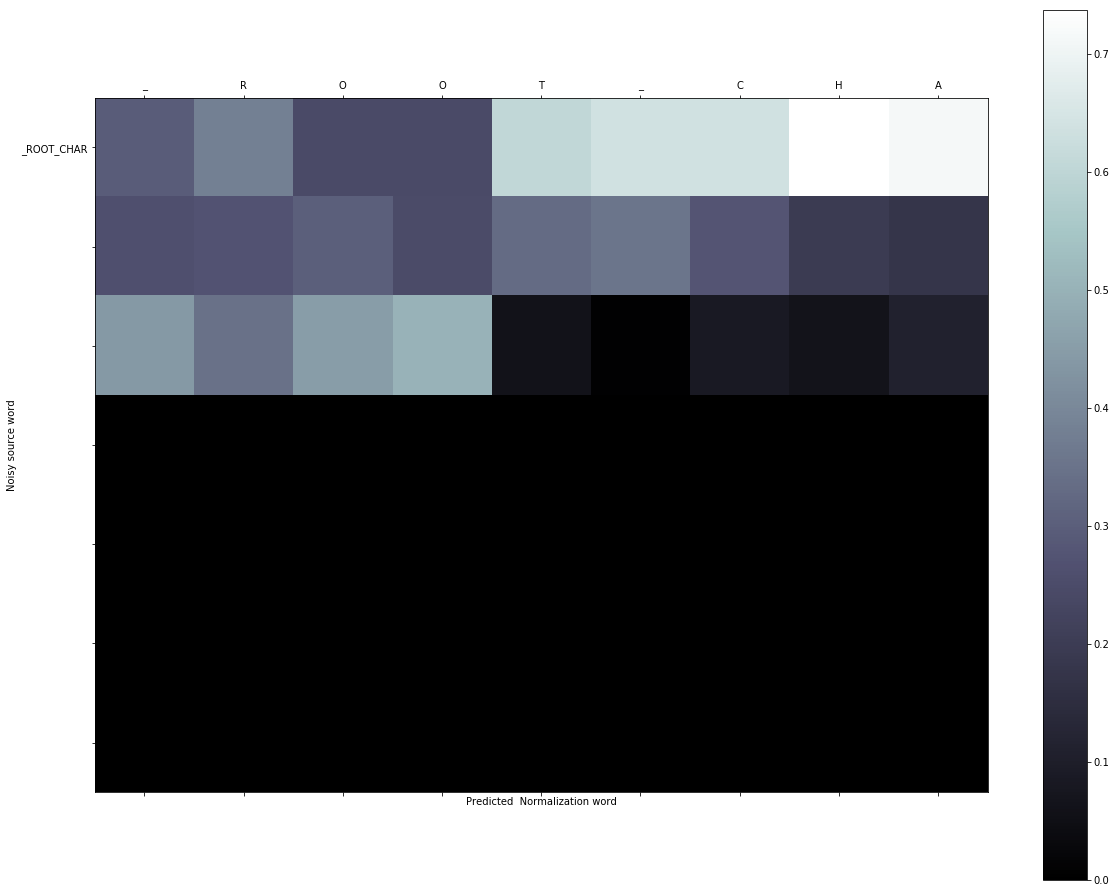

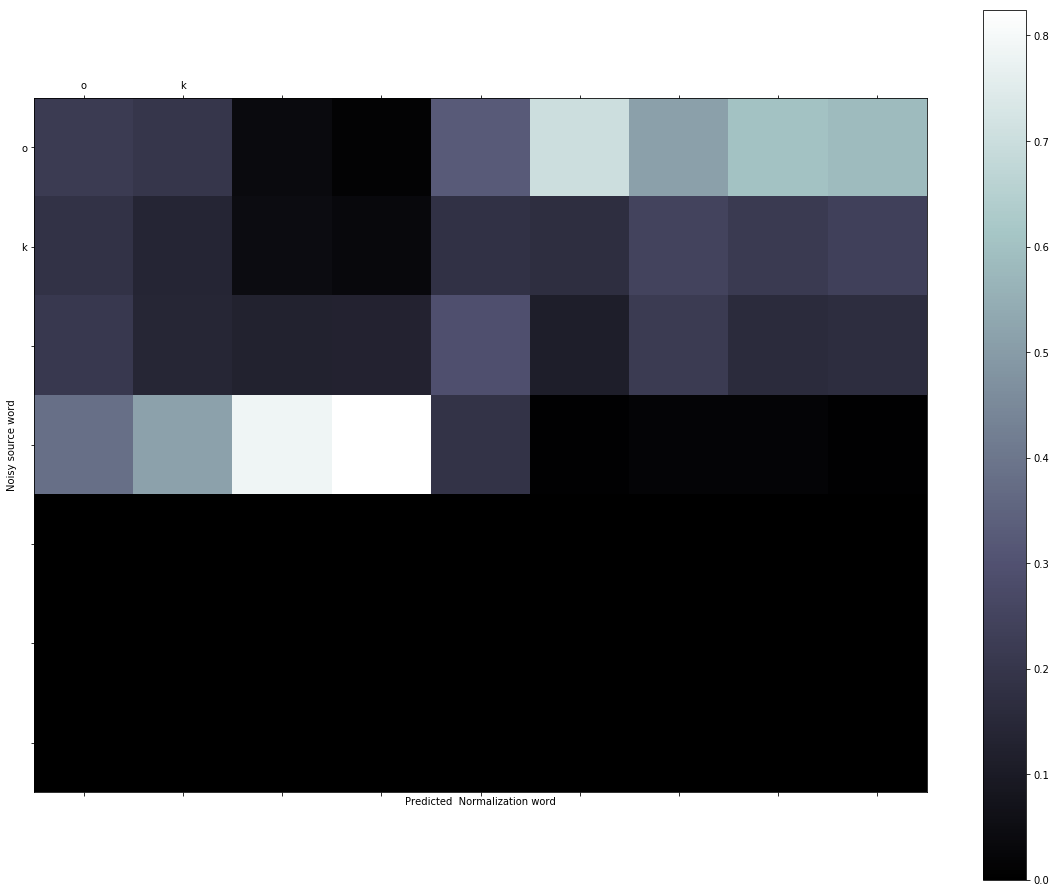

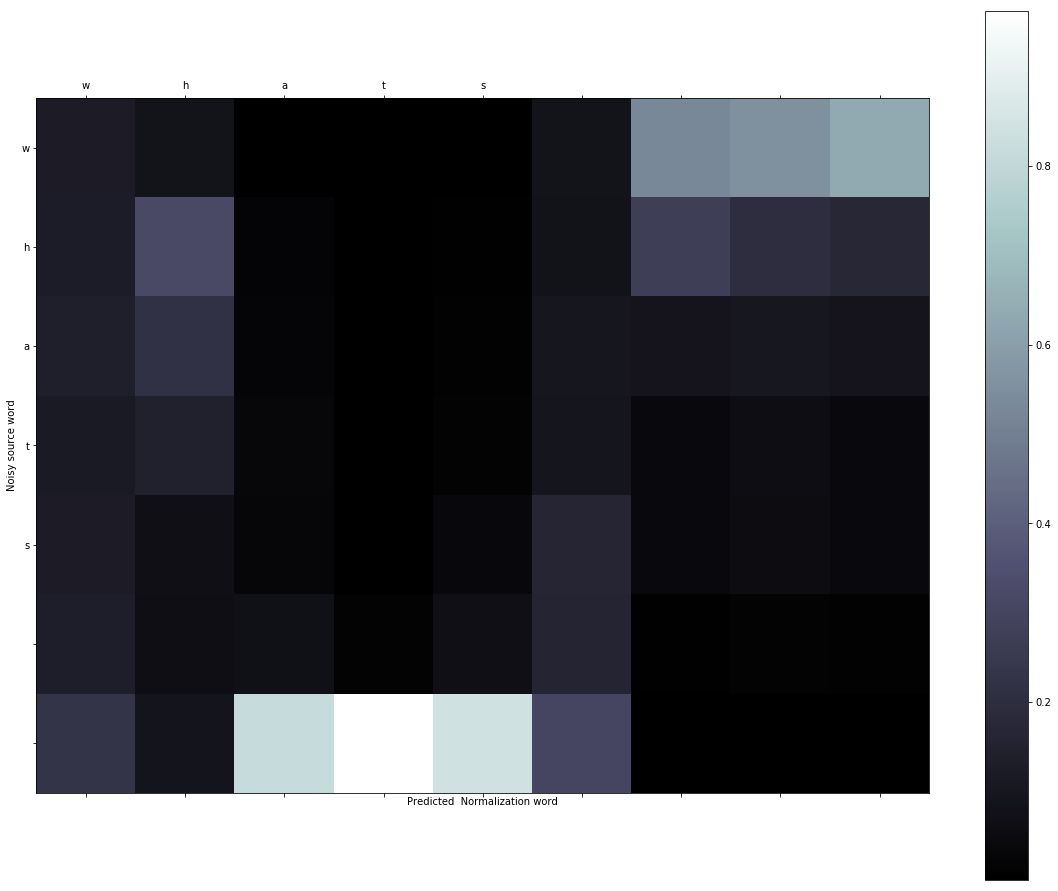

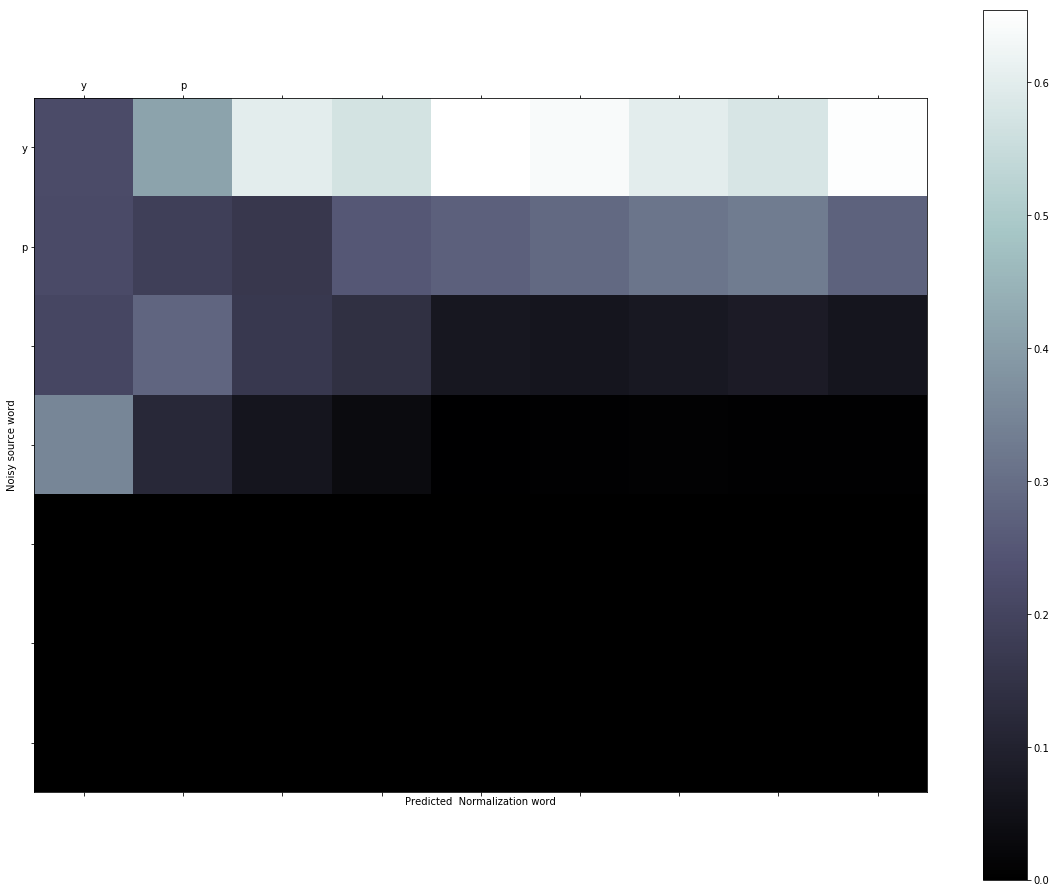

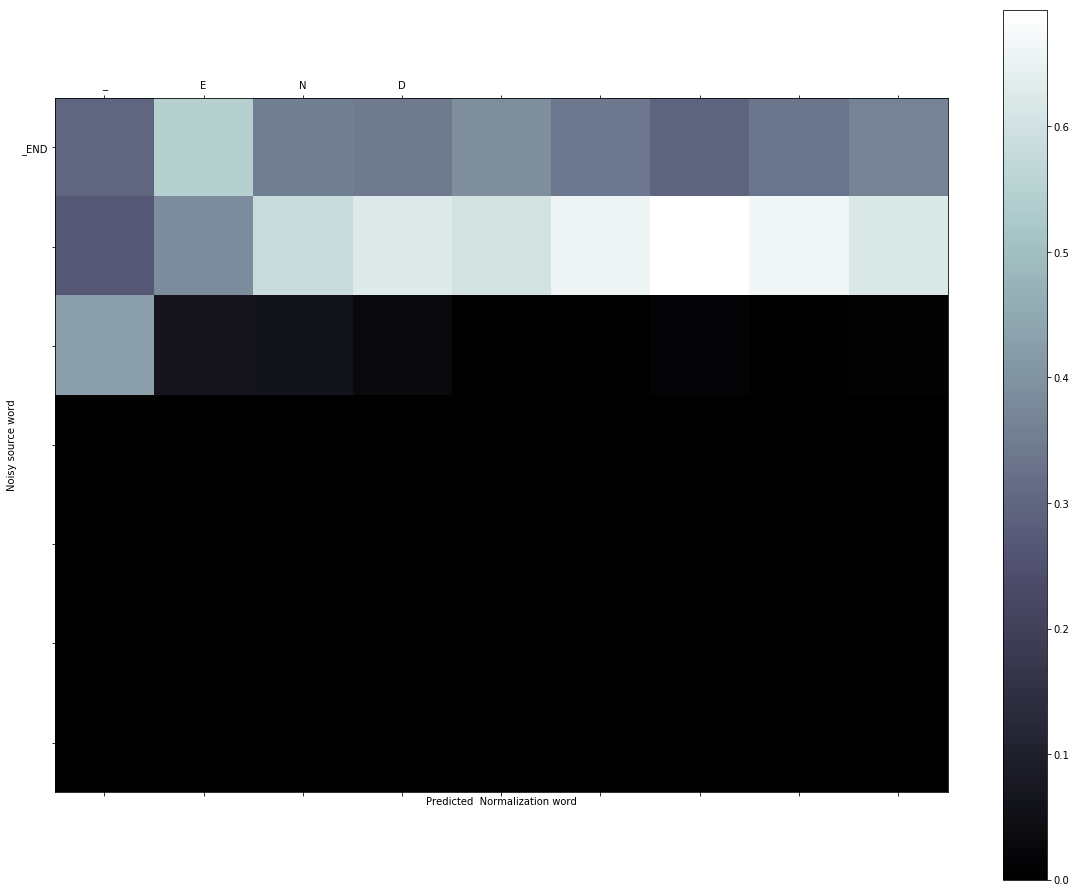

DECODED text is : ['_ROOT_CHAR', 'ok', 'whats', 'yp', '_END'] original is ['_ROOT_CHAR', 'ok', 'whats', 'yp', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    fuck
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['fuck']
Attention shape torch.Size([3, 5, 6])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000],
         [ 0.3846,  0.2725,  0.3429,  0.0000,  0.0000,  0.0000],
         [ 0.2518,  0.3083,  0.4399,  0.0000,  0.0000,  0.0000],
         [ 0.2538,  0.2532,  0.4930,  0.0000,  0.0000,  0.0000],
         [ 0.6086,  0.3319,  0.0595,  0.0000,  0.0000,  0.0000]],

        [[ 0.1508,  0.1594,  0.1532,  0.1328,  0.1509,  0.2529],
         [ 0.1756,  0.1444,  0.1816,  0.2134,  0.0517,  0.2333],
         [ 0.0043,  0.0093,  0.0517,  0.0429,  0.0687,  0.8232],
         [ 0.0301,  0.0470,  0.1435,  0.1450,  0.2876,  0.3

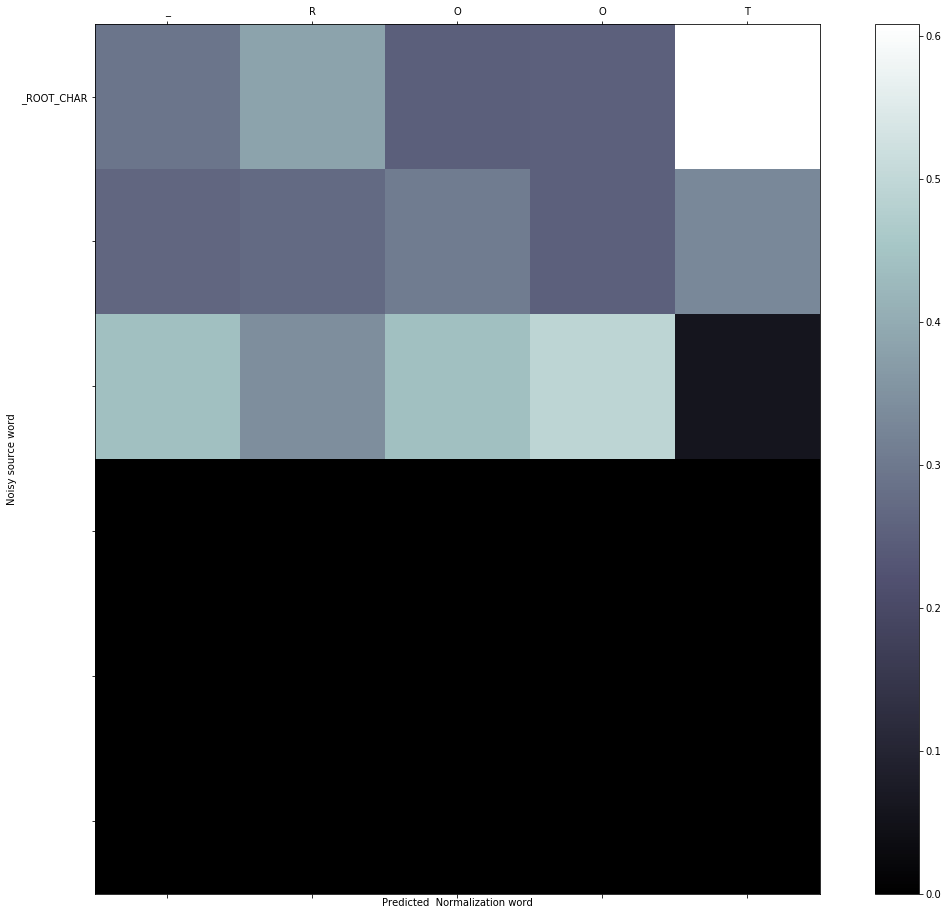

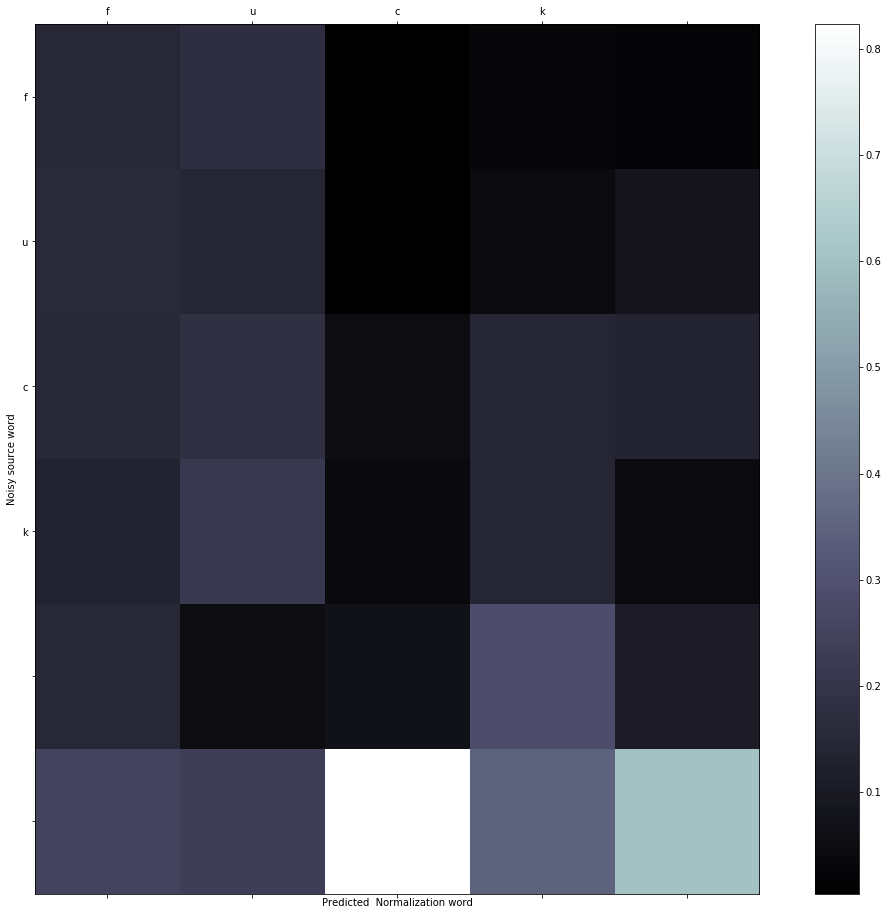

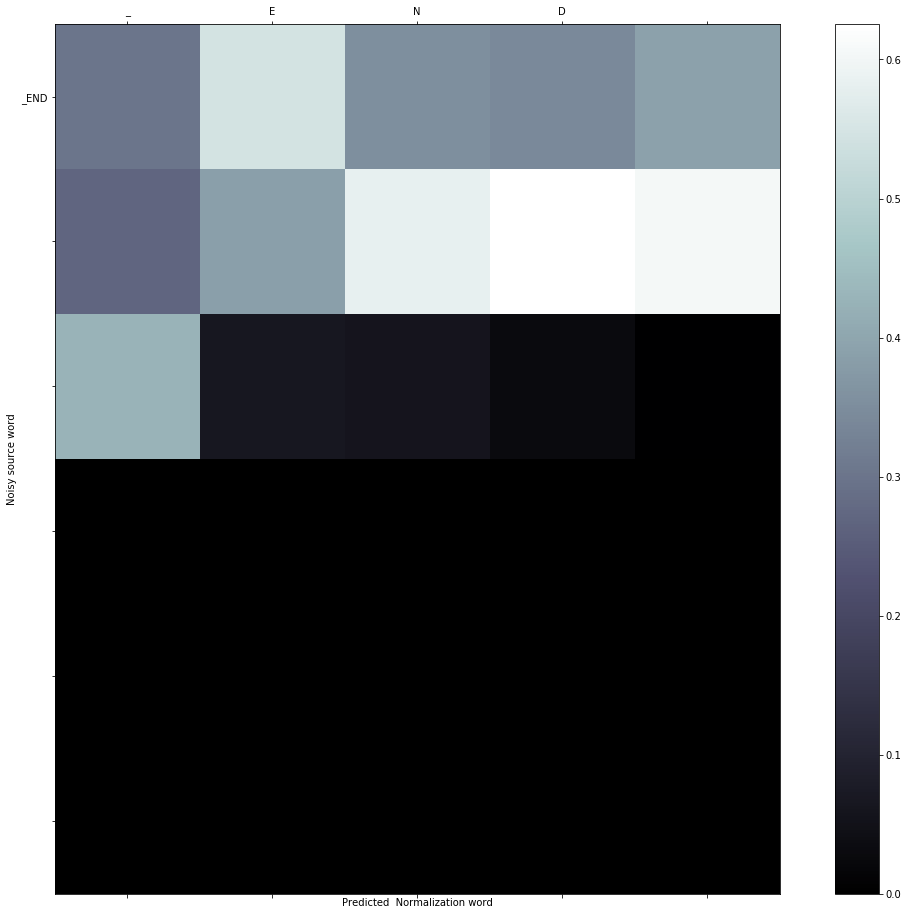

DECODED text is : ['_ROOT_CHAR', 'fuck', '_END'] original is ['_ROOT_CHAR', 'fuck', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    fck
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['fck']
Attention shape torch.Size([3, 5, 5])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000],
         [ 0.3841,  0.2722,  0.3438,  0.0000,  0.0000],
         [ 0.2510,  0.3076,  0.4414,  0.0000,  0.0000],
         [ 0.2531,  0.2527,  0.4942,  0.0000,  0.0000],
         [ 0.6081,  0.3321,  0.0598,  0.0000,  0.0000]],

        [[ 0.1616,  0.1759,  0.1640,  0.1848,  0.3137],
         [ 0.1429,  0.1396,  0.2422,  0.0858,  0.3896],
         [ 0.0182,  0.0299,  0.0640,  0.1419,  0.7460],
         [ 0.0421,  0.1046,  0.0899,  0.1636,  0.5998],
         [ 0.1293,  0.2795,  0.1377,  0.2940,  0.1596]],

        [[ 0.3018,  0.2705,  0.4277,  0.0000,

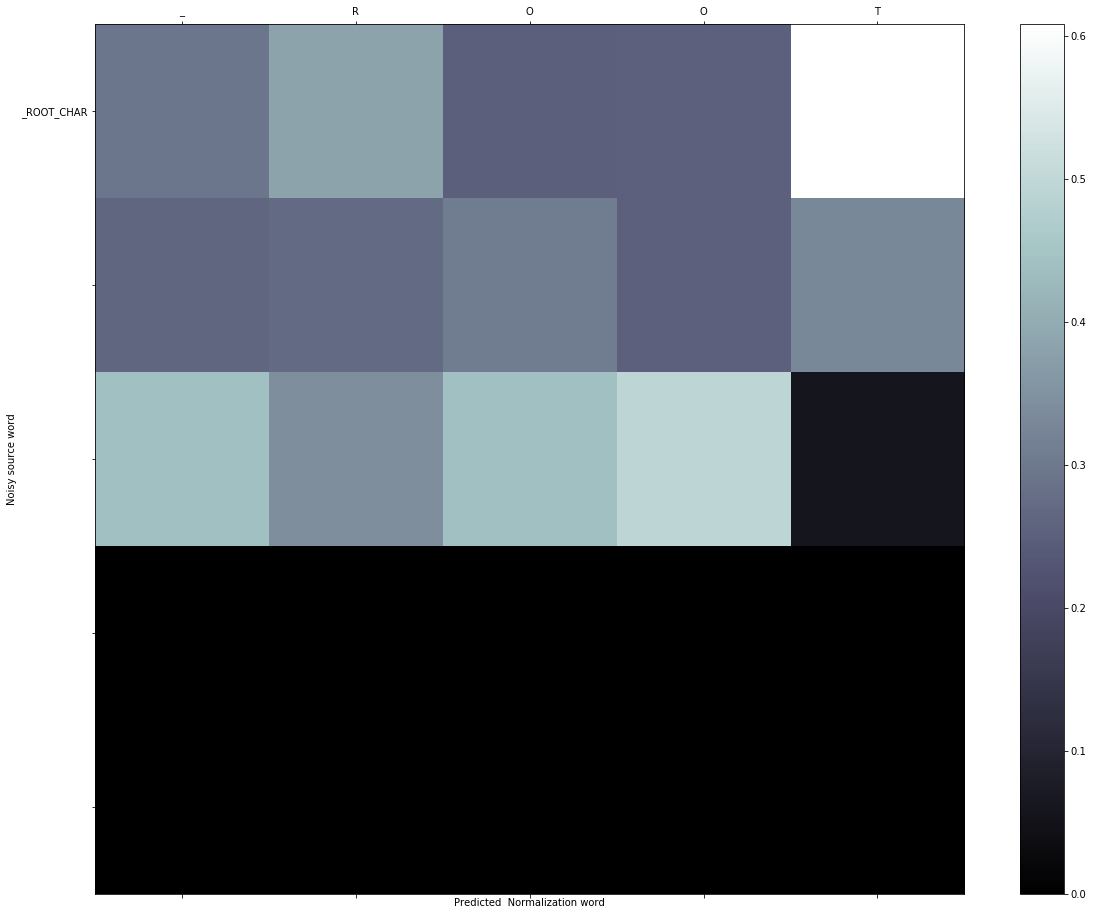

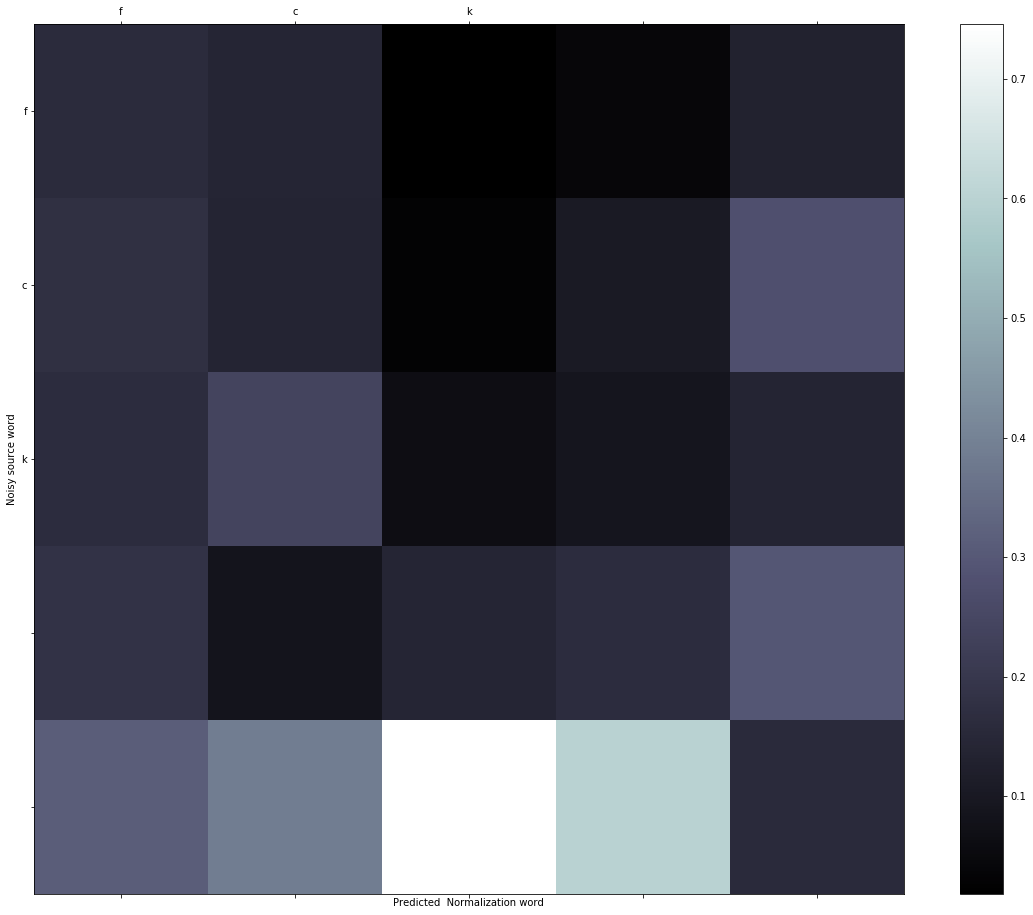

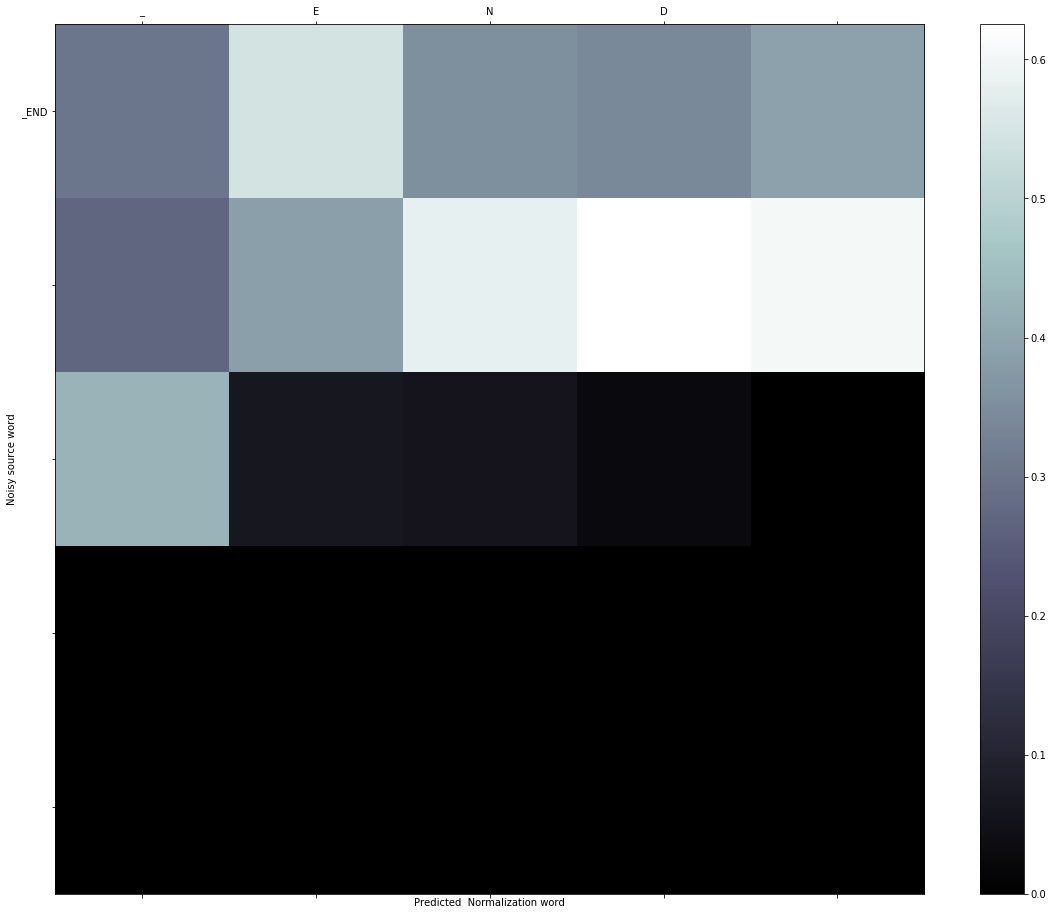

DECODED text is : ['_ROOT_CHAR', 'fck', '_END'] original is ['_ROOT_CHAR', 'fck', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Congrat's
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ["Congrat's"]
Attention shape torch.Size([3, 9, 11])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3823,  0.2715,  0.3462,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2465,  0.3042,  0.4493,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2513,  0.2508,  0.4979,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6074,  0.3313,  0.0613,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000]

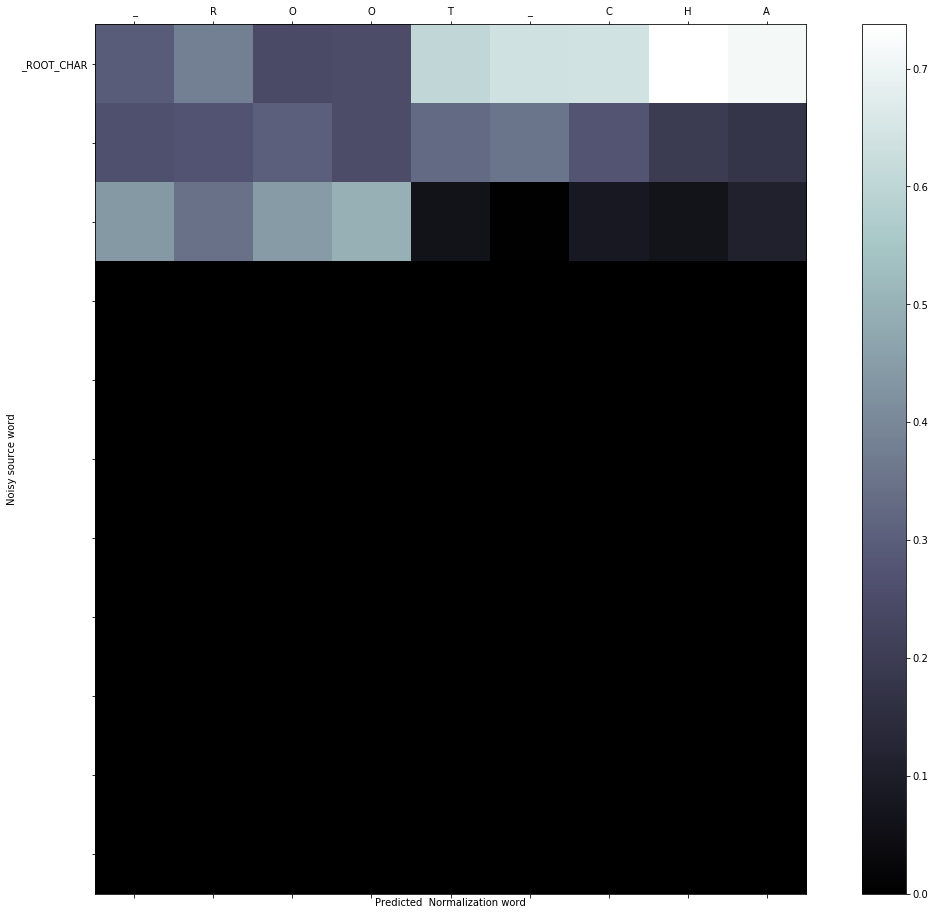

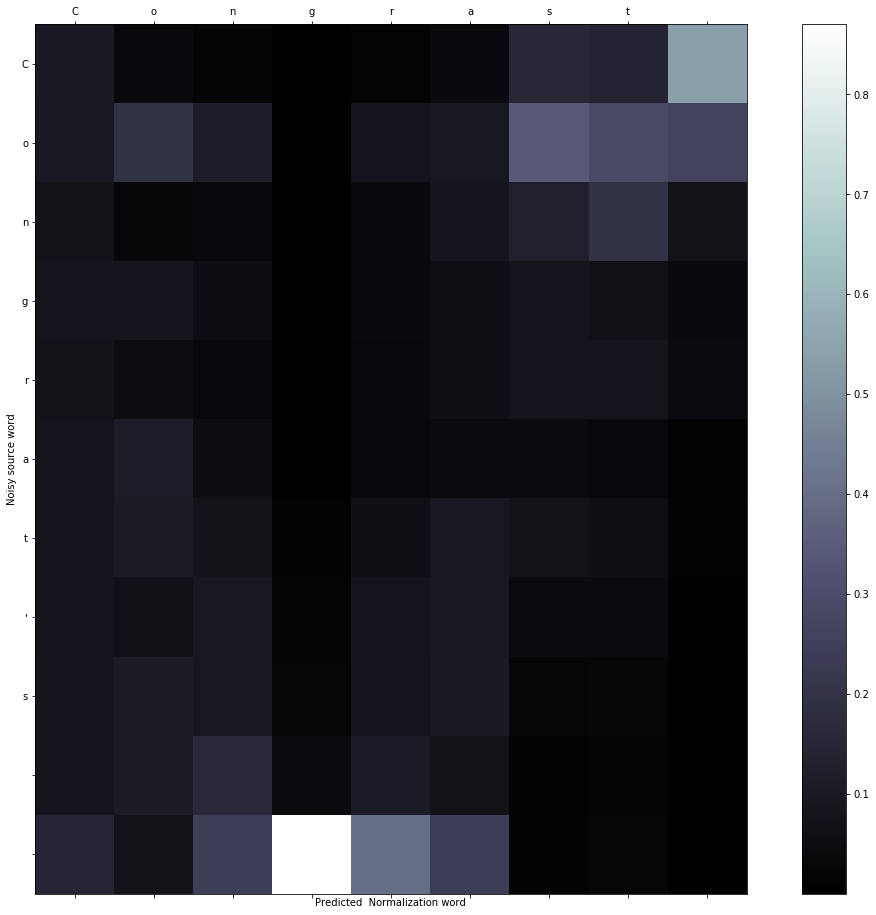

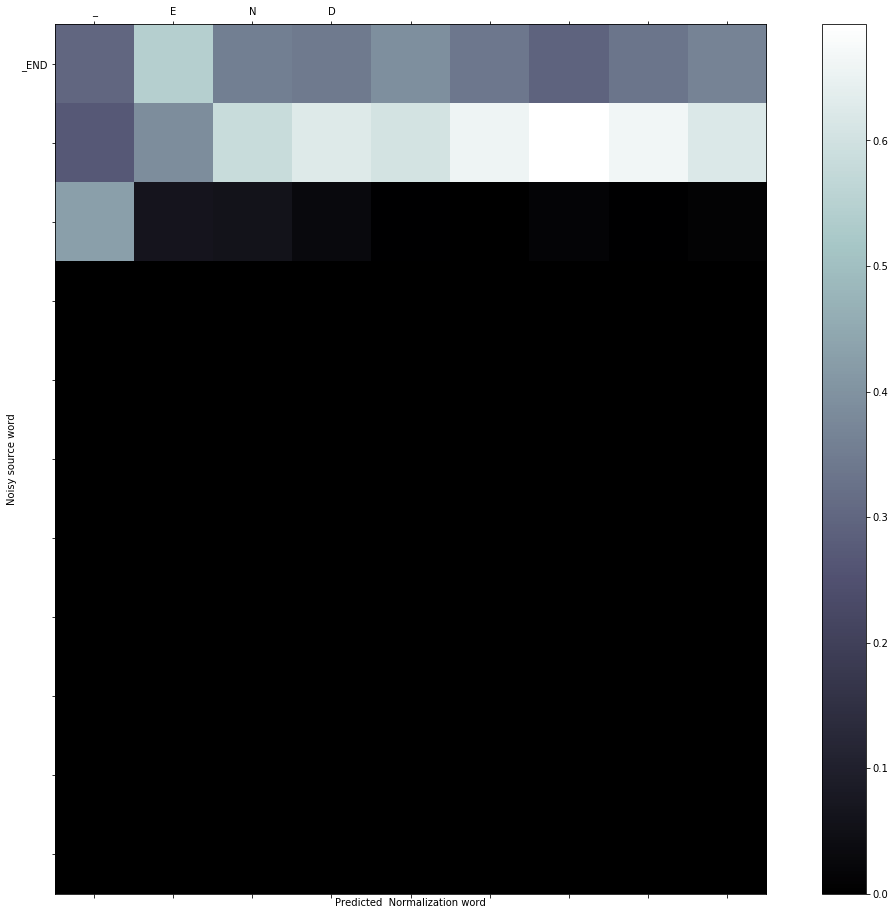

DECODED text is : ['_ROOT_CHAR', 'Congrast', '_END'] original is ['_ROOT_CHAR', "Congrat's", '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    roastin
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['roastin']
Attention shape torch.Size([3, 9, 9])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.3829,  0.2719,  0.3452,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.2485,  0.3061,  0.4455,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.2522,  0.2522,  0.4956,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.6078,  0.3319,  0.0603,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.6380,  0.3535,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000,
         

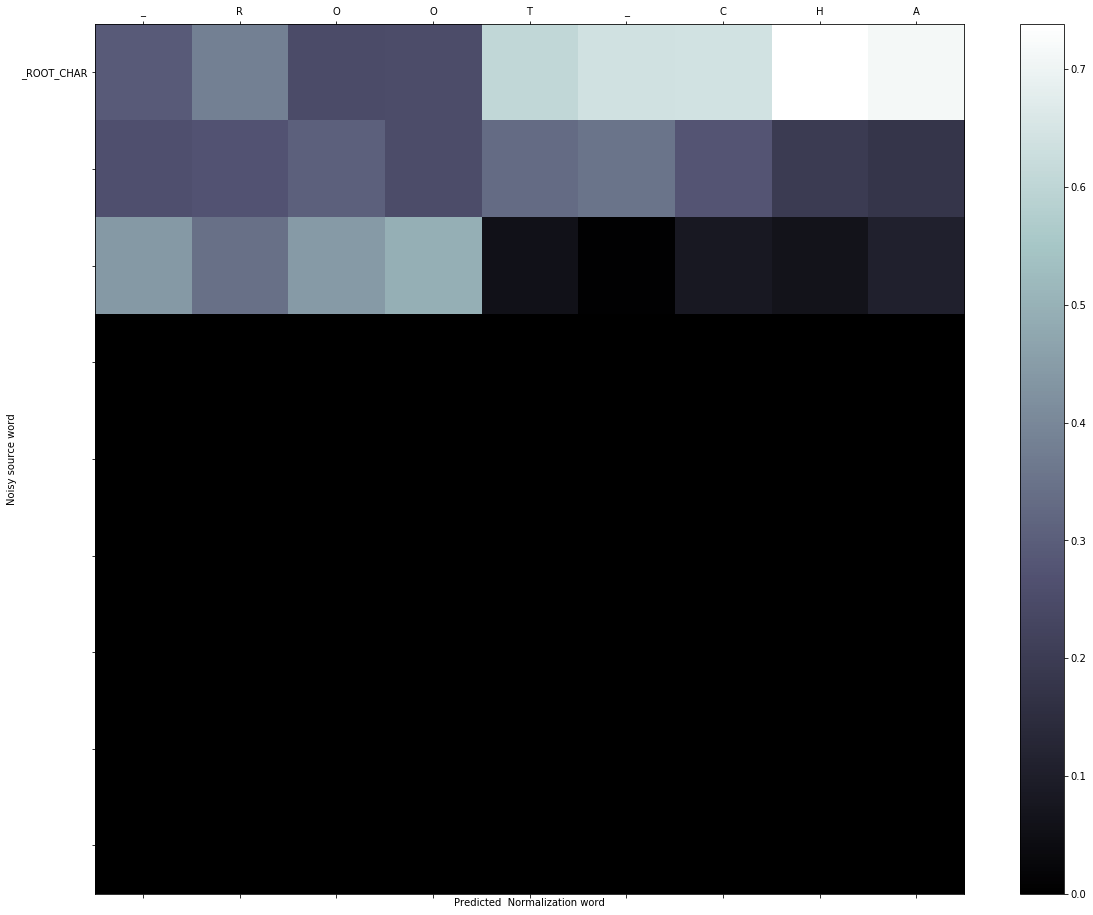

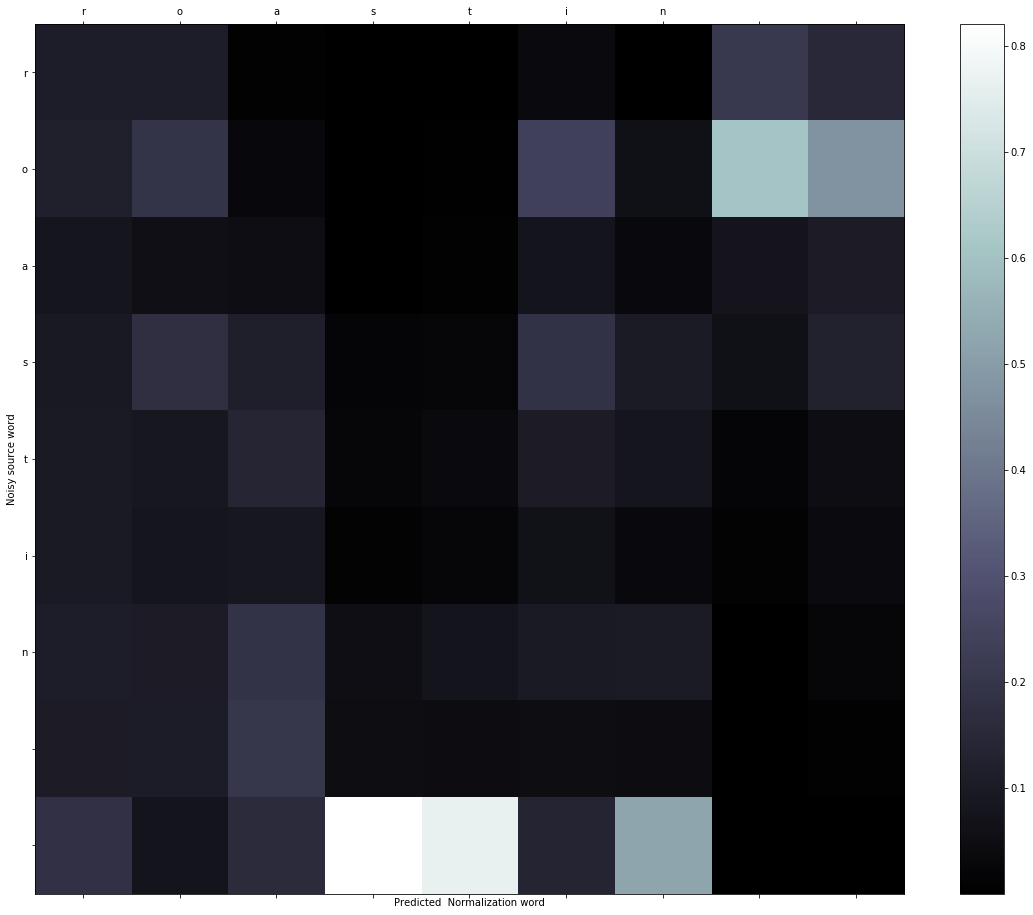

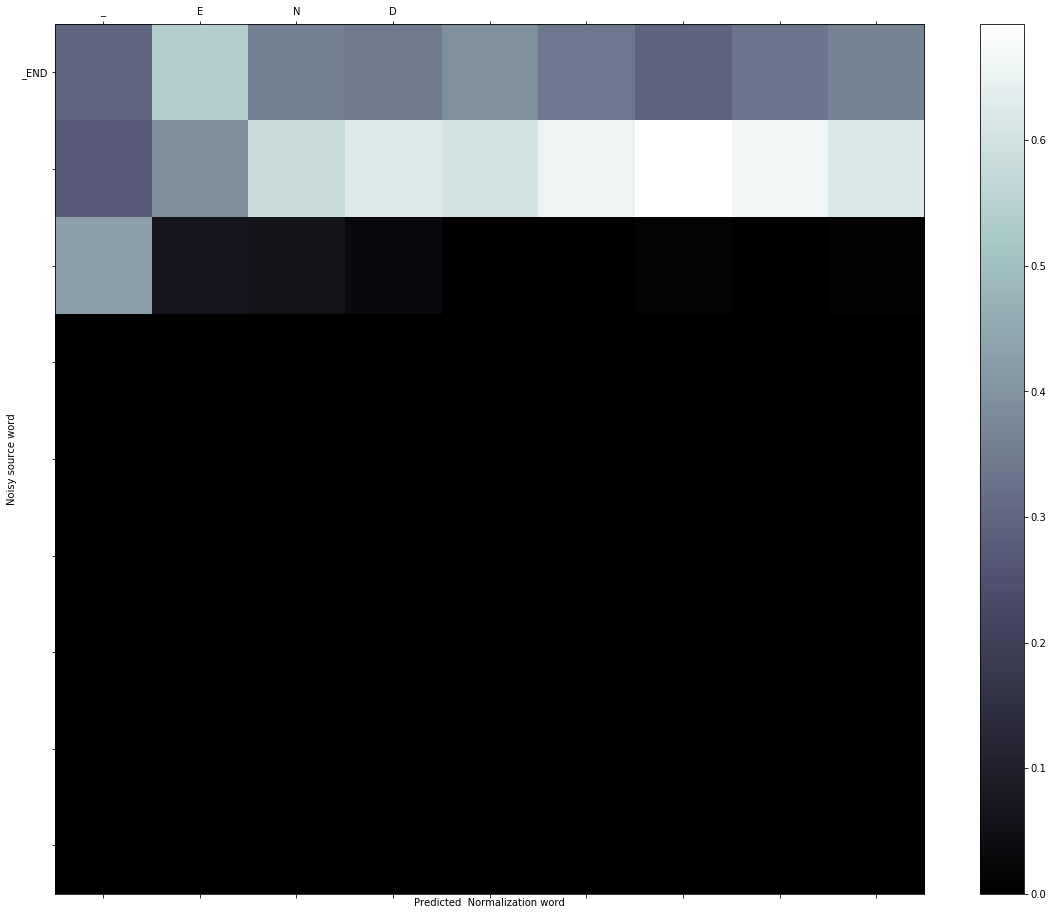

DECODED text is : ['_ROOT_CHAR', 'roastin', '_END'] original is ['_ROOT_CHAR', 'roastin', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    fking
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['fking']
Attention shape torch.Size([3, 7, 7])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3835,  0.2721,  0.3445,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2499,  0.3067,  0.4434,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2523,  0.2519,  0.4958,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6080,  0.3317,  0.0603,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6382,  0.3533,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6411,  0.2768,  0.0820,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.1280,  0.1363,  0.1300,  0.1310,  0.1237,  0.1233,  0.2277],
     

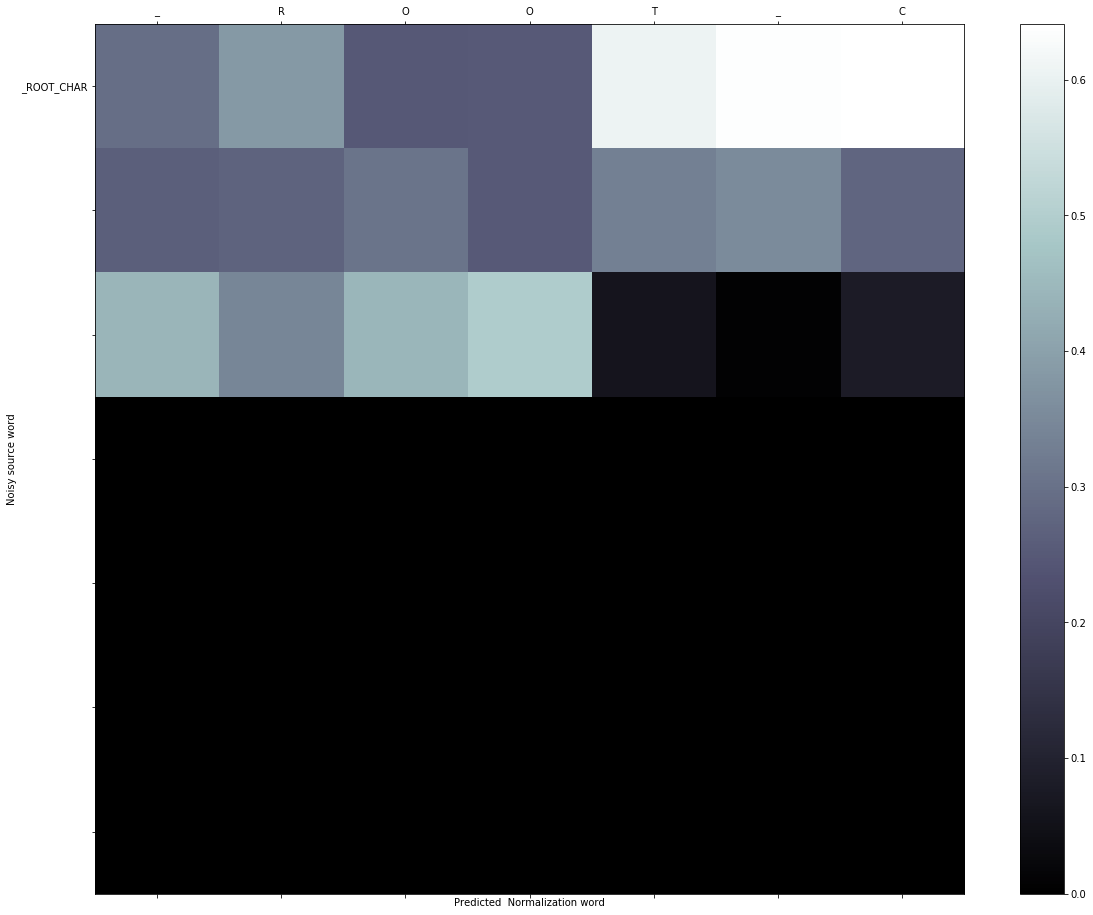

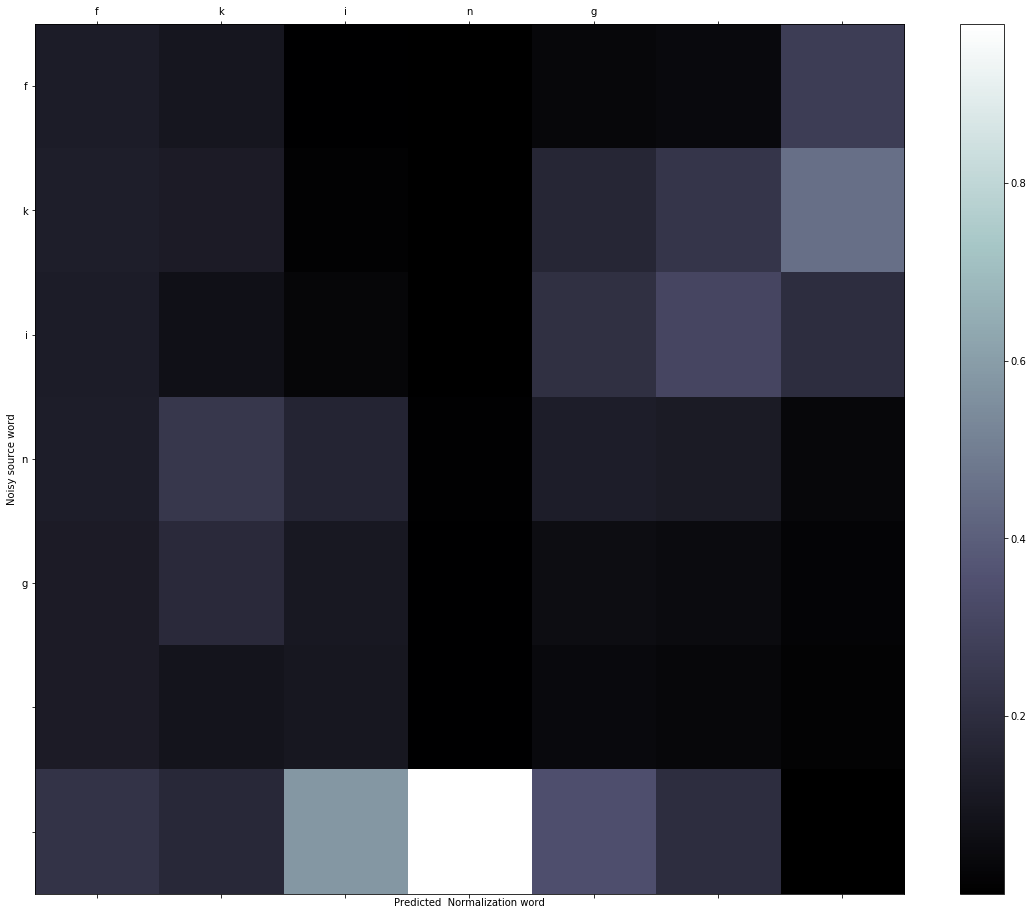

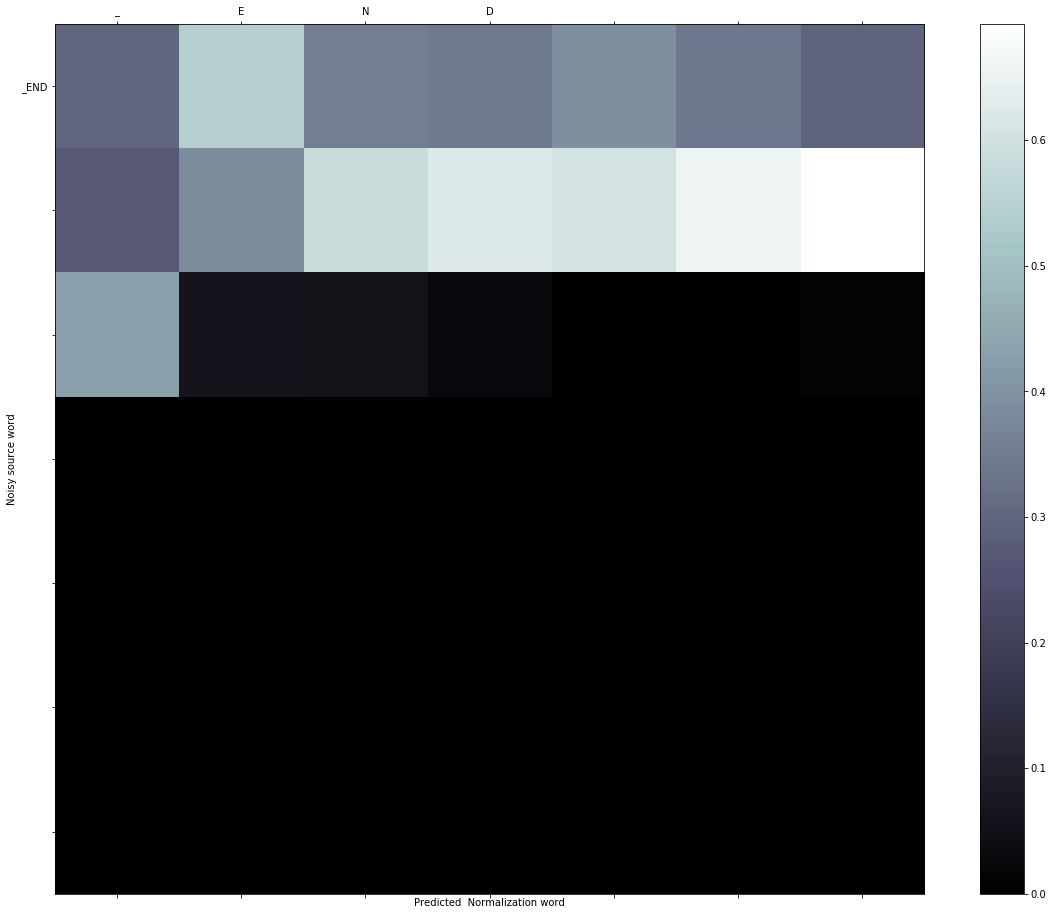

DECODED text is : ['_ROOT_CHAR', 'fking', '_END'] original is ['_ROOT_CHAR', 'fking', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Yes
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    i
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    hate
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    NYC
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    its
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    so
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    fking
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    gay
Please type what you want to normalize word b

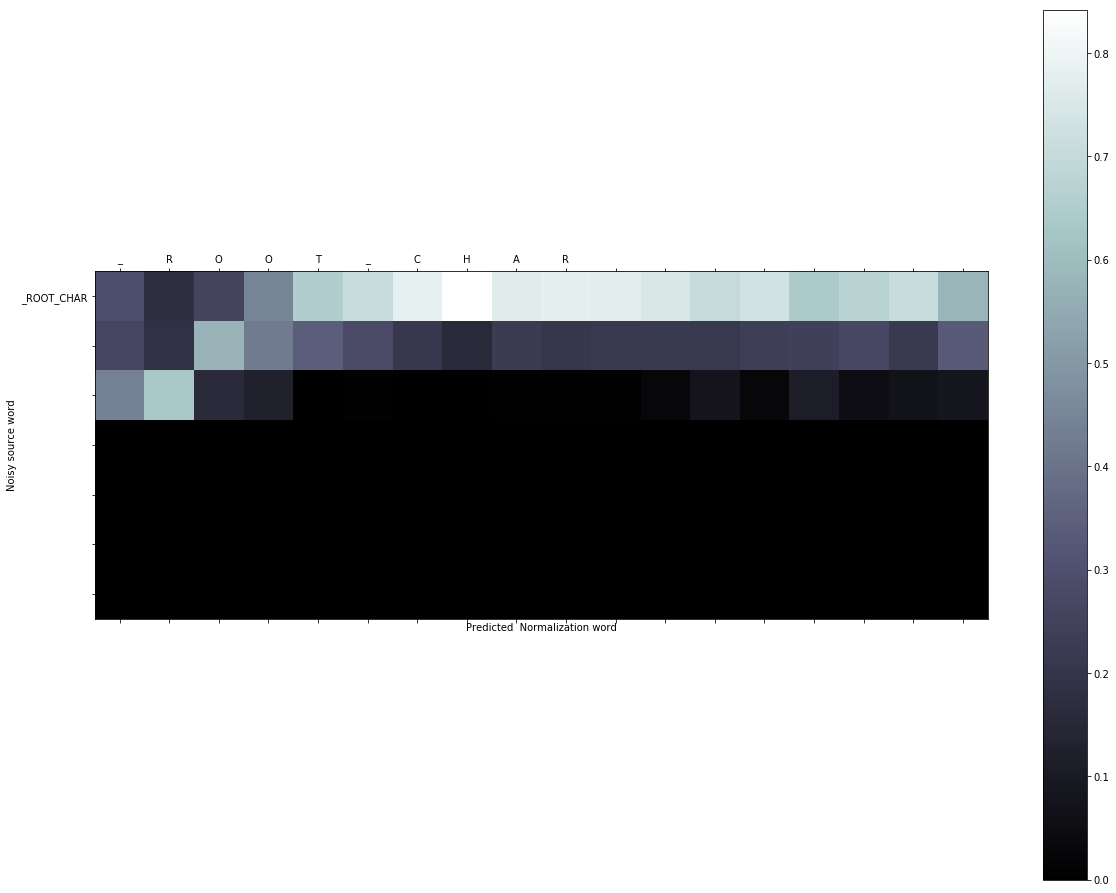

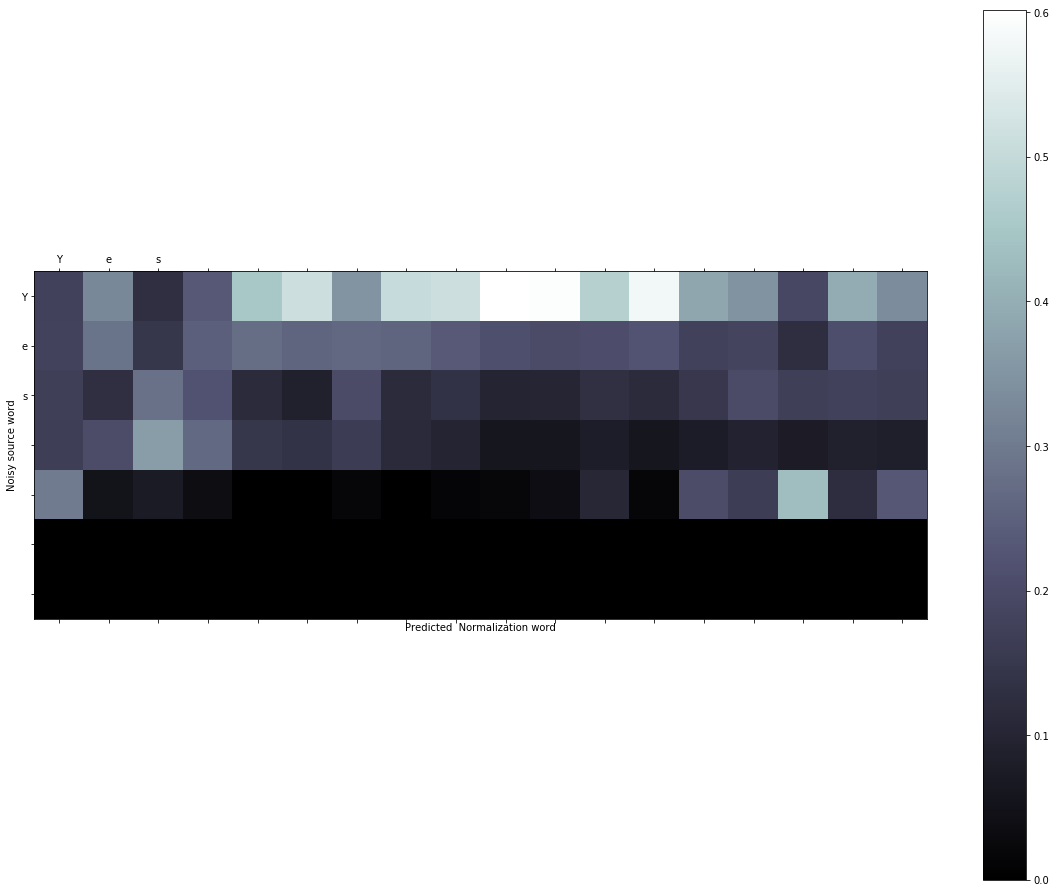

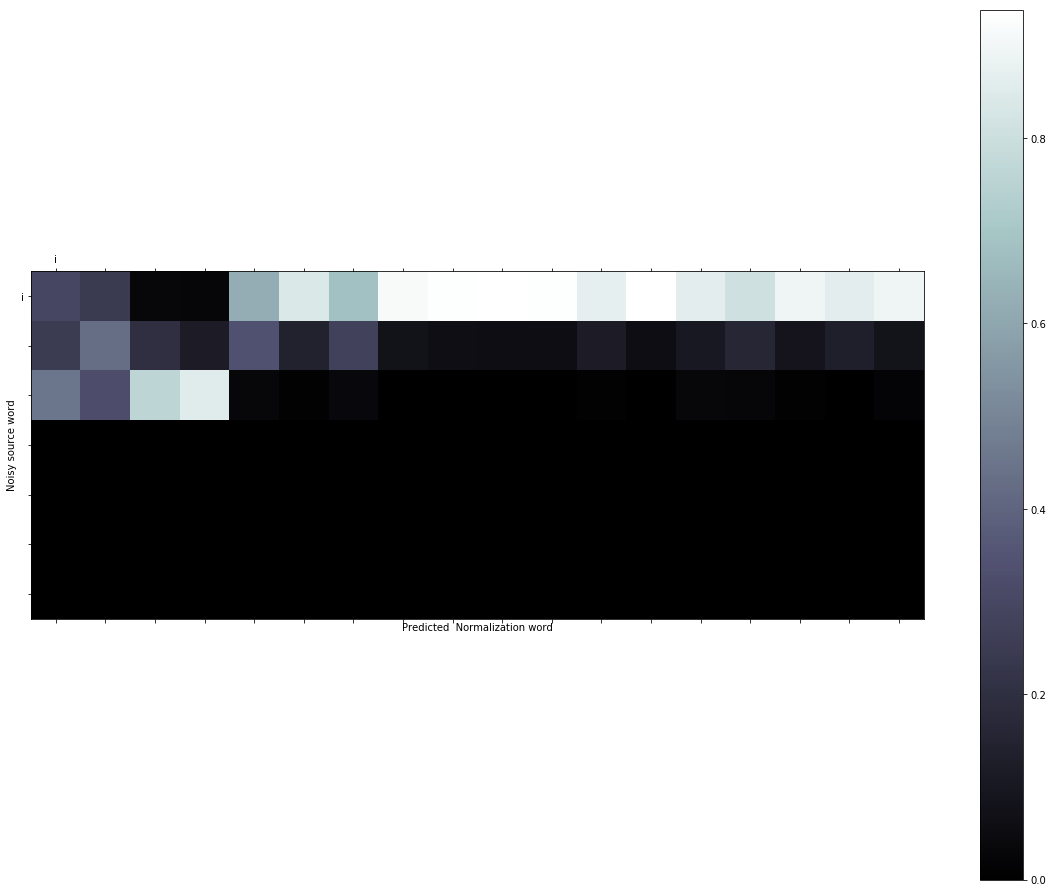

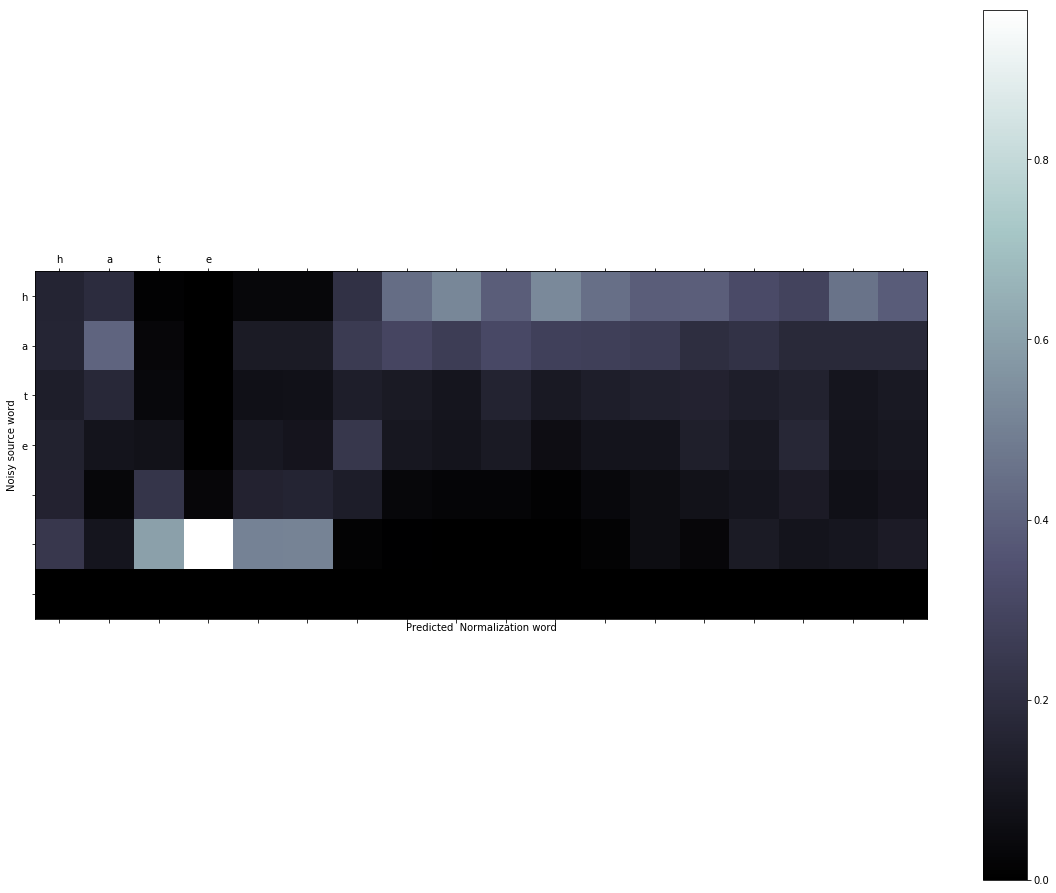

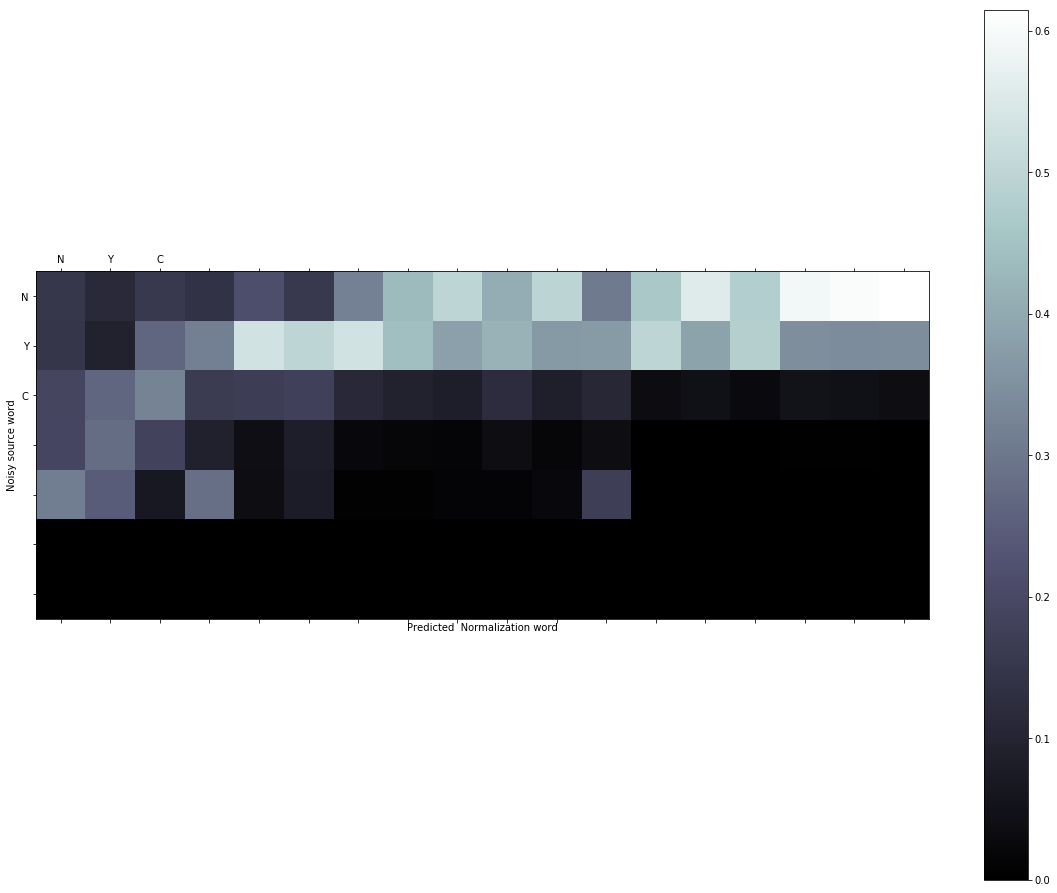

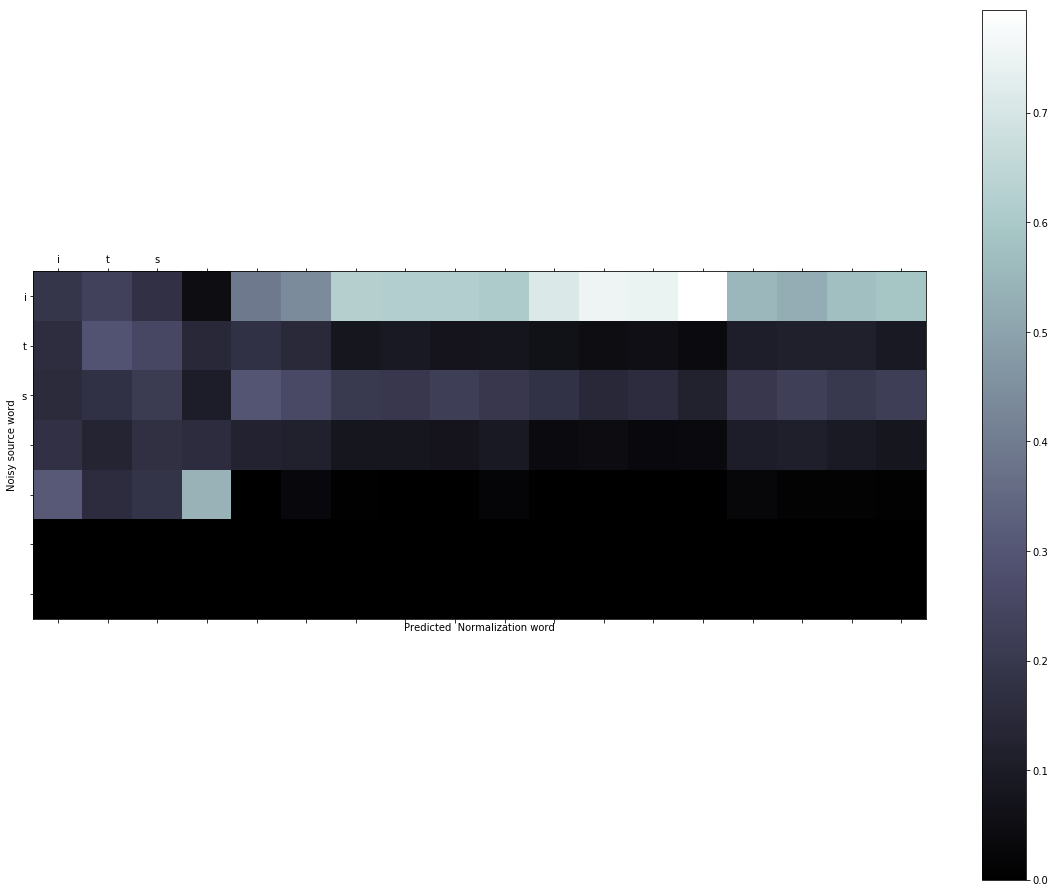

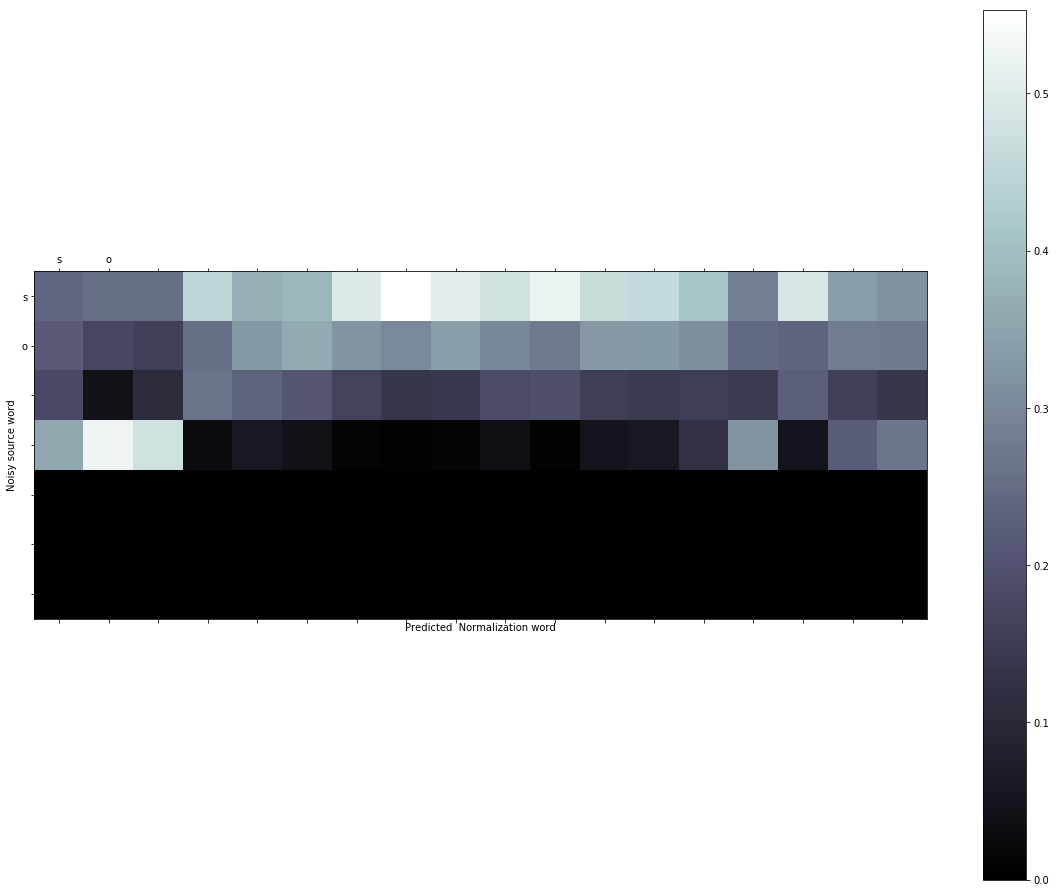

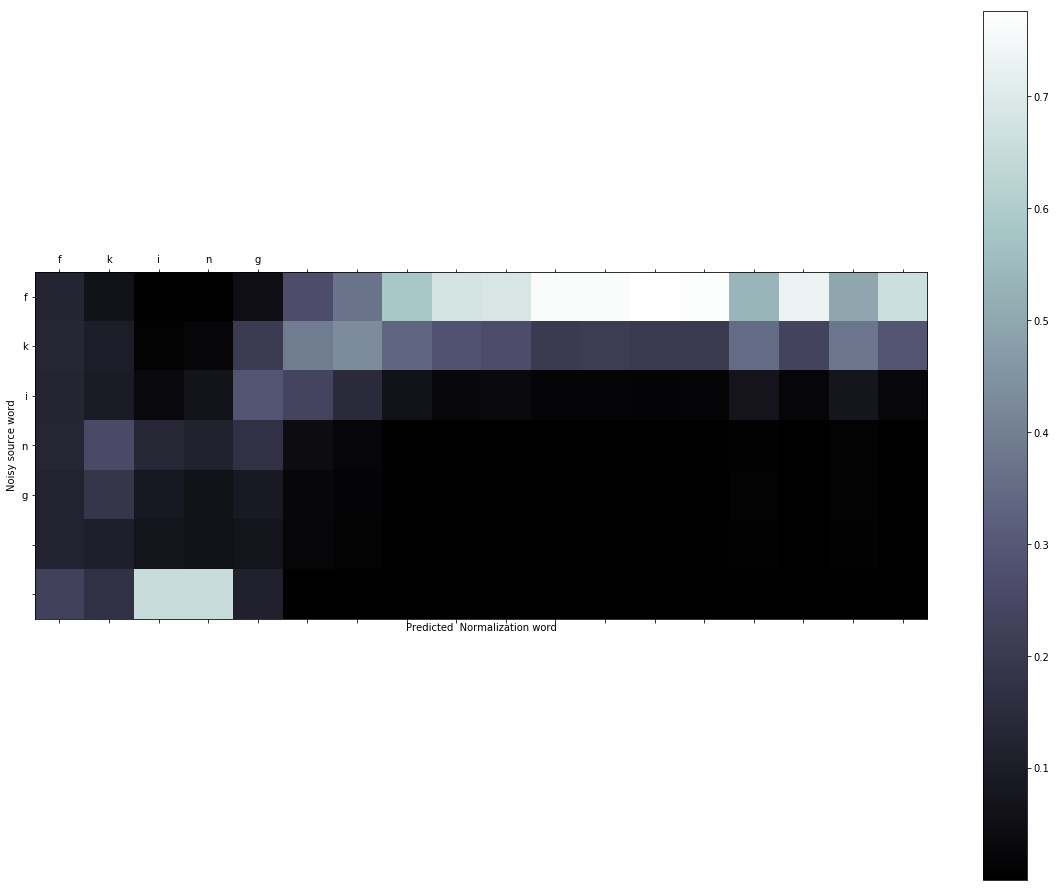

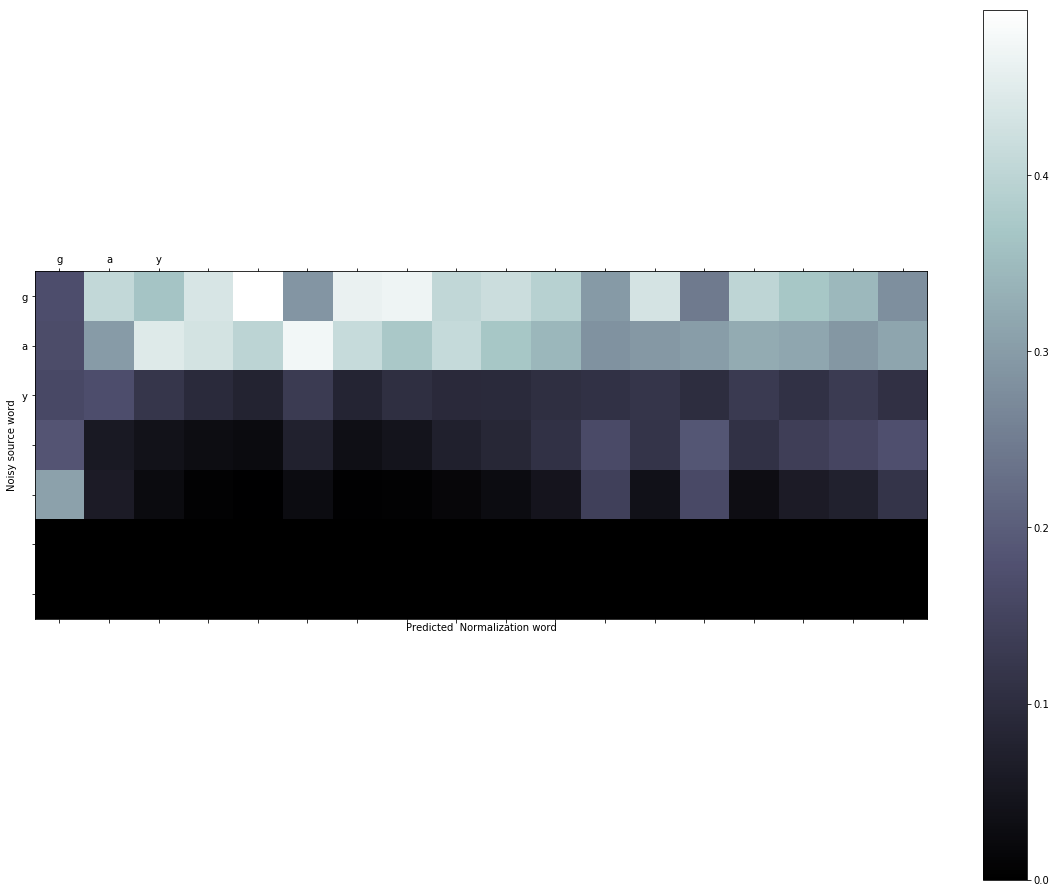

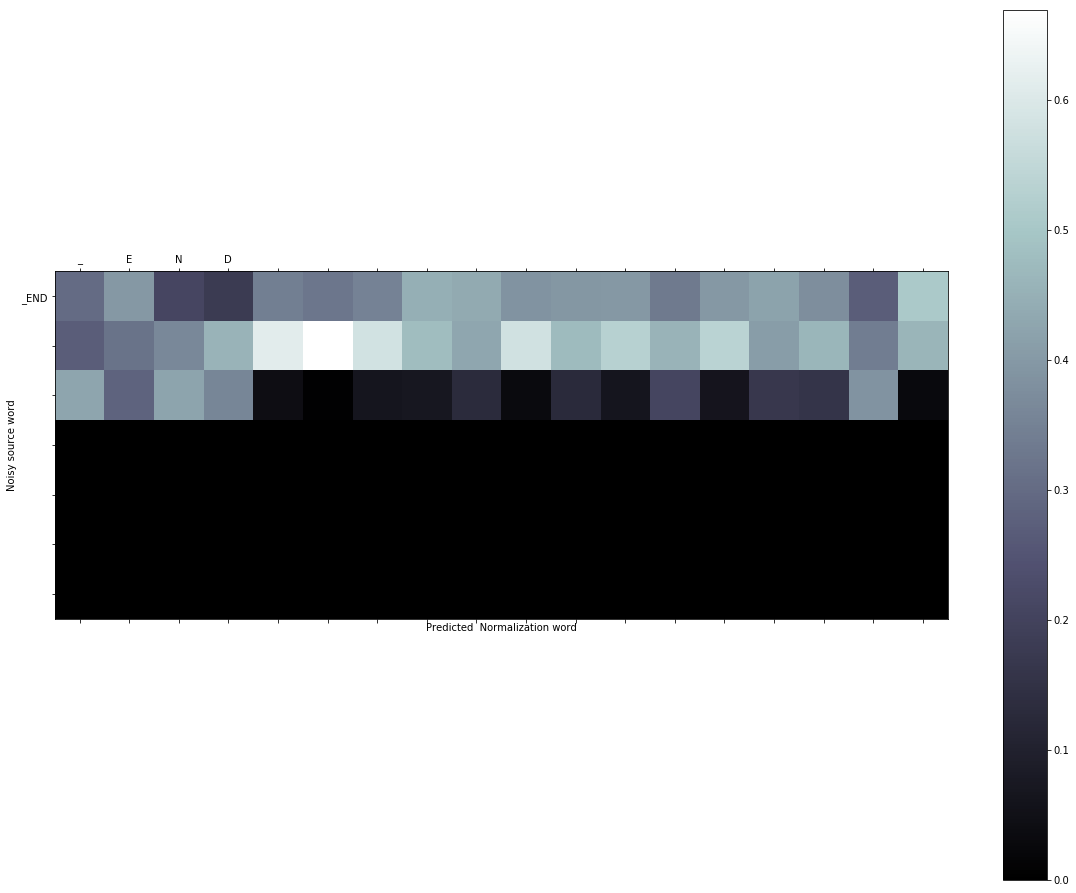

DECODED text is : ['_ROOT_CHAR', 'Yes', 'i', 'hate', 'NYC', 'its', 'so', 'fking', 'gay', '_END'] original is ['_ROOT_CHAR', 'Yes', 'i', 'hate', 'NYC', 'its', 'so', 'fking', 'gay', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Yayyy
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Yayyy']
Attention shape torch.Size([3, 5, 7])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3837,  0.2722,  0.3441,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2505,  0.3073,  0.4422,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2533,  0.2525,  0.4942,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6087,  0.3315,  0.0598,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.1148,  0.1284,  0.1194,  0.1357,  0.1371,  0.1399,  0.2247],
         [ 0.2716,  0.3235,  0.2095,  0.0507,  0.0441,  0.0398,

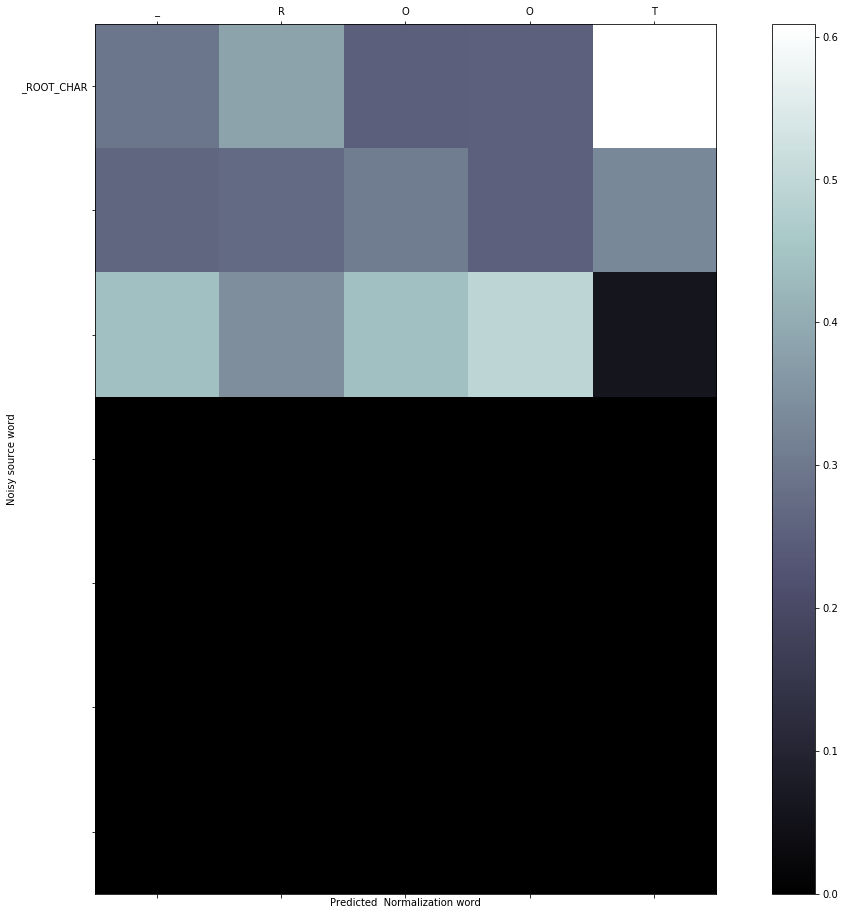

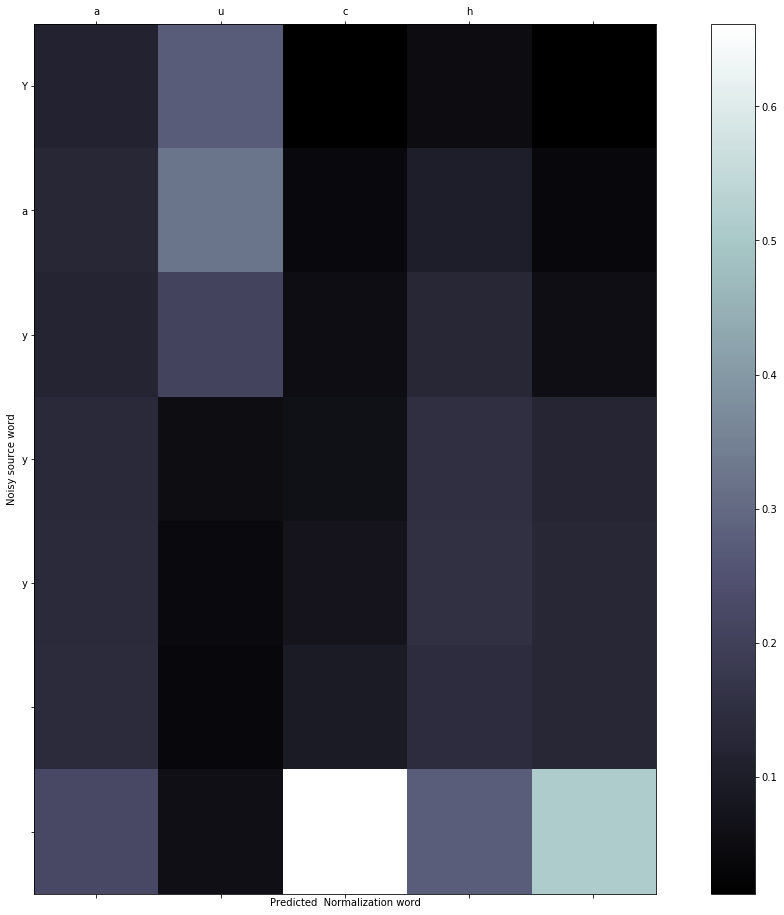

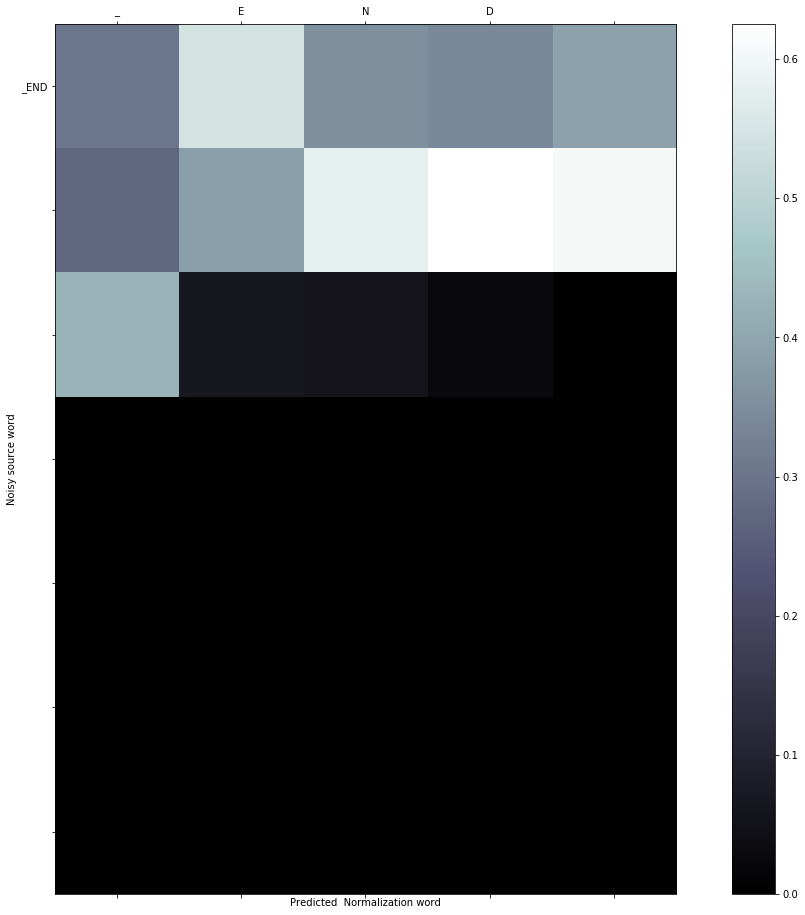

DECODED text is : ['_ROOT_CHAR', 'auch', '_END'] original is ['_ROOT_CHAR', 'Yayyy', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    thts
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['thts']
Attention shape torch.Size([3, 5, 6])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000],
         [ 0.3786,  0.2705,  0.3509,  0.0000,  0.0000,  0.0000],
         [ 0.2434,  0.3022,  0.4544,  0.0000,  0.0000,  0.0000],
         [ 0.2490,  0.2499,  0.5011,  0.0000,  0.0000,  0.0000],
         [ 0.6067,  0.3317,  0.0617,  0.0000,  0.0000,  0.0000]],

        [[ 0.1504,  0.1367,  0.1602,  0.1398,  0.1528,  0.2602],
         [ 0.2032,  0.1731,  0.1721,  0.1331,  0.1243,  0.1942],
         [ 0.0196,  0.0218,  0.0429,  0.0459,  0.1067,  0.7631],
         [ 0.0328,  0.0462,  0.0696,  0.0989,  0.2388,  0.5137],
         [ 0.0285, 

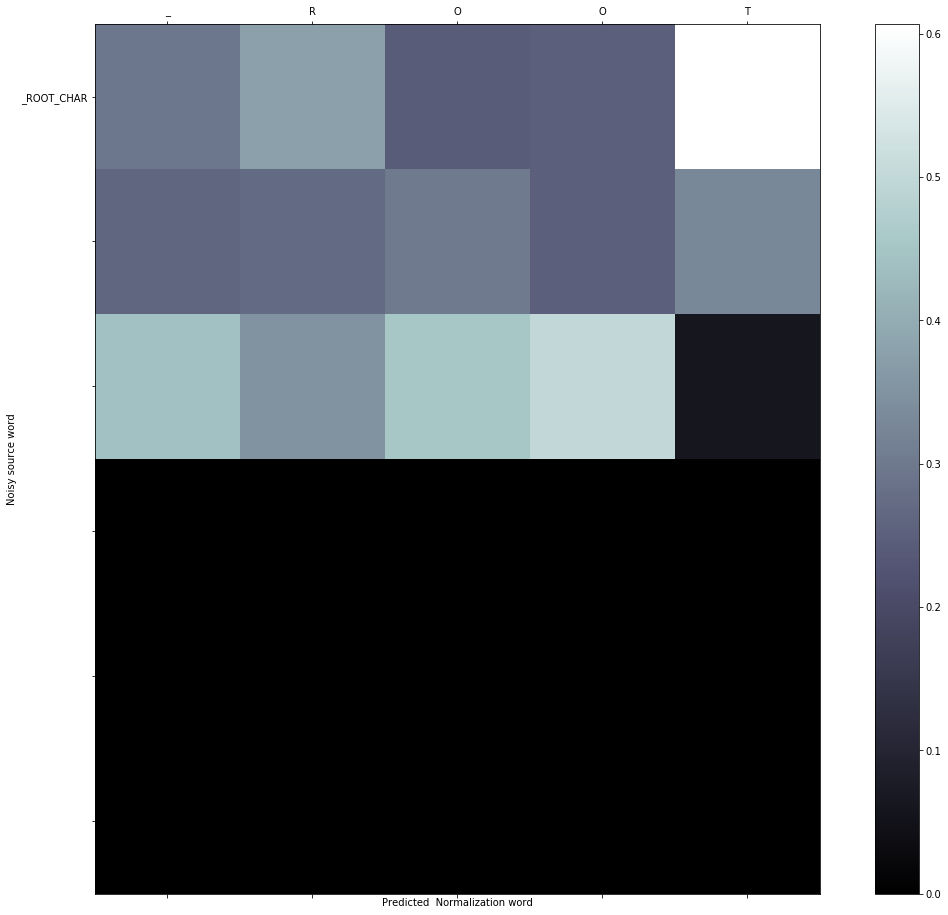

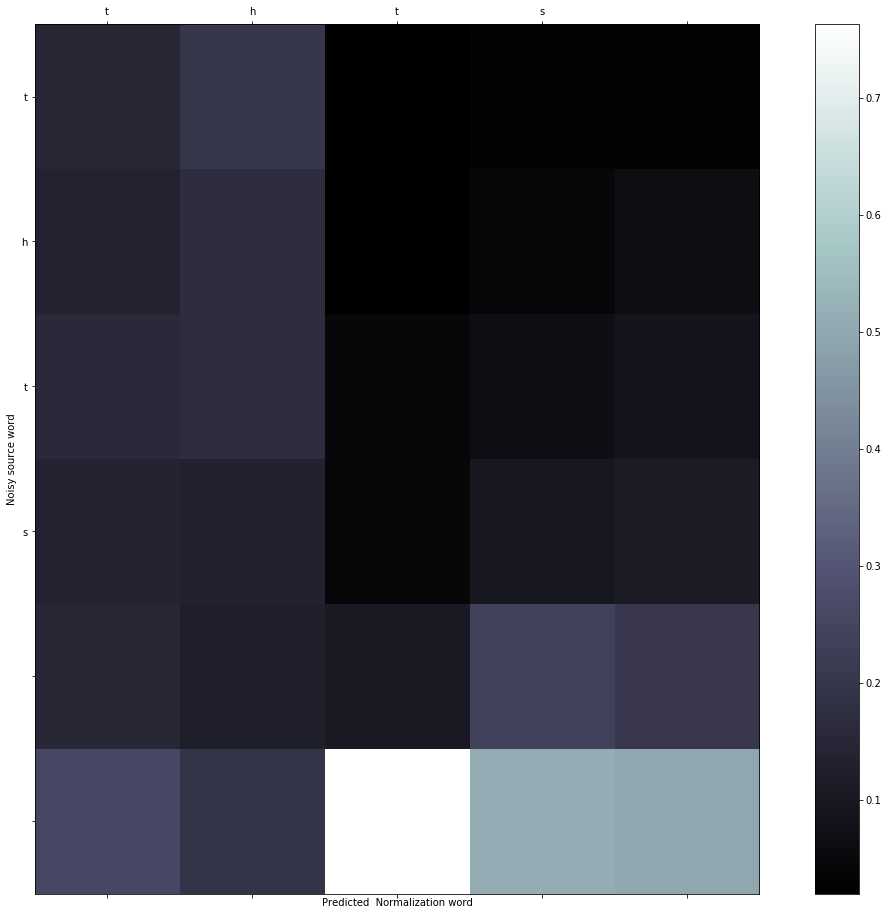

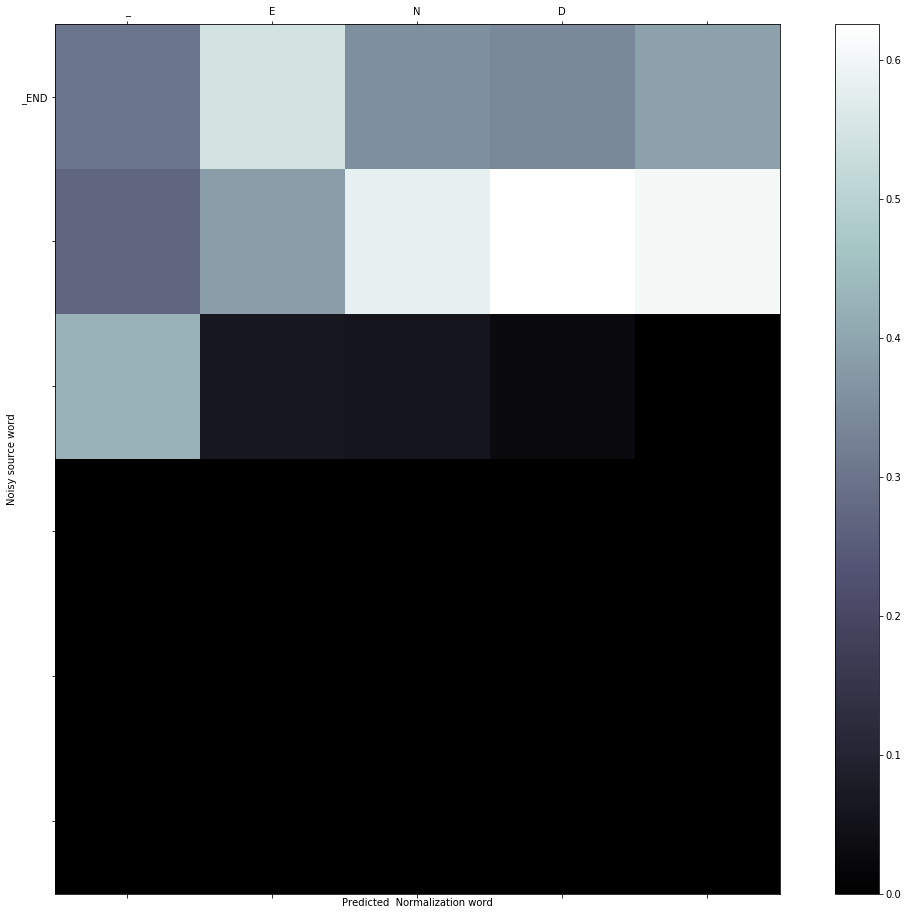

DECODED text is : ['_ROOT_CHAR', 'thts', '_END'] original is ['_ROOT_CHAR', 'thts', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    workin
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['workin']
Attention shape torch.Size([3, 7, 8])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.3828,  0.2717,  0.3455,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2483,  0.3056,  0.4460,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2514,  0.2514,  0.4971,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6077,  0.3318,  0.0605,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6382,  0.3534,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6413,  0.2767,  0.0819,  0.0000,

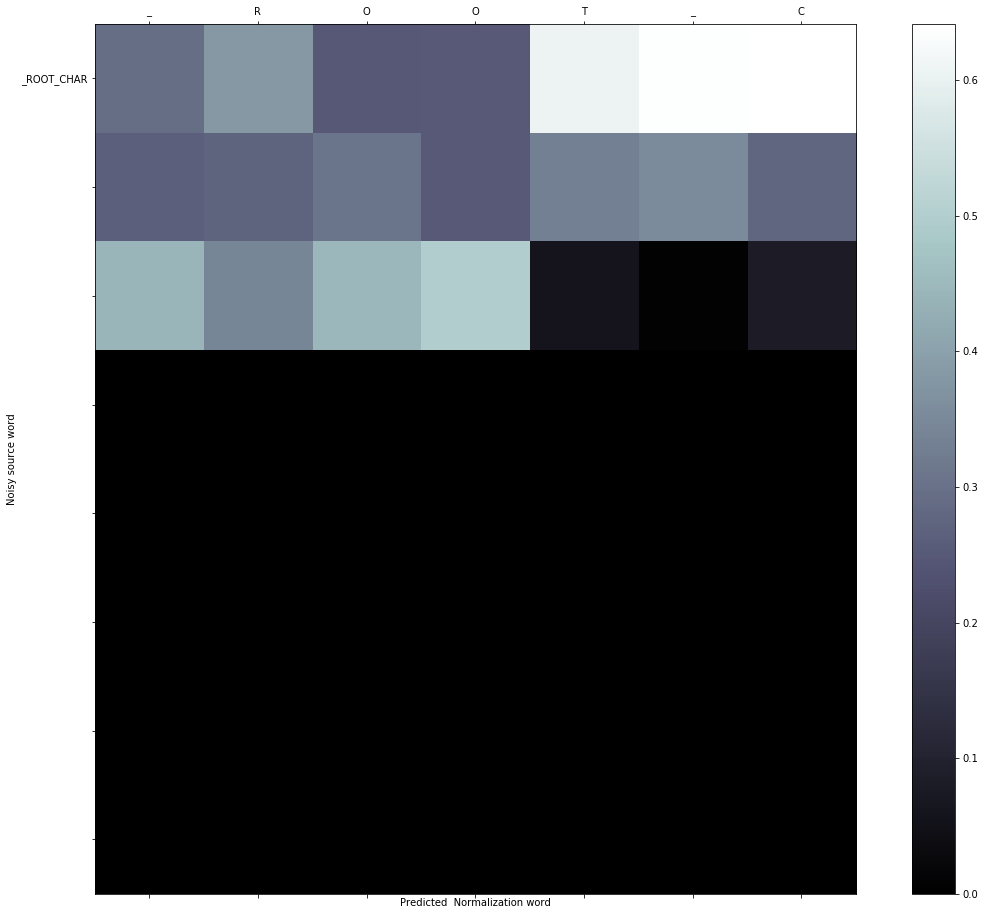

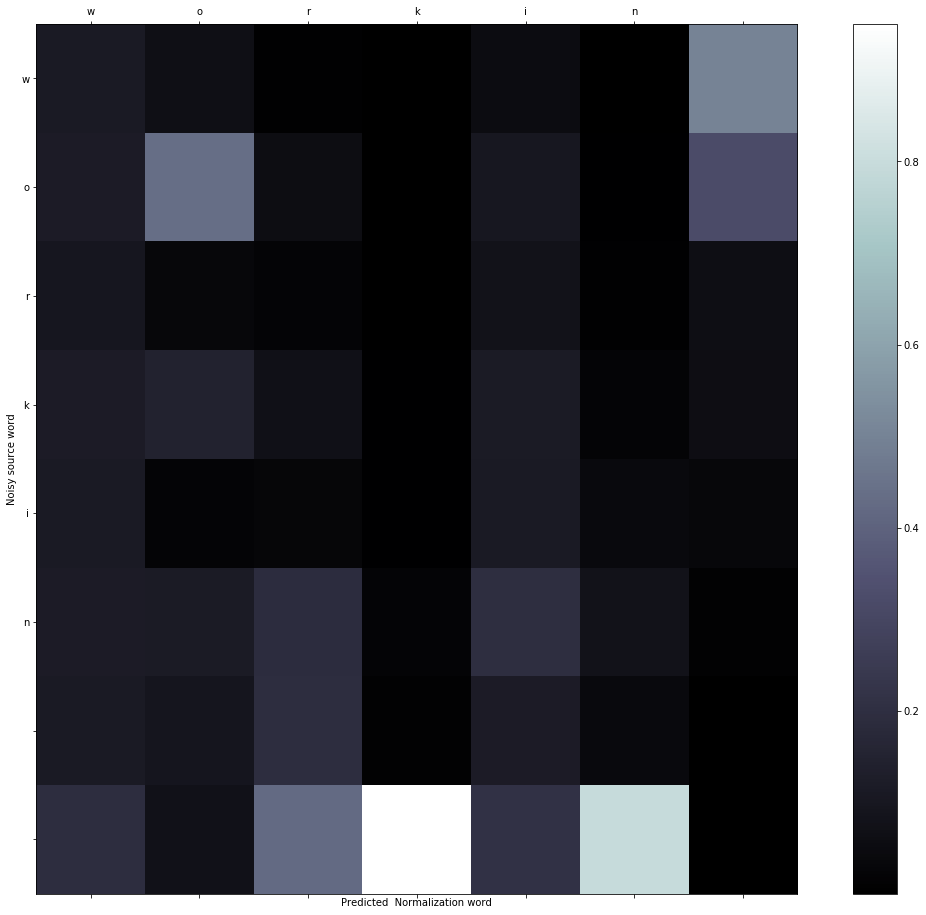

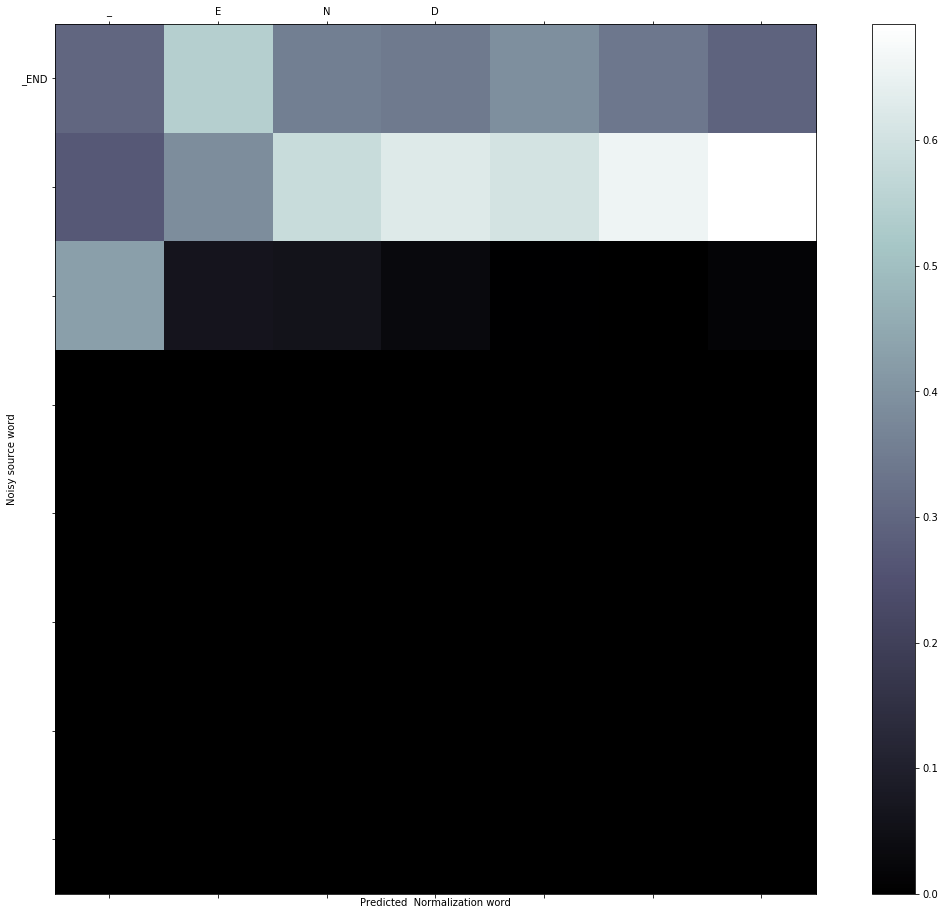

DECODED text is : ['_ROOT_CHAR', 'workin', '_END'] original is ['_ROOT_CHAR', 'workin', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    goin
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['goin']
Attention shape torch.Size([3, 5, 6])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000],
         [ 0.3829,  0.2721,  0.3451,  0.0000,  0.0000,  0.0000],
         [ 0.2494,  0.3069,  0.4436,  0.0000,  0.0000,  0.0000],
         [ 0.2528,  0.2527,  0.4945,  0.0000,  0.0000,  0.0000],
         [ 0.6076,  0.3321,  0.0603,  0.0000,  0.0000,  0.0000]],

        [[ 0.1615,  0.1575,  0.1317,  0.1499,  0.1414,  0.2580],
         [ 0.1150,  0.2560,  0.0460,  0.2330,  0.1980,  0.1520],
         [ 0.0038,  0.0138,  0.0137,  0.1219,  0.1055,  0.7412],
         [ 0.0021,  0.0079,  0.0044,  0.0308,  0.0191,  0.9357],
         [ 0.212

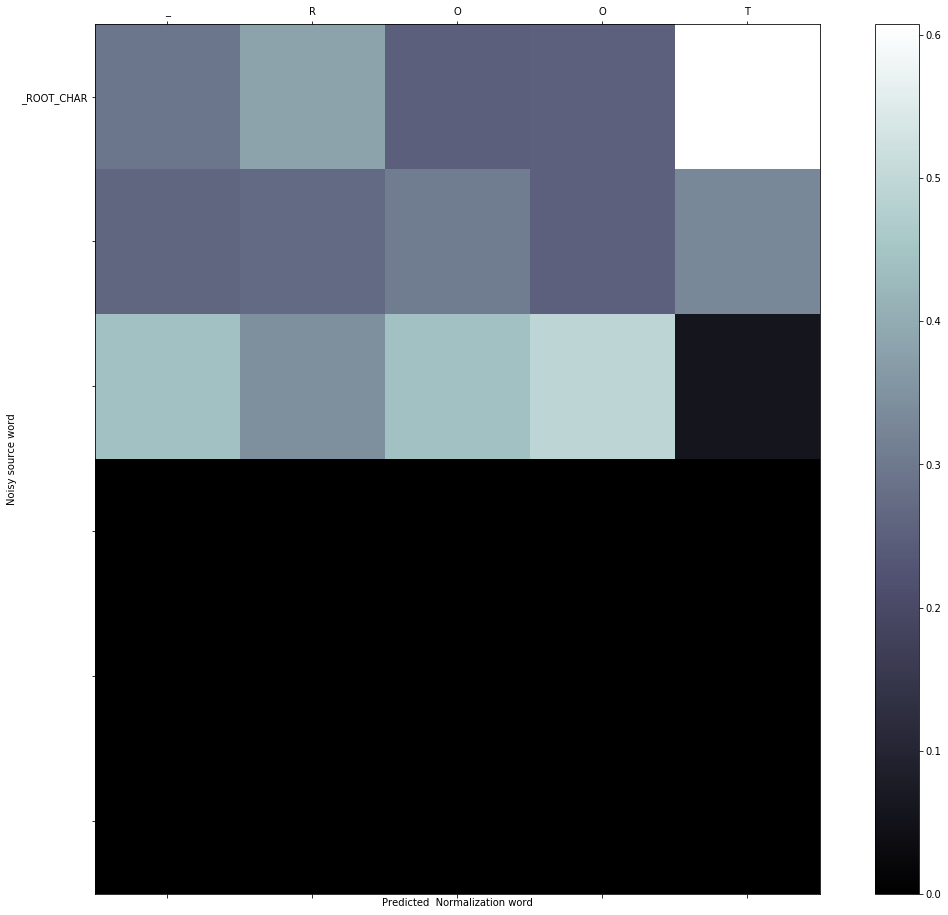

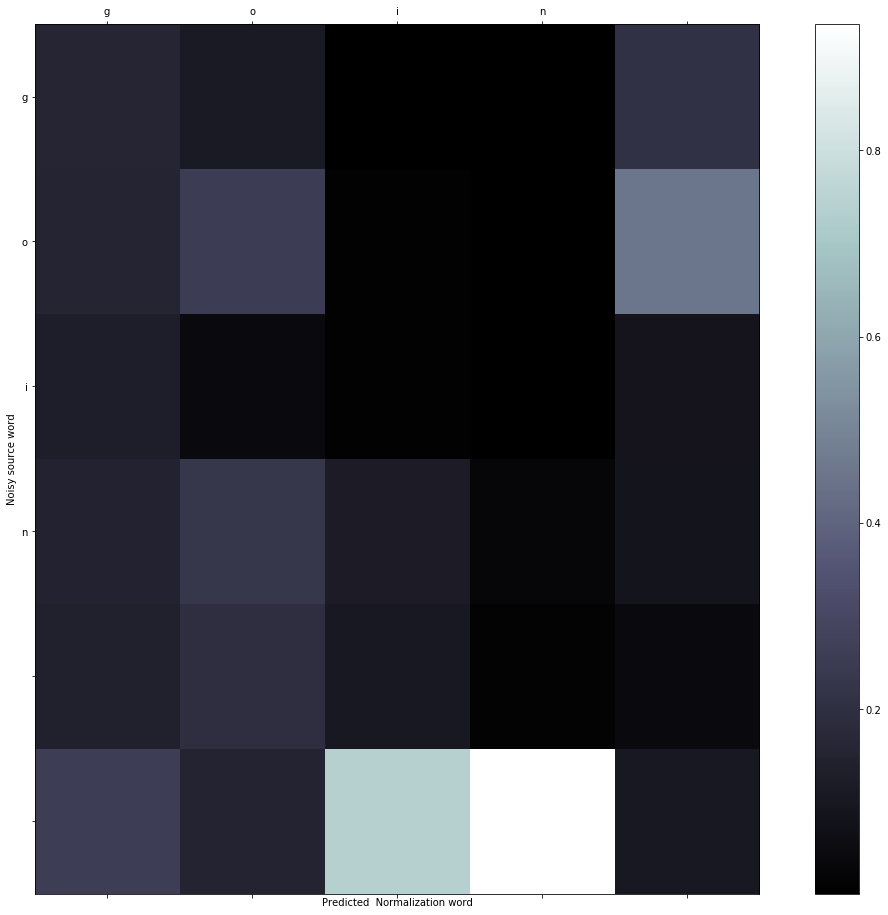

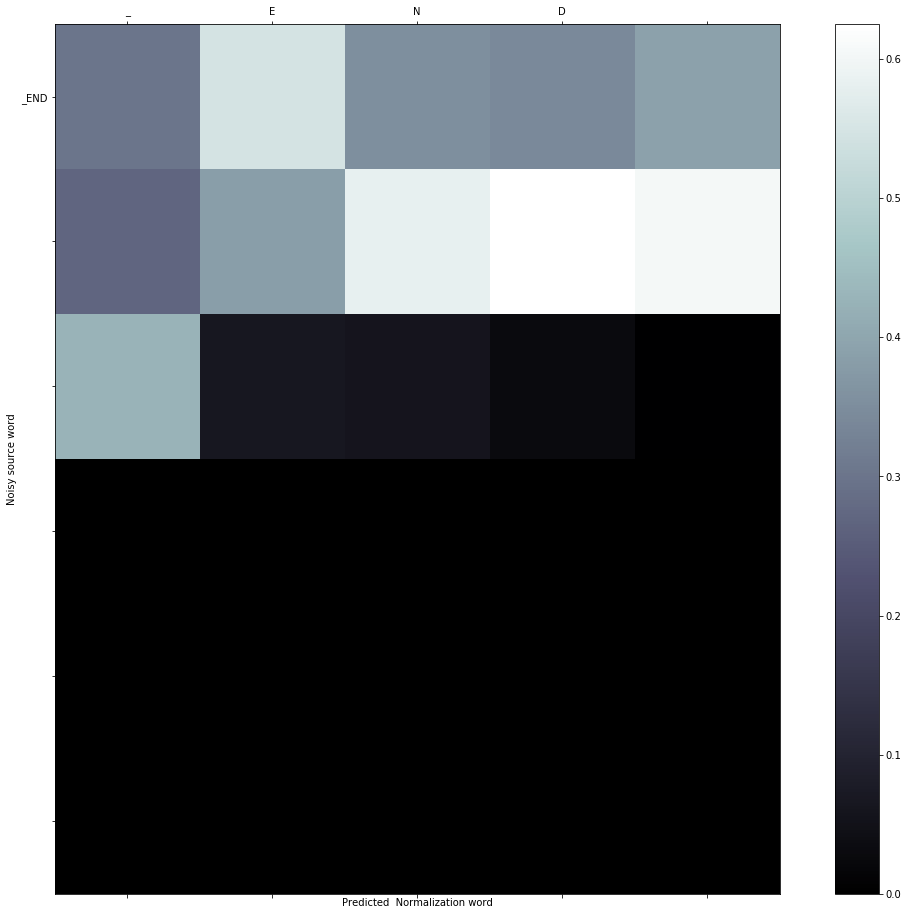

DECODED text is : ['_ROOT_CHAR', 'goin', '_END'] original is ['_ROOT_CHAR', 'goin', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    everything
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['everything']
Attention shape torch.Size([3, 12, 12])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3830,  0.2727,  0.3444,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2499,  0.3077,  0.4424,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2527,  0.2528,  0.4945,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6076,  0.3320,  0.0604,  0.0000,  0.0000,  0.0000,  0.0000,
    

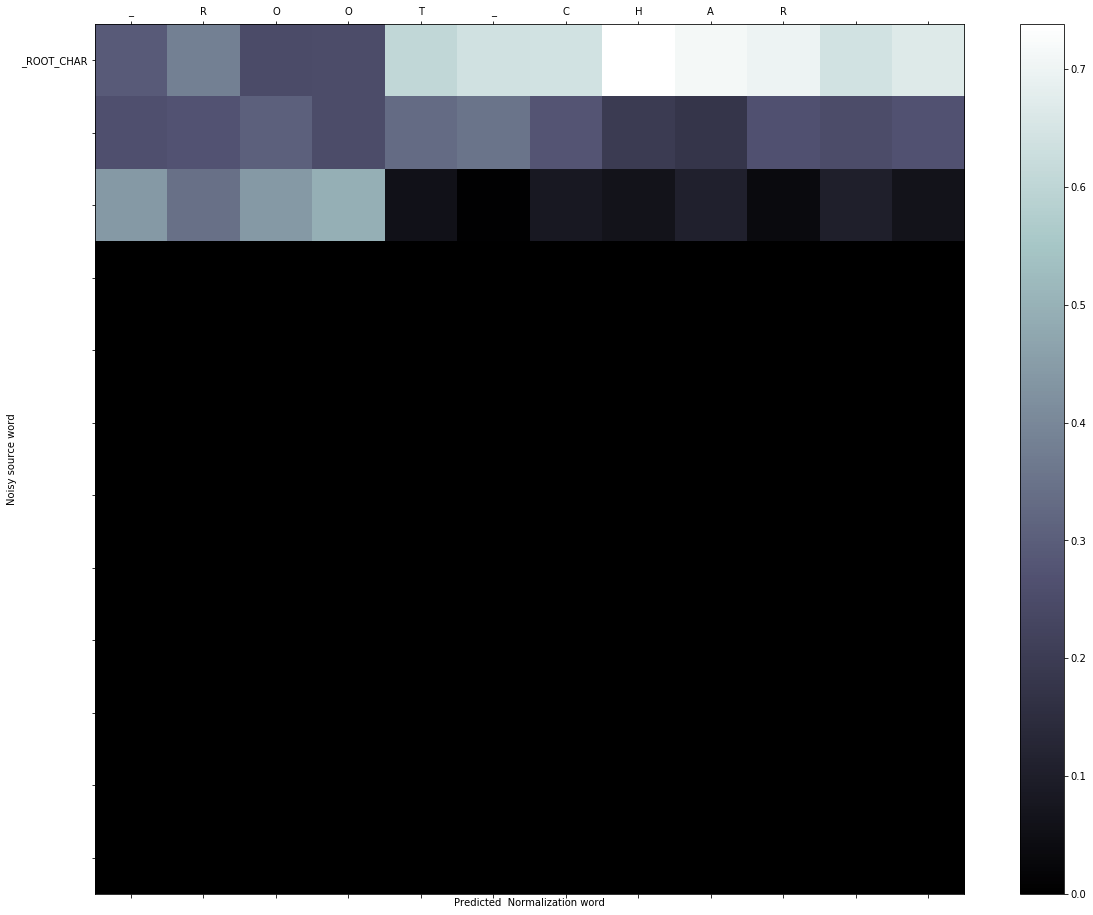

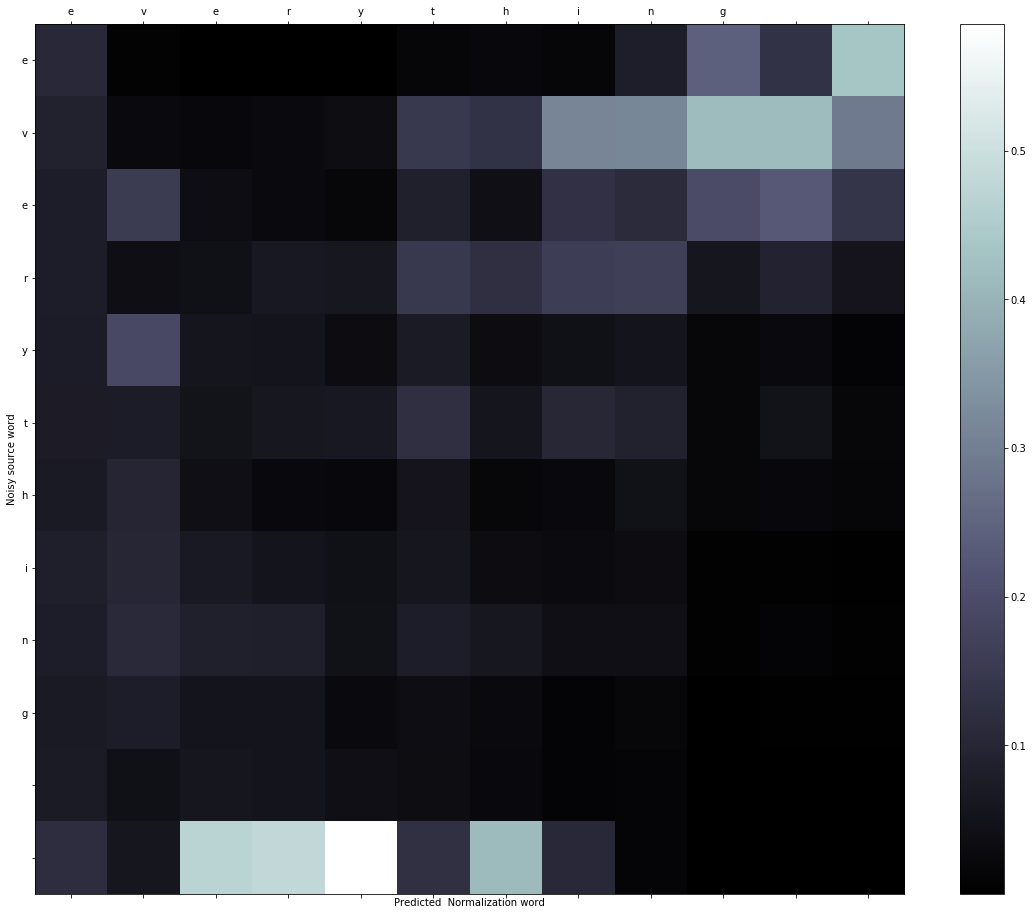

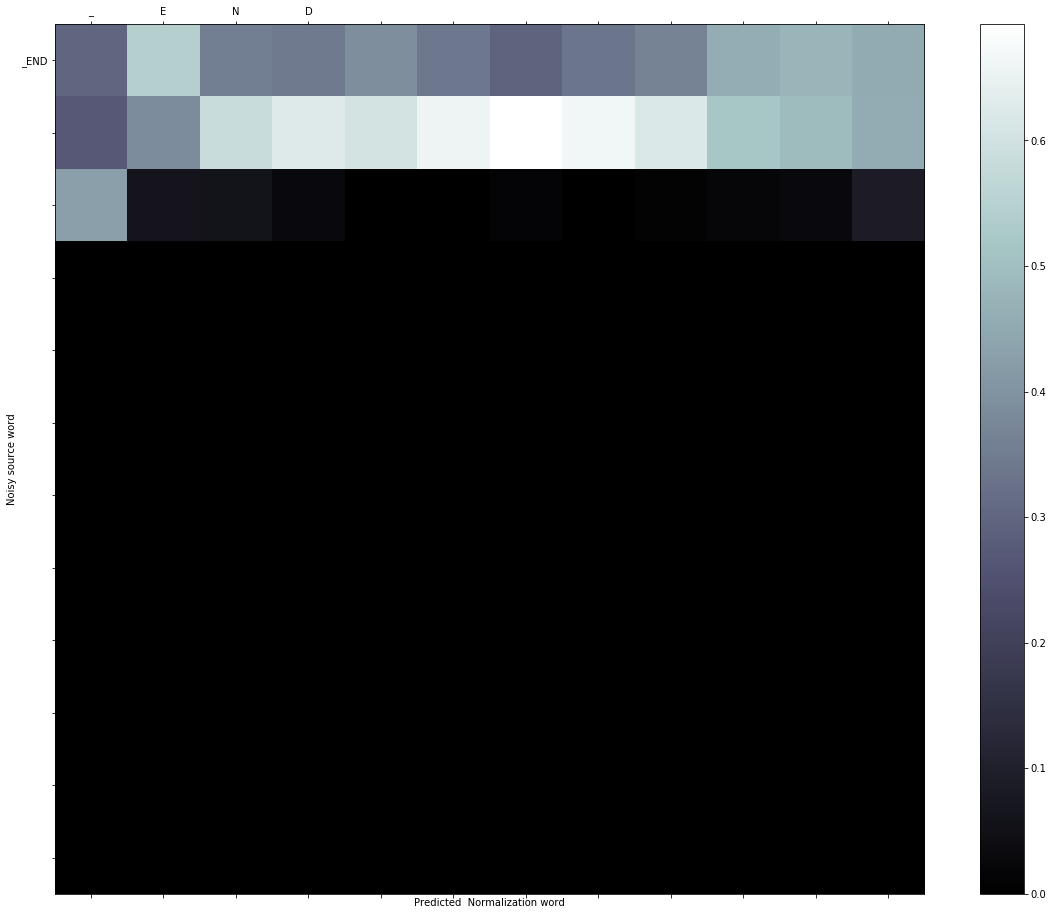

DECODED text is : ['_ROOT_CHAR', 'everything', '_END'] original is ['_ROOT_CHAR', 'everything', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    thts
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['thts']
Attention shape torch.Size([3, 5, 6])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000],
         [ 0.3786,  0.2705,  0.3509,  0.0000,  0.0000,  0.0000],
         [ 0.2434,  0.3022,  0.4544,  0.0000,  0.0000,  0.0000],
         [ 0.2490,  0.2499,  0.5011,  0.0000,  0.0000,  0.0000],
         [ 0.6067,  0.3317,  0.0617,  0.0000,  0.0000,  0.0000]],

        [[ 0.1504,  0.1367,  0.1602,  0.1398,  0.1528,  0.2602],
         [ 0.2032,  0.1731,  0.1721,  0.1331,  0.1243,  0.1942],
         [ 0.0196,  0.0218,  0.0429,  0.0459,  0.1067,  0.7631],
         [ 0.0328,  0.0462,  0.0696,  0.0989,  0.2388,  0.5137],
        

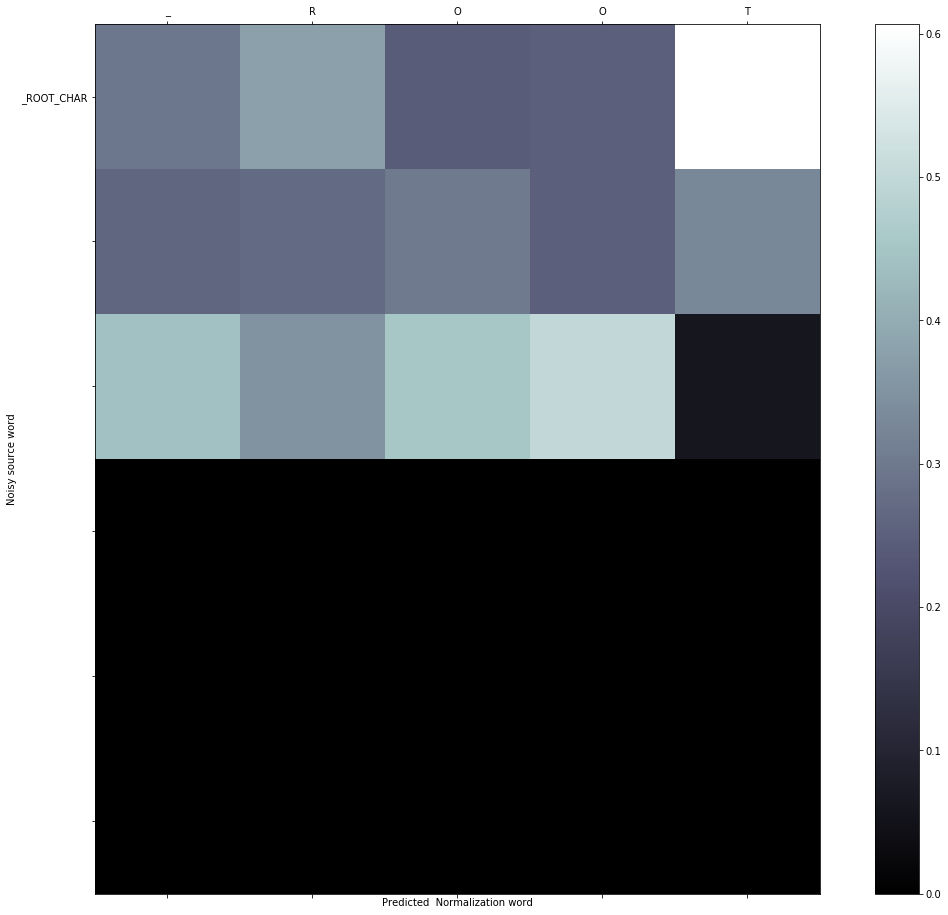

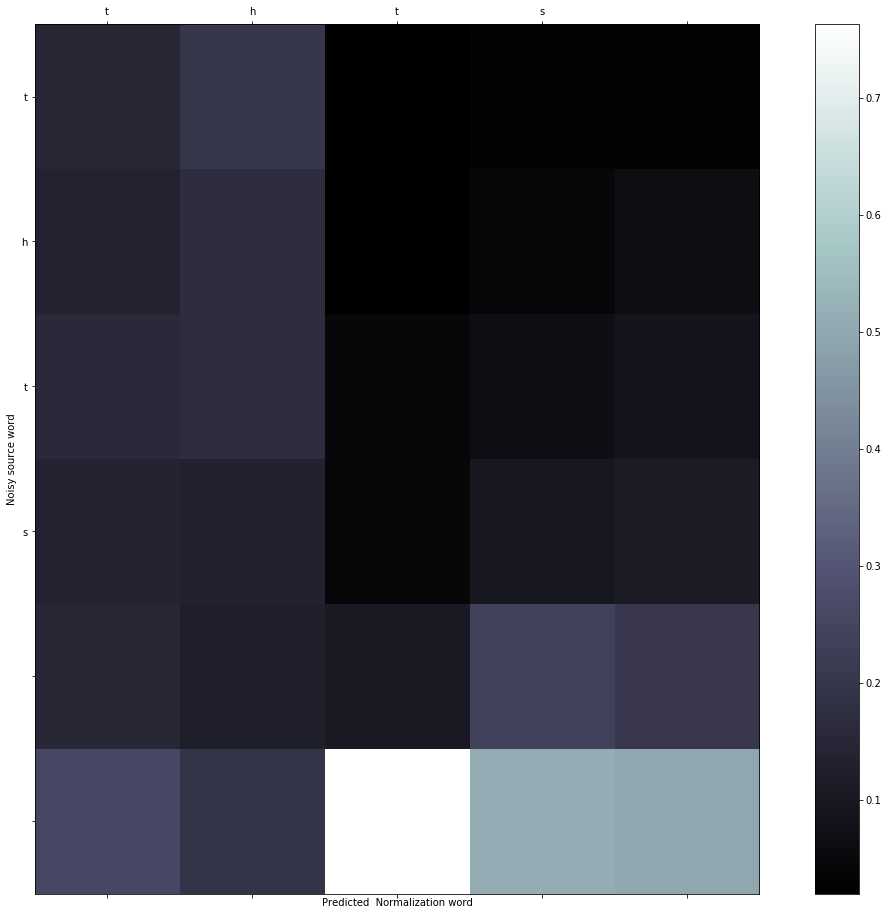

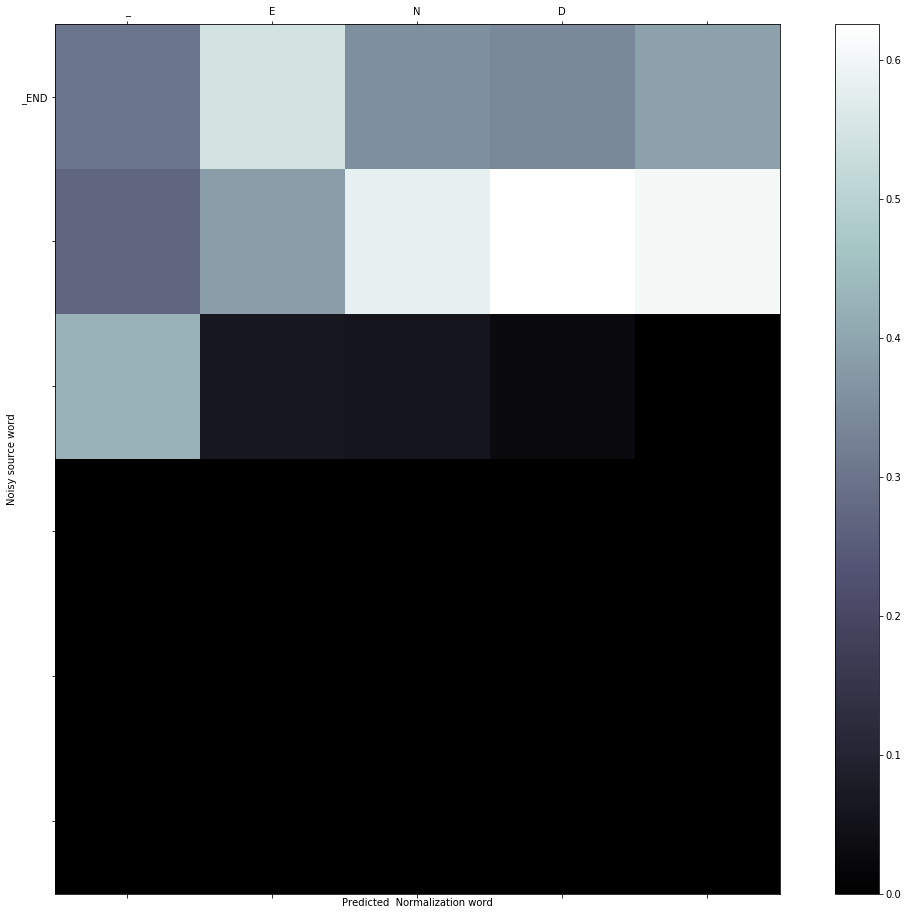

DECODED text is : ['_ROOT_CHAR', 'thts', '_END'] original is ['_ROOT_CHAR', 'thts', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    chillin
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['chillin']
Attention shape torch.Size([3, 9, 9])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.3850,  0.2725,  0.3425,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.2505,  0.3072,  0.4423,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.2532,  0.2526,  0.4942,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.6084,  0.3317,  0.0599,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.6384,  0.3532,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,

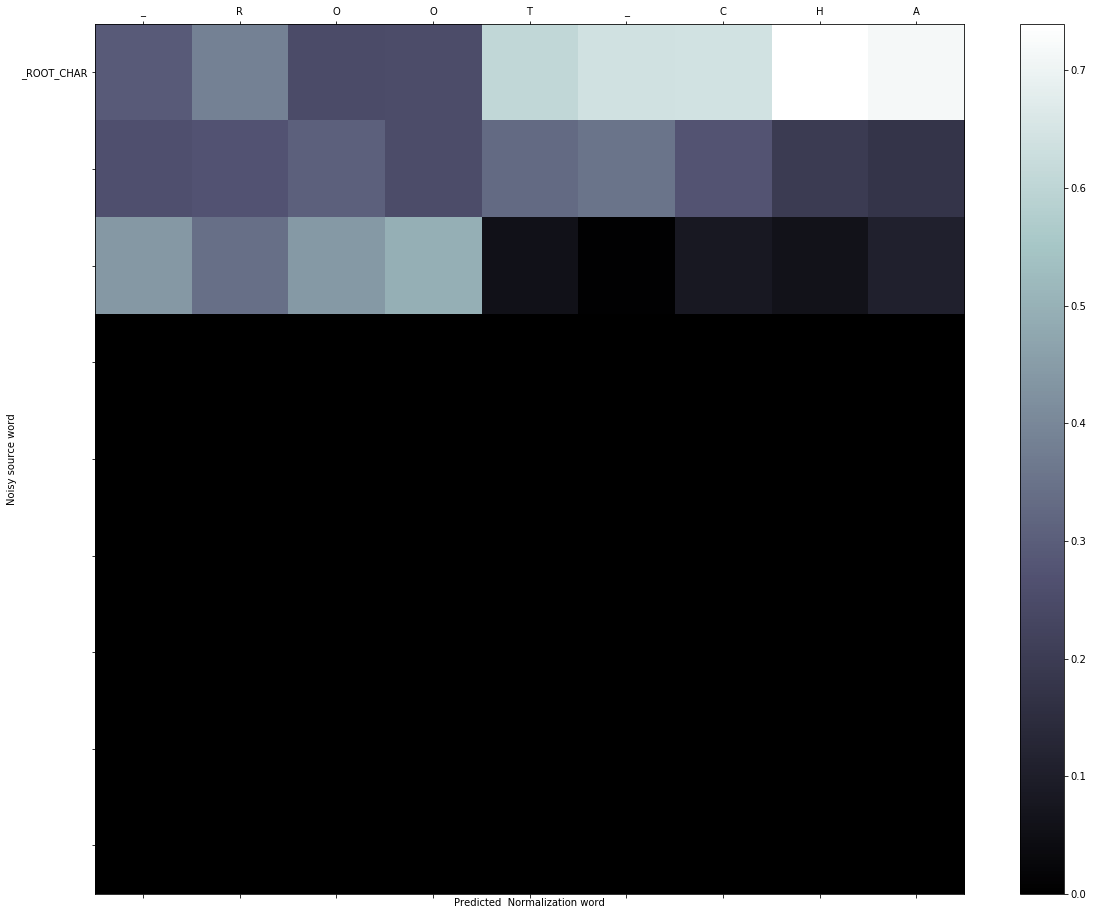

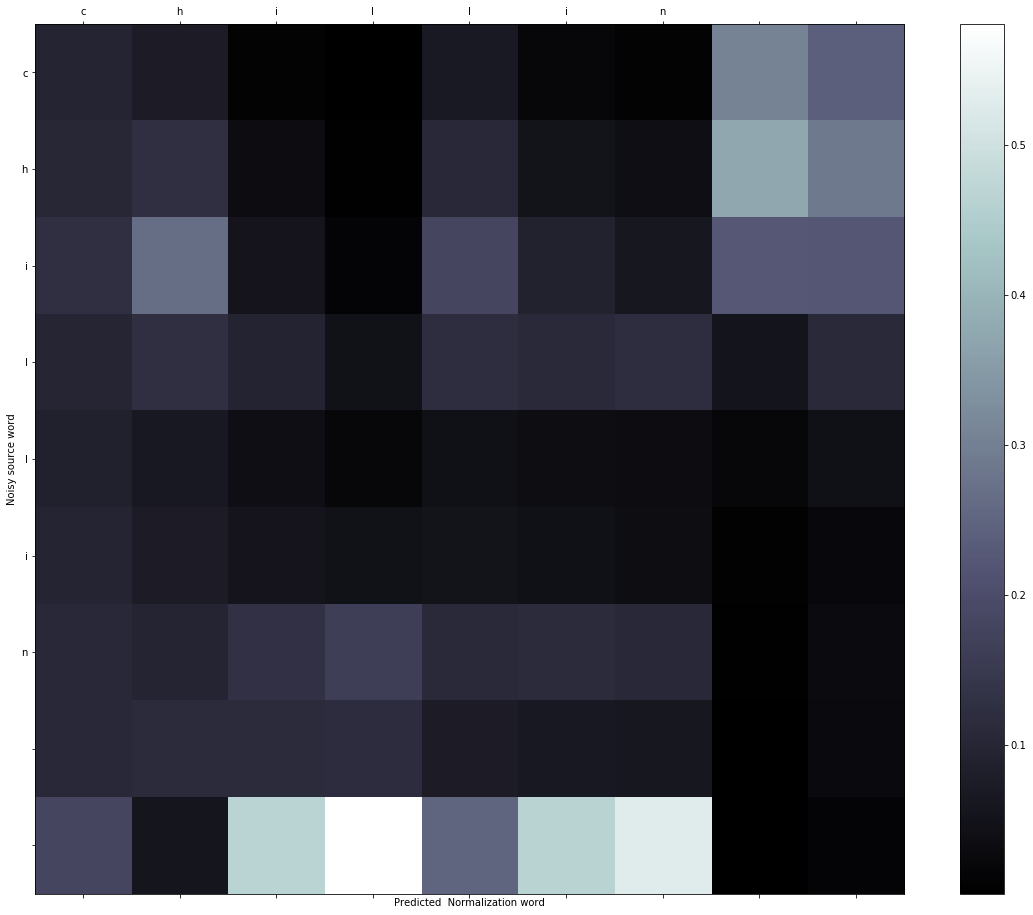

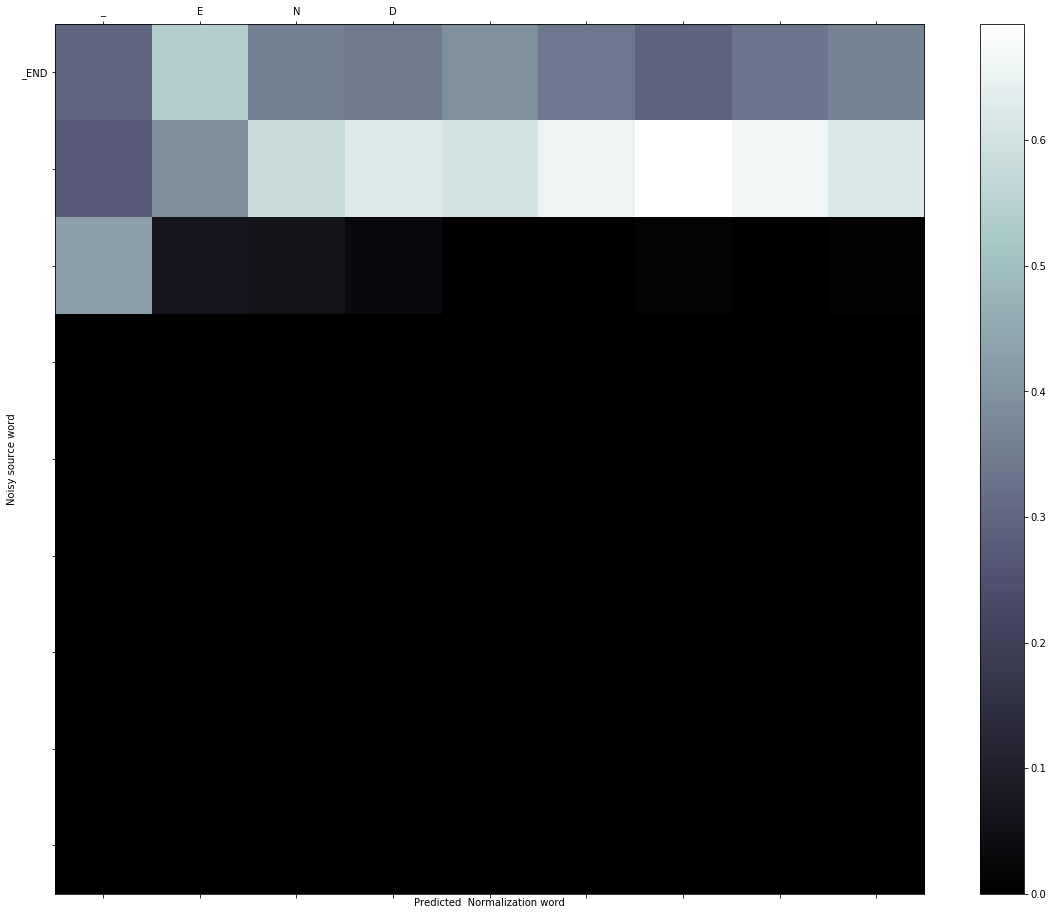

DECODED text is : ['_ROOT_CHAR', 'chillin', '_END'] original is ['_ROOT_CHAR', 'chillin', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    lookin
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['lookin']
Attention shape torch.Size([3, 7, 8])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.3850,  0.2724,  0.3426,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2507,  0.3075,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2540,  0.2531,  0.4929,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6083,  0.3318,  0.0599,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6379,  0.3537,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6402,  0.2776,  0.0821,  0

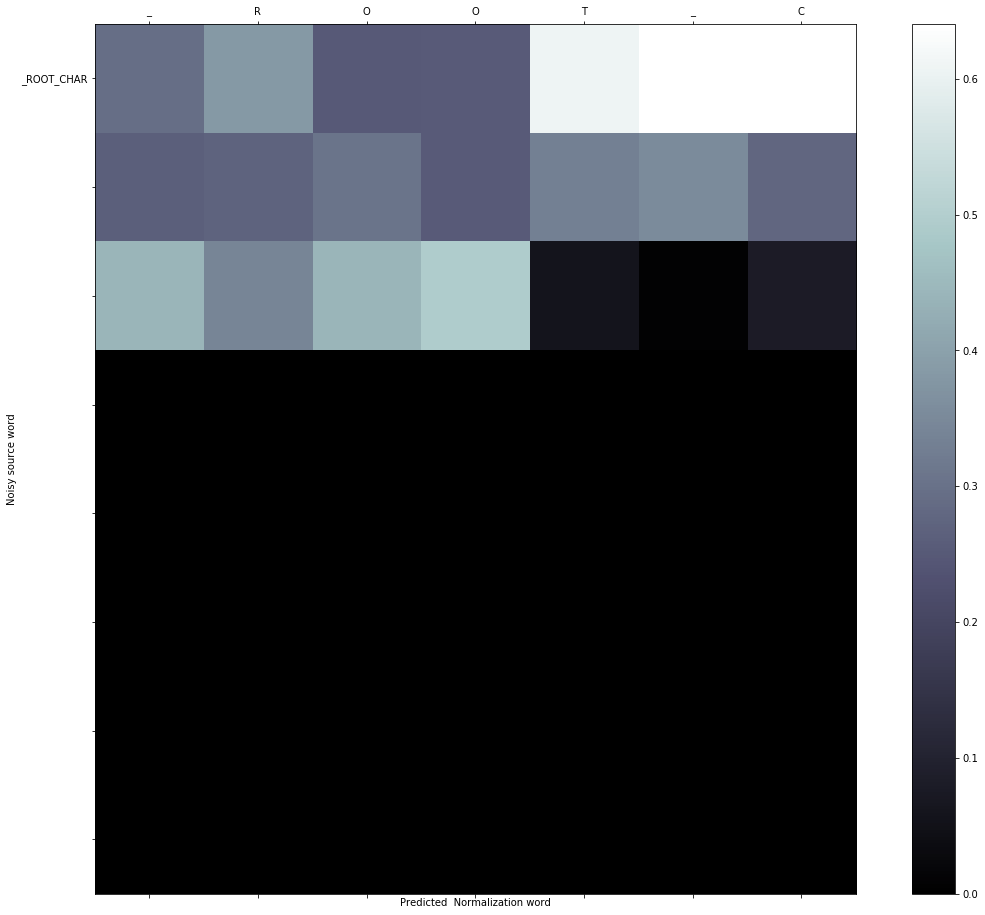

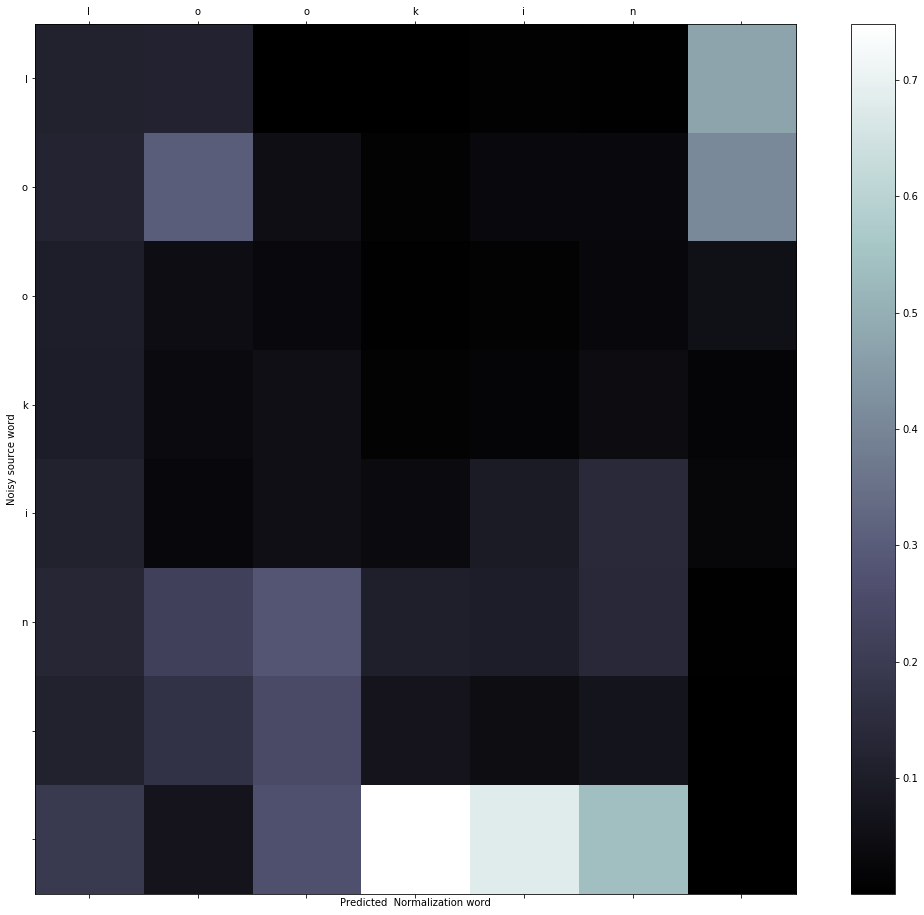

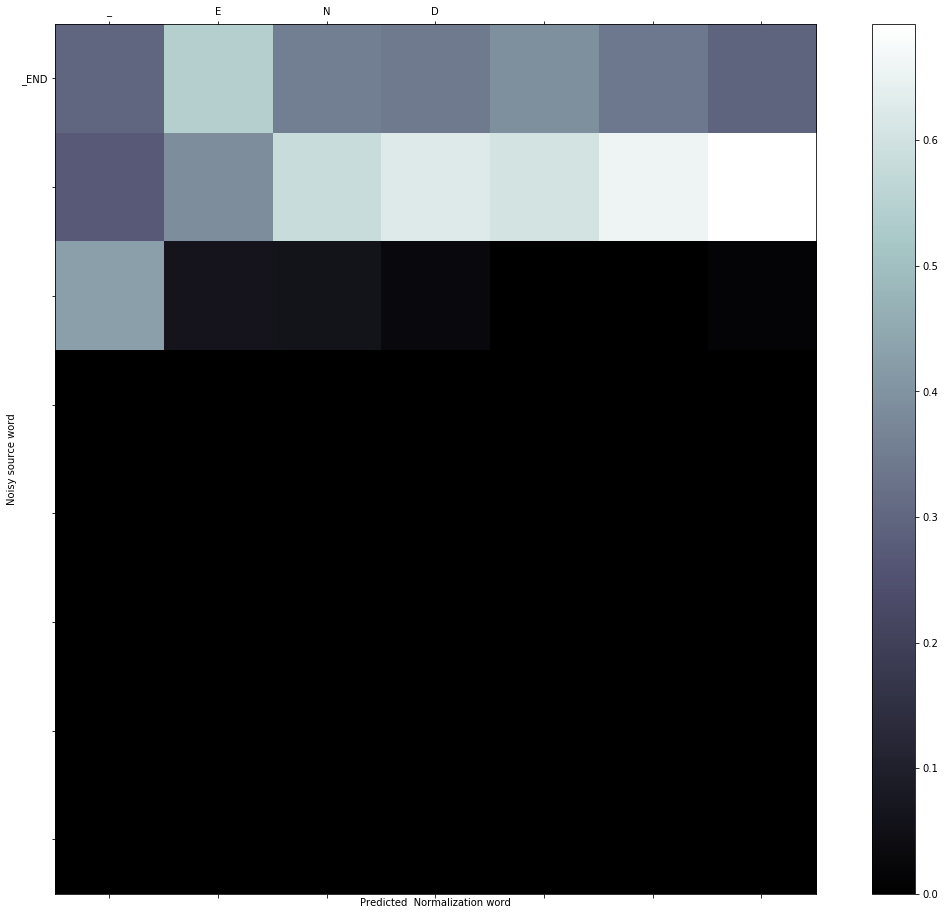

DECODED text is : ['_ROOT_CHAR', 'lookin', '_END'] original is ['_ROOT_CHAR', 'lookin', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    lockd
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['lockd']
Attention shape torch.Size([3, 7, 7])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3850,  0.2723,  0.3428,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2507,  0.3073,  0.4420,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2532,  0.2526,  0.4943,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6081,  0.3320,  0.0599,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6380,  0.3536,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6405,  0.2776,  0.0819,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.1242,  0.1301,  0.1101,  0.1209,  0.1329,  0.1400,  0.2418],
       

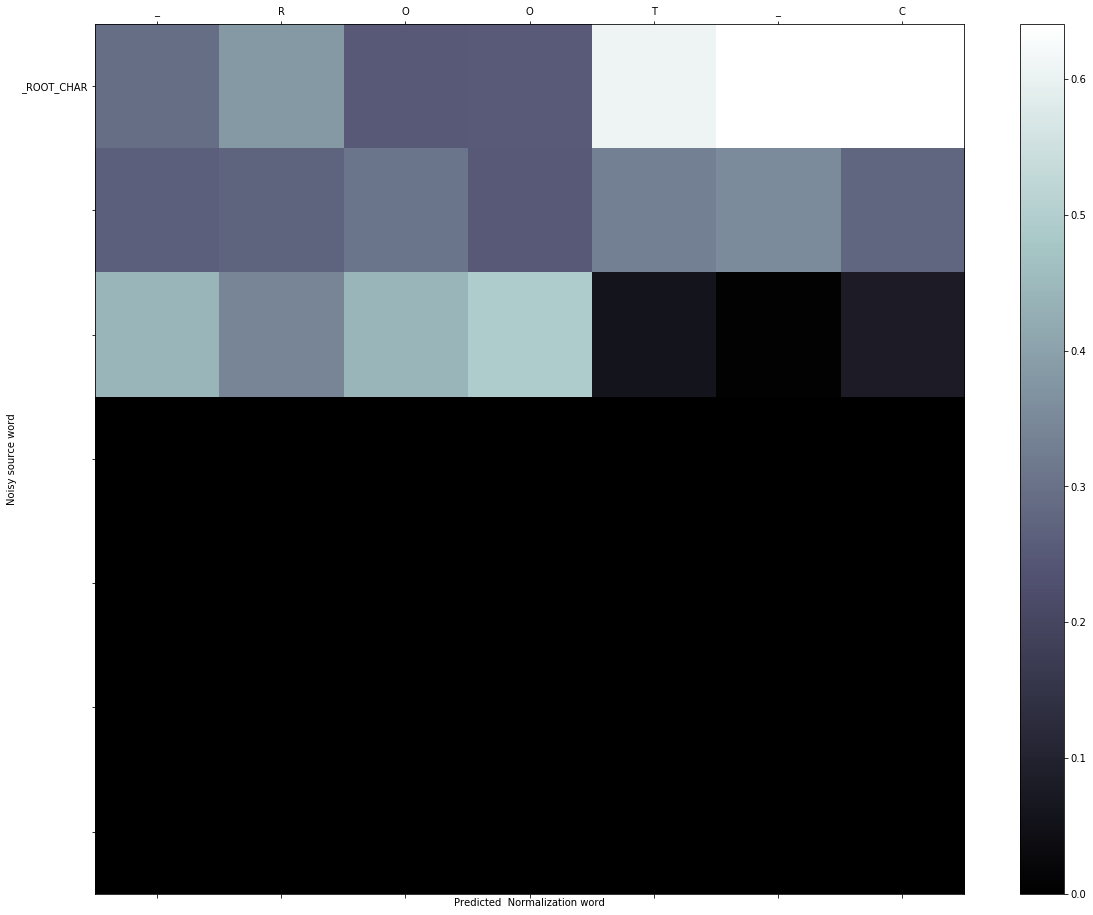

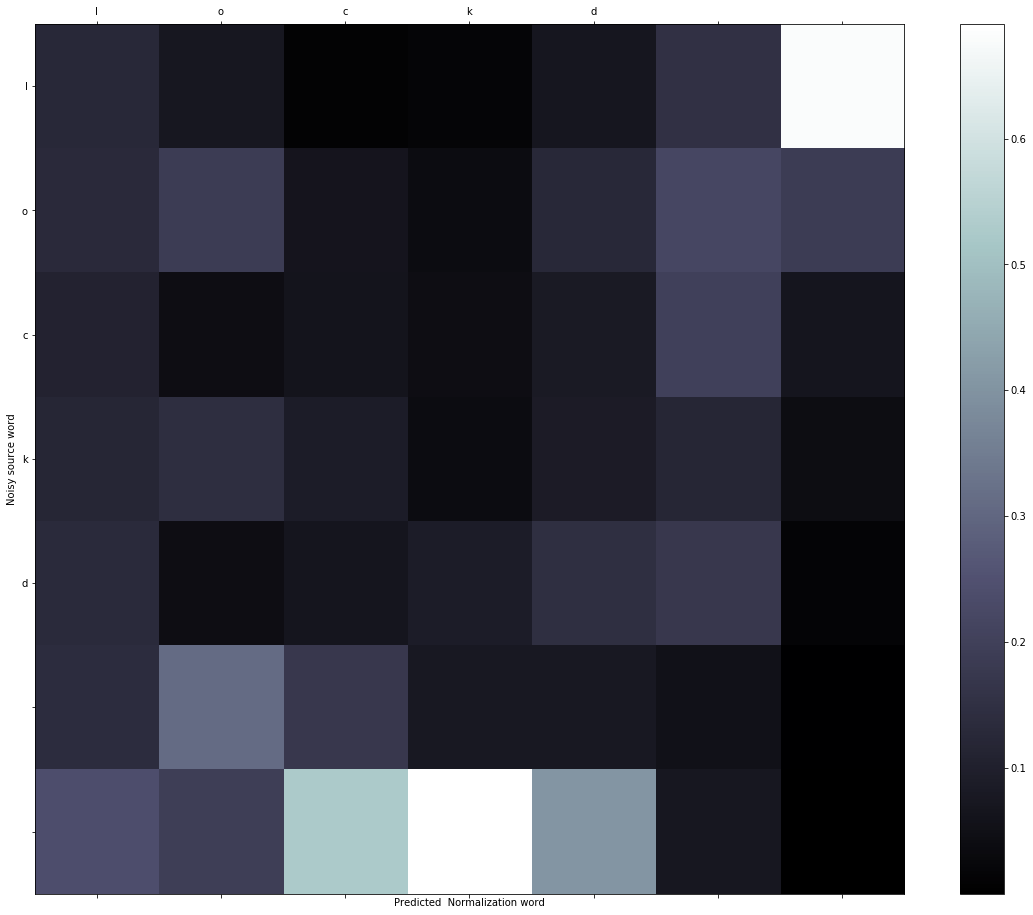

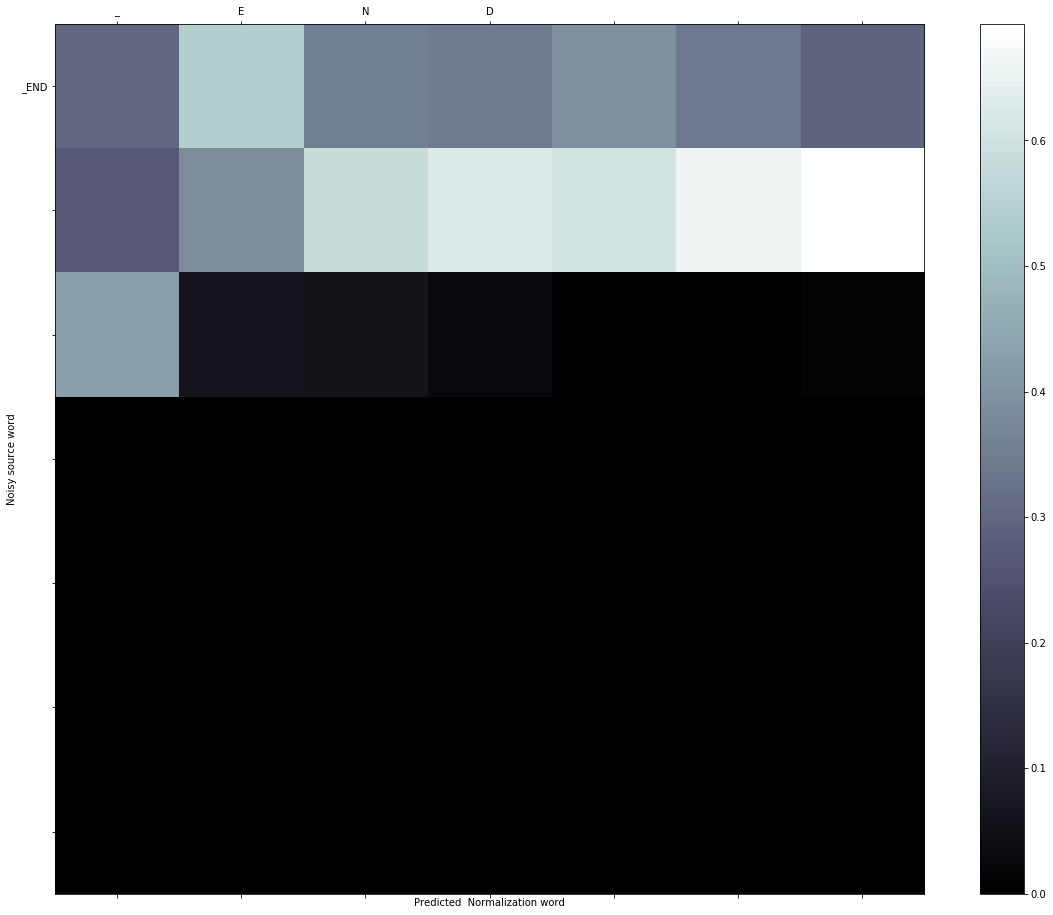

DECODED text is : ['_ROOT_CHAR', 'lockd', '_END'] original is ['_ROOT_CHAR', 'lockd', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    hereee
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['hereee']
Attention shape torch.Size([3, 7, 8])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.3815,  0.2717,  0.3468,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2483,  0.3061,  0.4456,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2518,  0.2518,  0.4965,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6077,  0.3317,  0.0606,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6380,  0.3535,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6410,  0.2767,  0.0823,  0.000

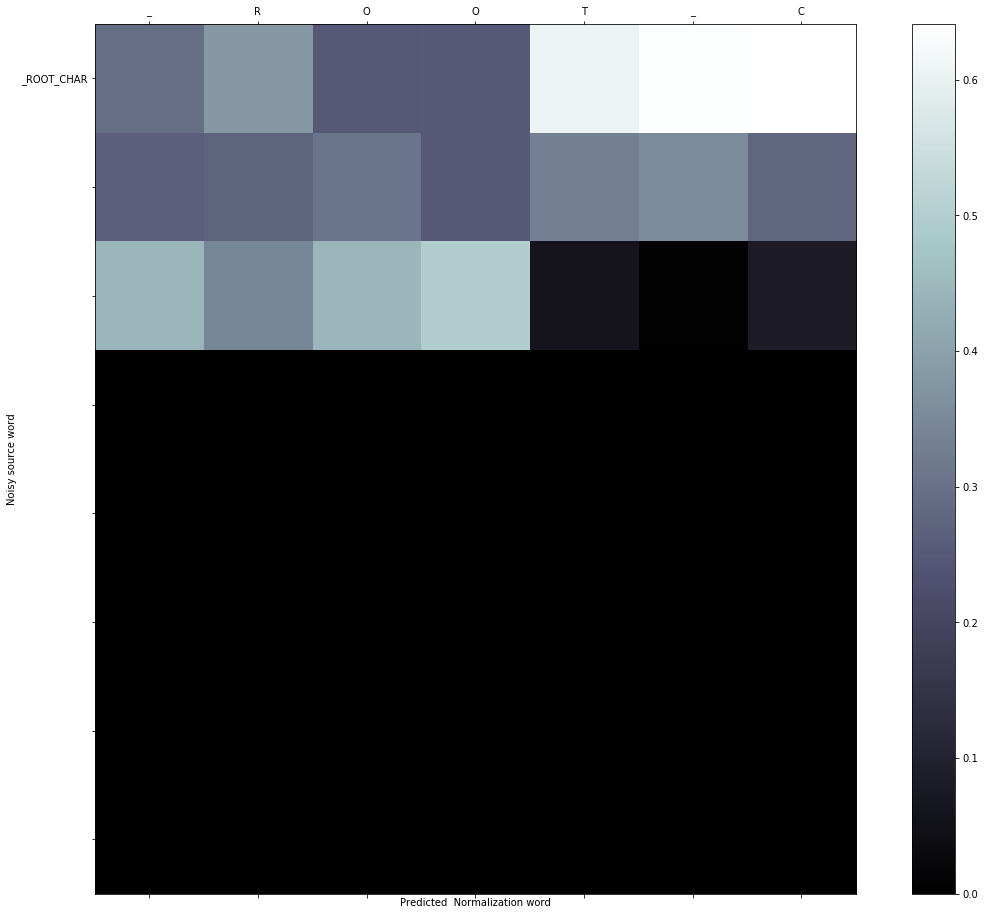

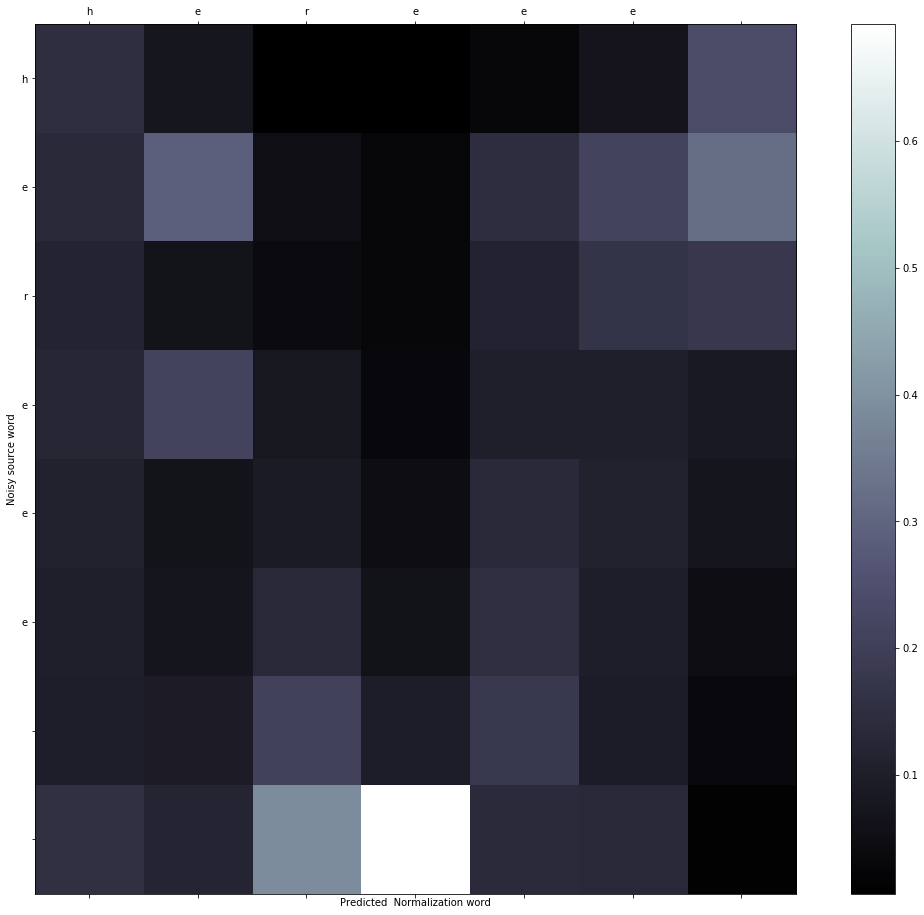

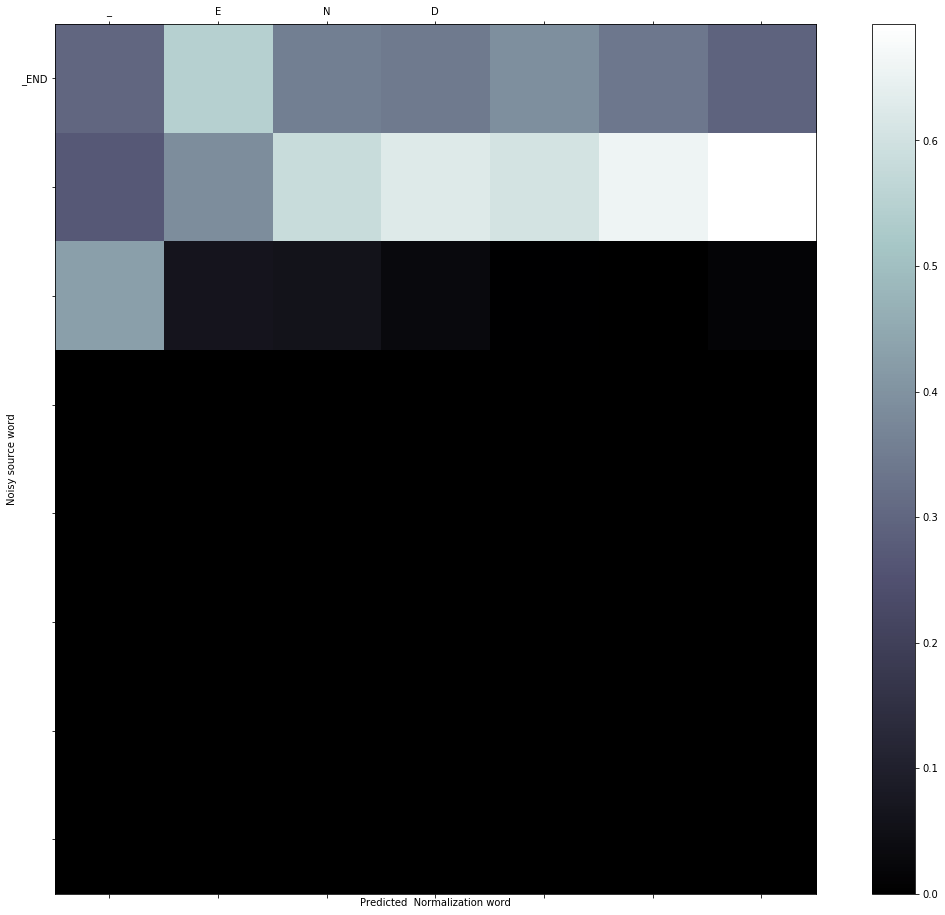

DECODED text is : ['_ROOT_CHAR', 'hereee', '_END'] original is ['_ROOT_CHAR', 'hereee', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    aaaaaaaah
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['aaaaaaaah']
Attention shape torch.Size([3, 12, 11])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3882,  0.2743,  0.3375,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2551,  0.3124,  0.4325,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2601,  0.2581,  0.4819,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6098,  0.3323,  0.0579,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  

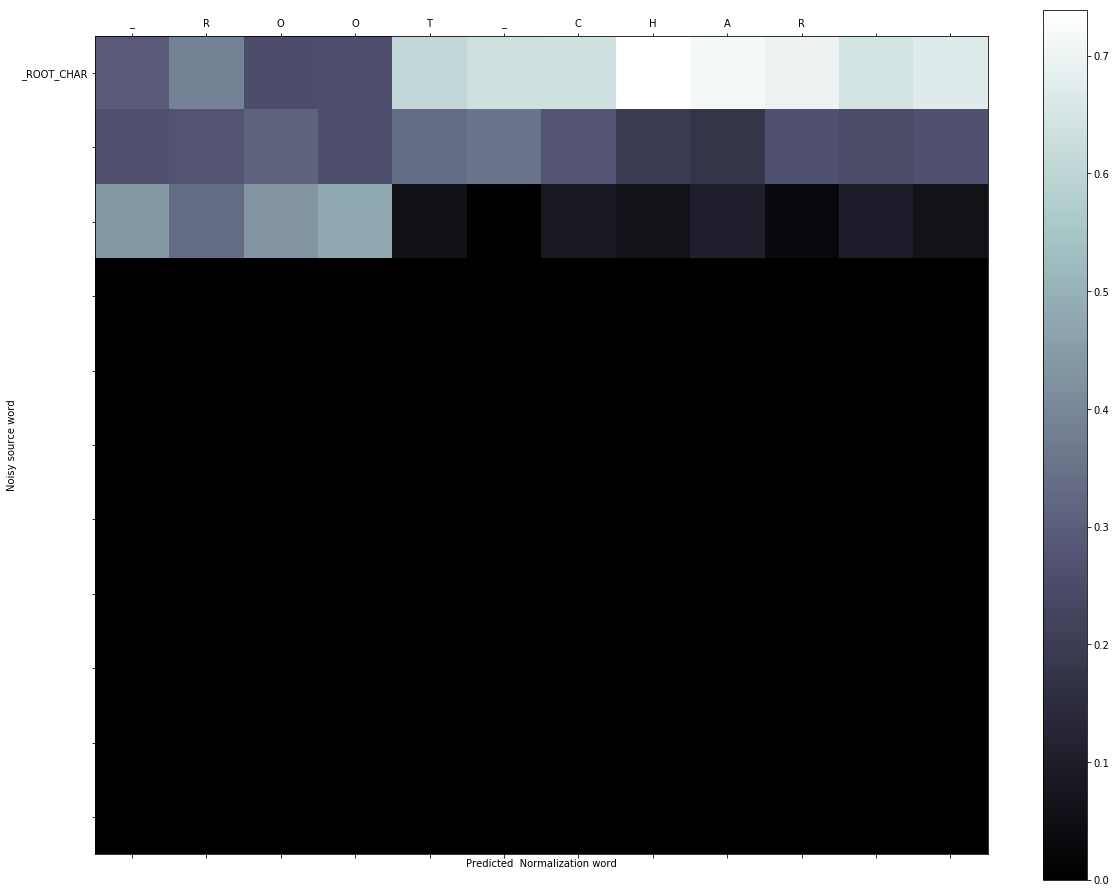

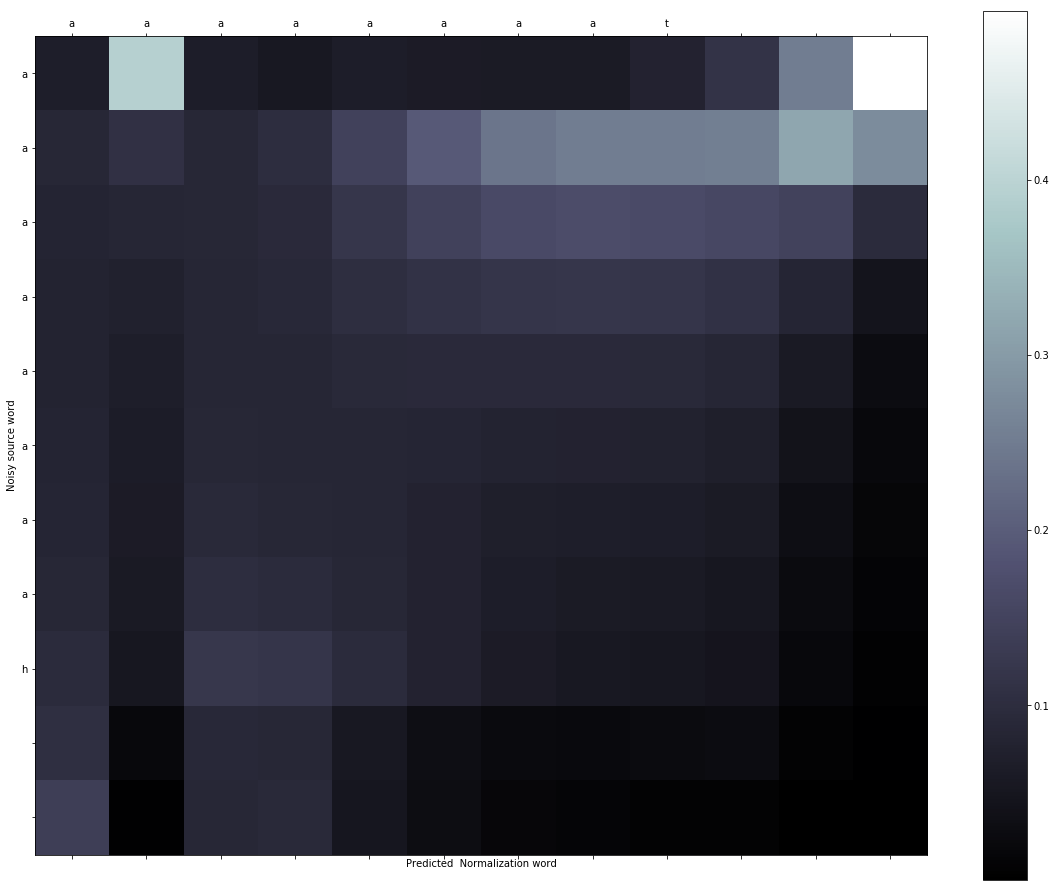

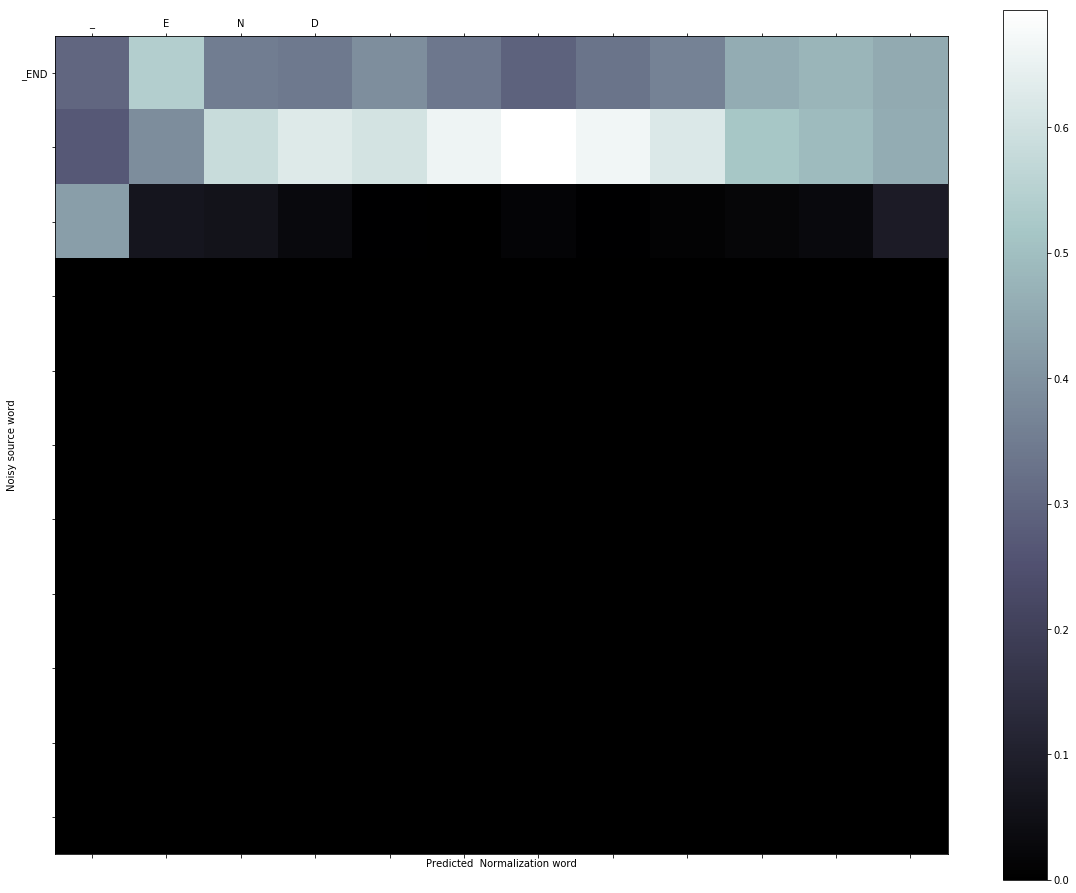

DECODED text is : ['_ROOT_CHAR', 'aaaaaaaat', '_END'] original is ['_ROOT_CHAR', 'aaaaaaaah', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    wgt
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['wgt']
Attention shape torch.Size([3, 5, 5])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000],
         [ 0.3805,  0.2710,  0.3485,  0.0000,  0.0000],
         [ 0.2463,  0.3040,  0.4497,  0.0000,  0.0000],
         [ 0.2499,  0.2505,  0.4997,  0.0000,  0.0000],
         [ 0.6069,  0.3319,  0.0611,  0.0000,  0.0000]],

        [[ 0.1660,  0.1724,  0.1665,  0.1774,  0.3177],
         [ 0.0918,  0.2676,  0.1303,  0.2069,  0.3033],
         [ 0.0282,  0.0552,  0.0763,  0.1263,  0.7140],
         [ 0.0467,  0.0465,  0.0752,  0.0910,  0.7406],
         [ 0.1670,  0.1428,  0.2153,  0.1912,  0.2837]],

        [[ 0.3018,  0.2705,  0.4277

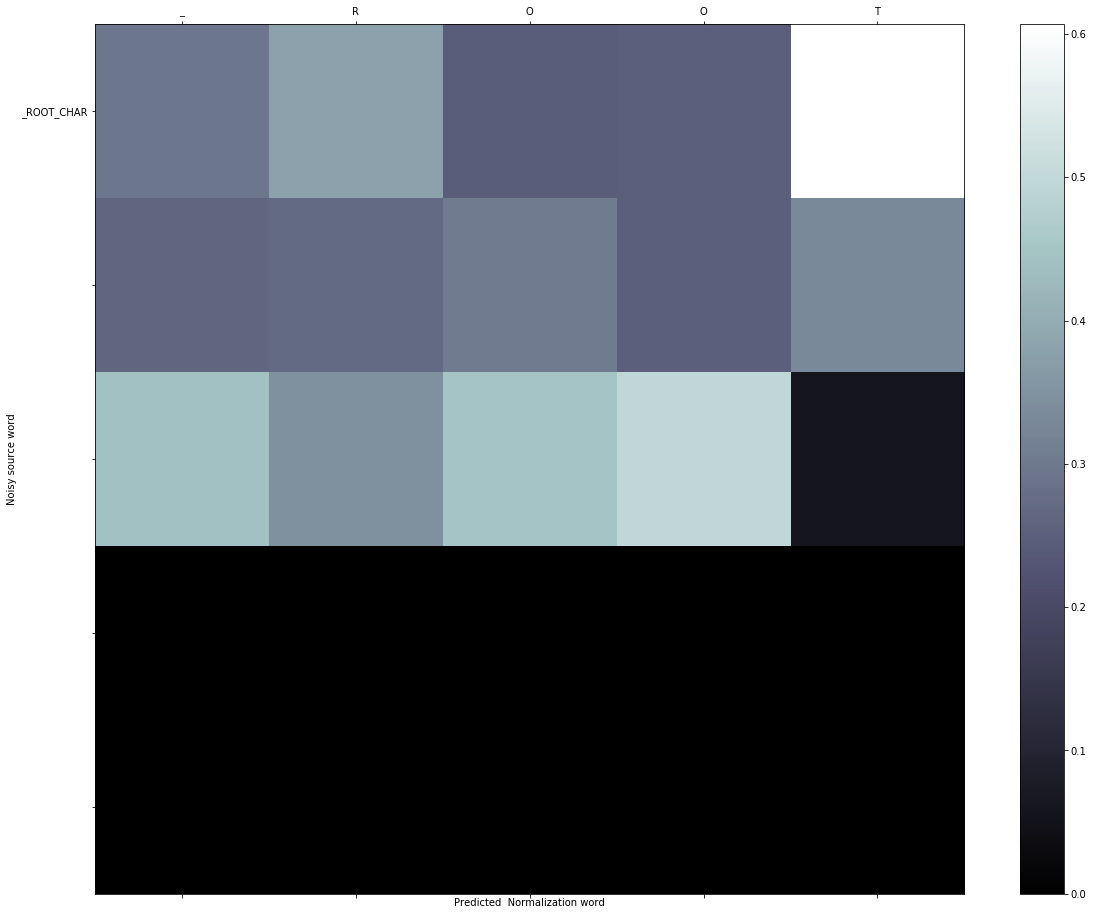

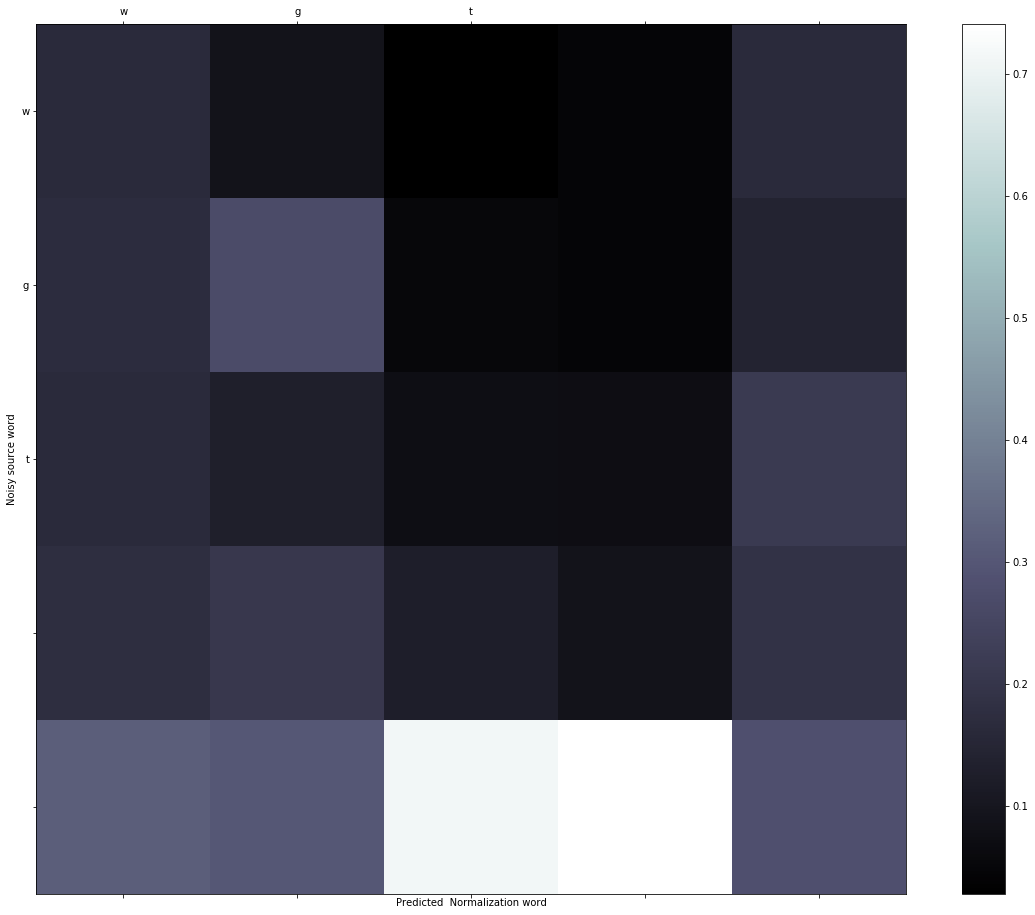

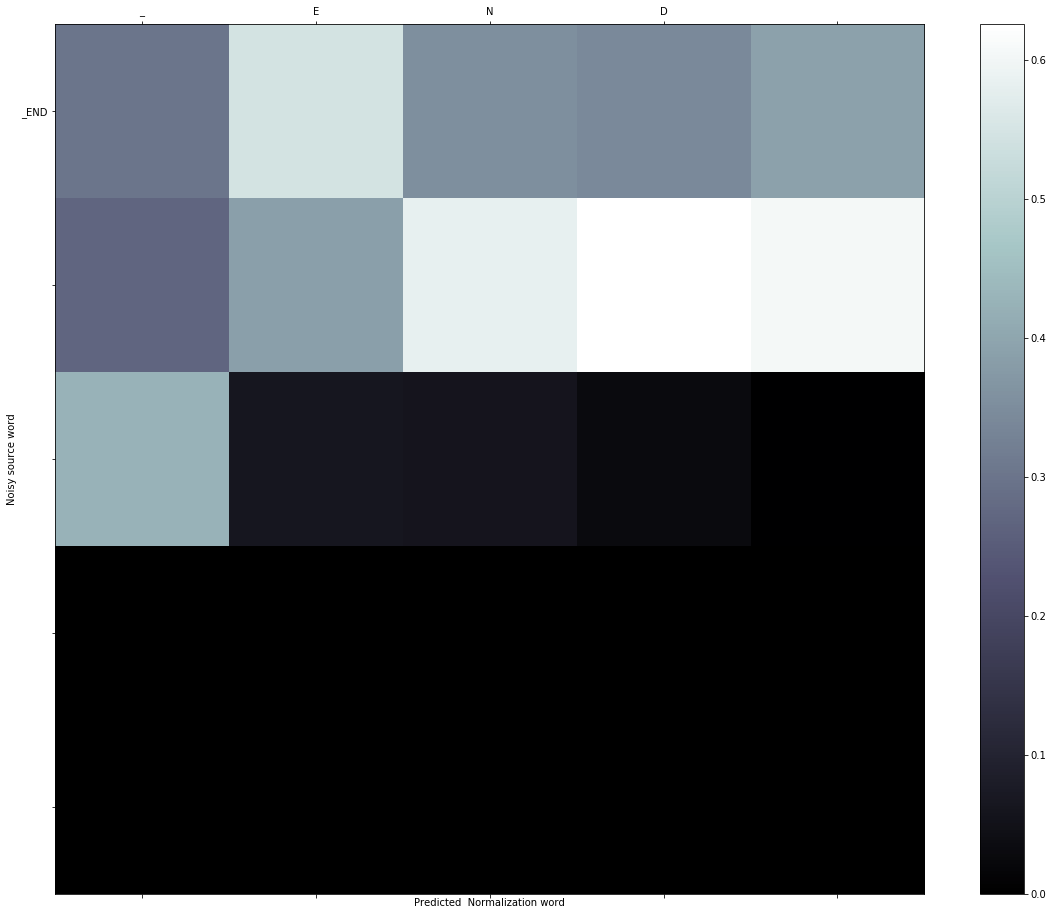

DECODED text is : ['_ROOT_CHAR', 'wgt', '_END'] original is ['_ROOT_CHAR', 'wgt', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    2
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['2']
Attention shape torch.Size([3, 2, 3])
Attention tensor([[[ 0.2941,  0.2641,  0.4418],
         [ 0.3812,  0.2712,  0.3476]],

        [[ 0.2665,  0.2484,  0.4851],
         [ 0.4060,  0.2852,  0.3087]],

        [[ 0.3018,  0.2705,  0.4277],
         [ 0.5479,  0.3859,  0.0662]]]) [['_ROOT_CHAR'], ['2'], ['_END']] ['_ROOT_CHAR', '2', '_END']


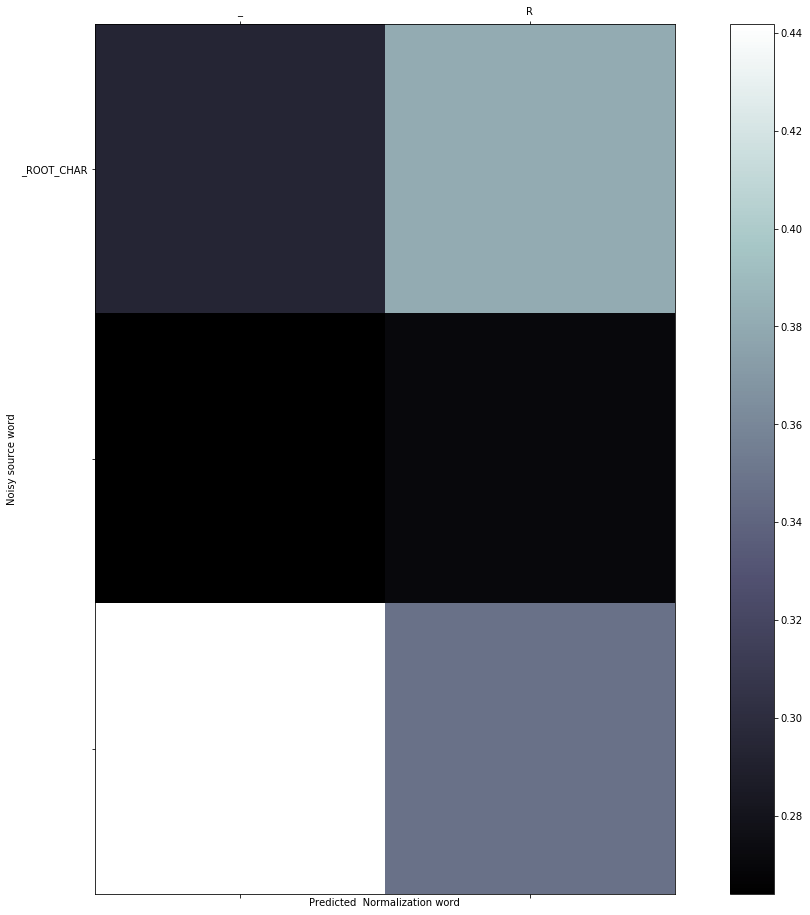

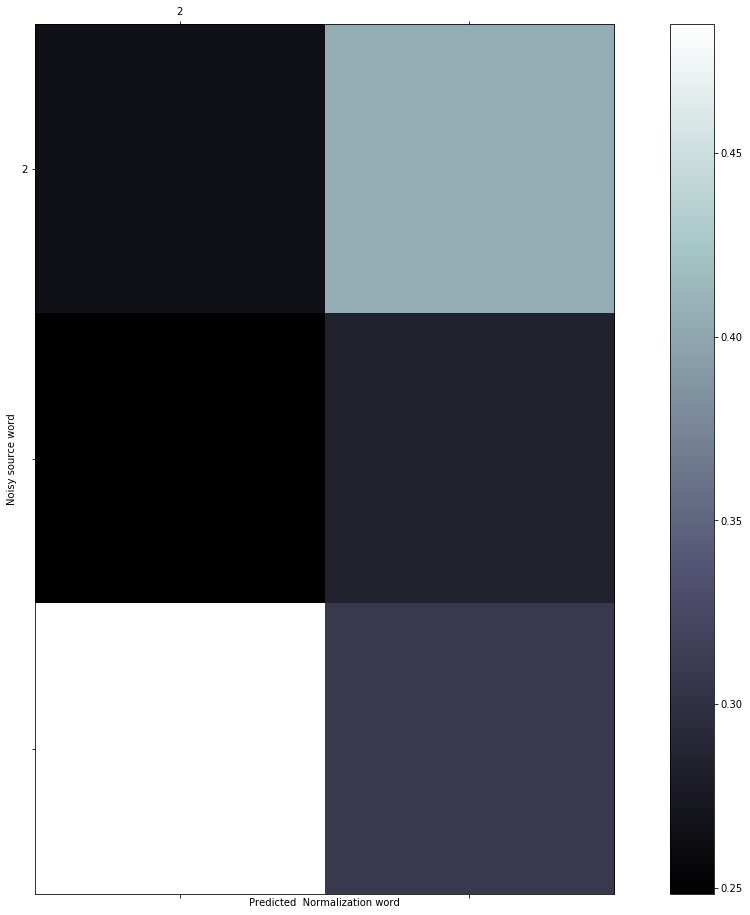

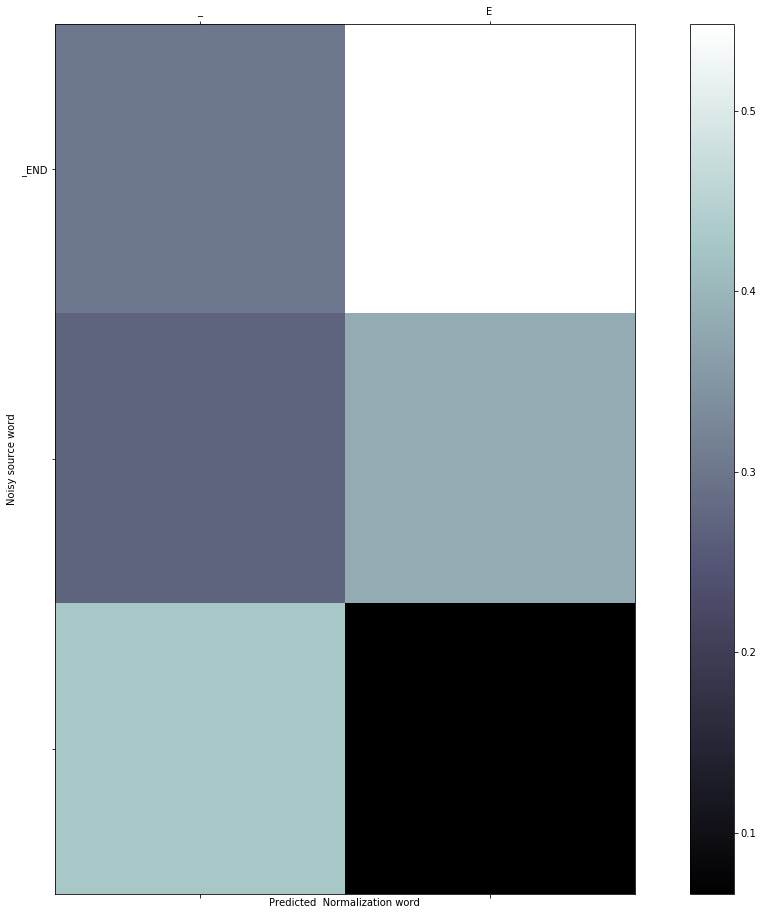

DECODED text is : ['_ROOT_CHAR', '2', '_END'] original is ['_ROOT_CHAR', '2', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    bout
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['bout']
Attention shape torch.Size([3, 5, 6])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000],
         [ 0.3823,  0.2716,  0.3461,  0.0000,  0.0000,  0.0000],
         [ 0.2477,  0.3056,  0.4467,  0.0000,  0.0000,  0.0000],
         [ 0.2530,  0.2526,  0.4944,  0.0000,  0.0000,  0.0000],
         [ 0.6079,  0.3319,  0.0602,  0.0000,  0.0000,  0.0000]],

        [[ 0.1485,  0.1641,  0.1320,  0.1491,  0.1451,  0.2612],
         [ 0.1093,  0.3315,  0.0582,  0.1165,  0.1298,  0.2547],
         [ 0.0289,  0.1264,  0.0589,  0.1307,  0.1236,  0.5315],
         [ 0.0009,  0.0042,  0.0022,  0.0133,  0.0038,  0.9756],
         [ 0.0402,  0.1162

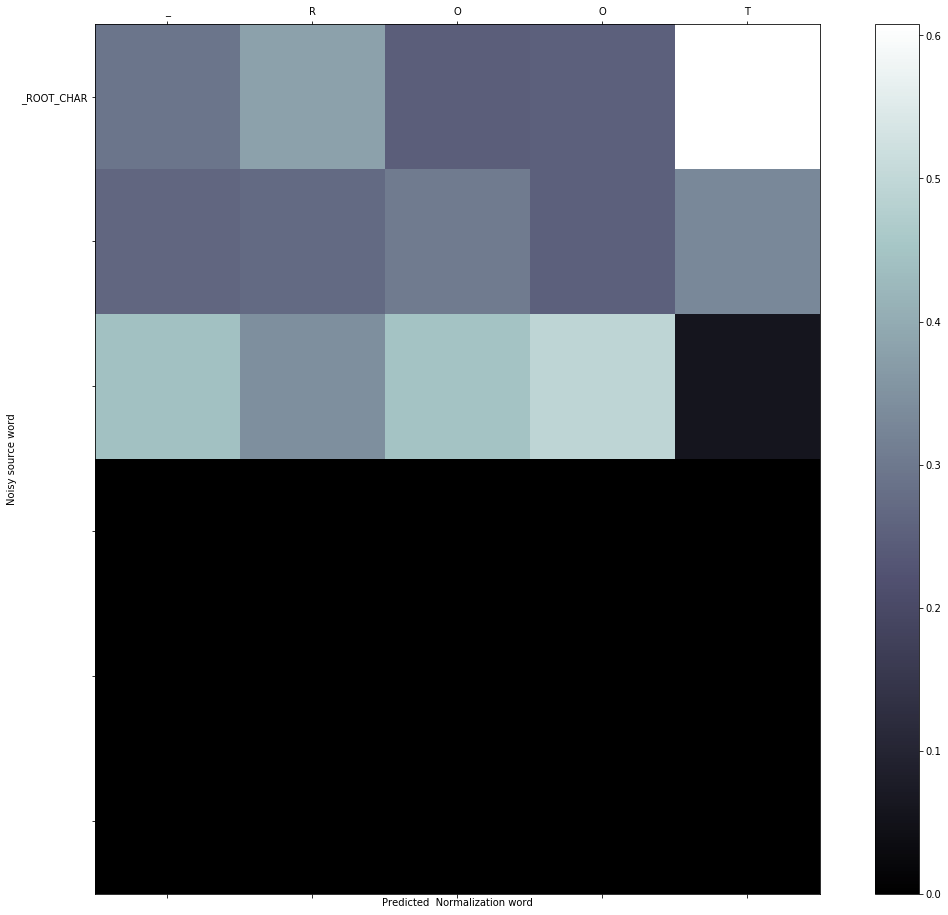

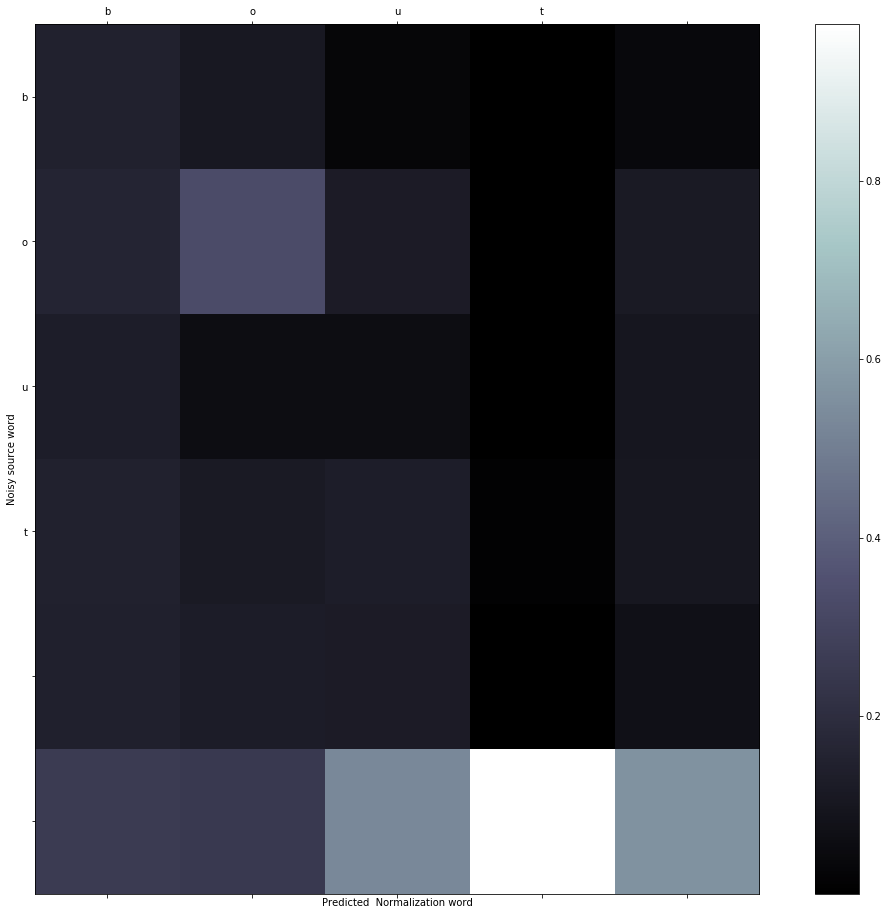

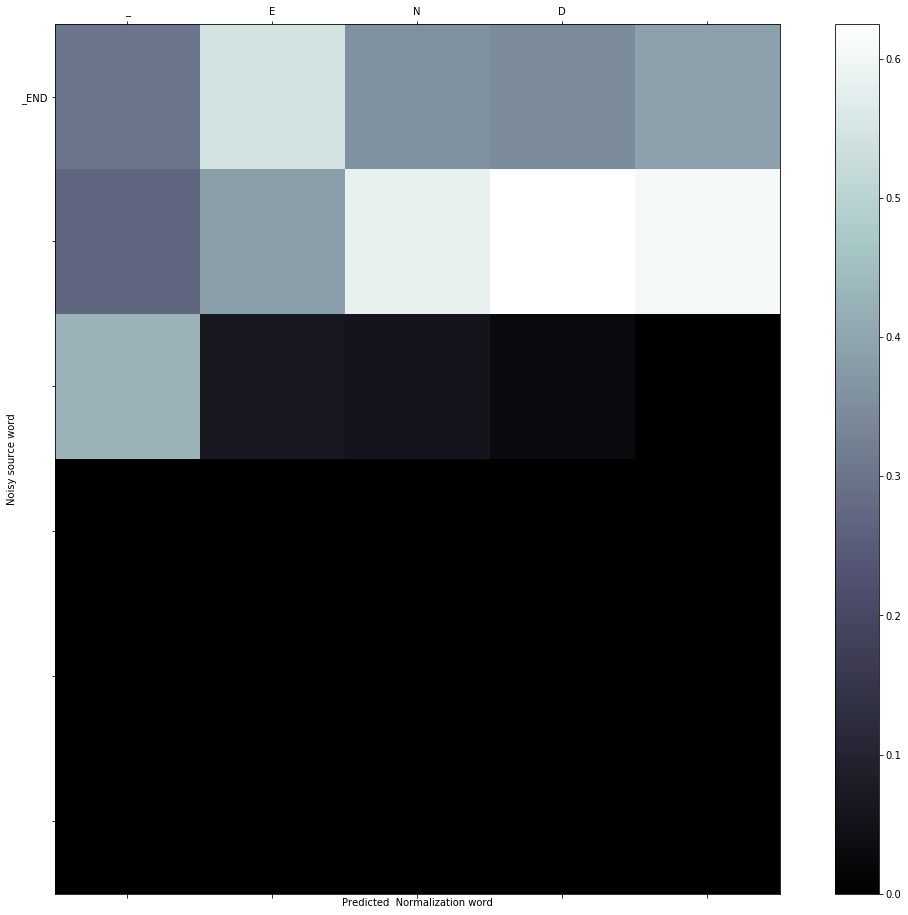

DECODED text is : ['_ROOT_CHAR', 'bout', '_END'] original is ['_ROOT_CHAR', 'bout', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Outlet
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Outlet']
Attention shape torch.Size([3, 7, 8])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.3833,  0.2722,  0.3445,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2497,  0.3068,  0.4435,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2530,  0.2523,  0.4947,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6084,  0.3314,  0.0603,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6385,  0.3531,  0.0084,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6416,  0.2765,  0.0819,  0.0000,

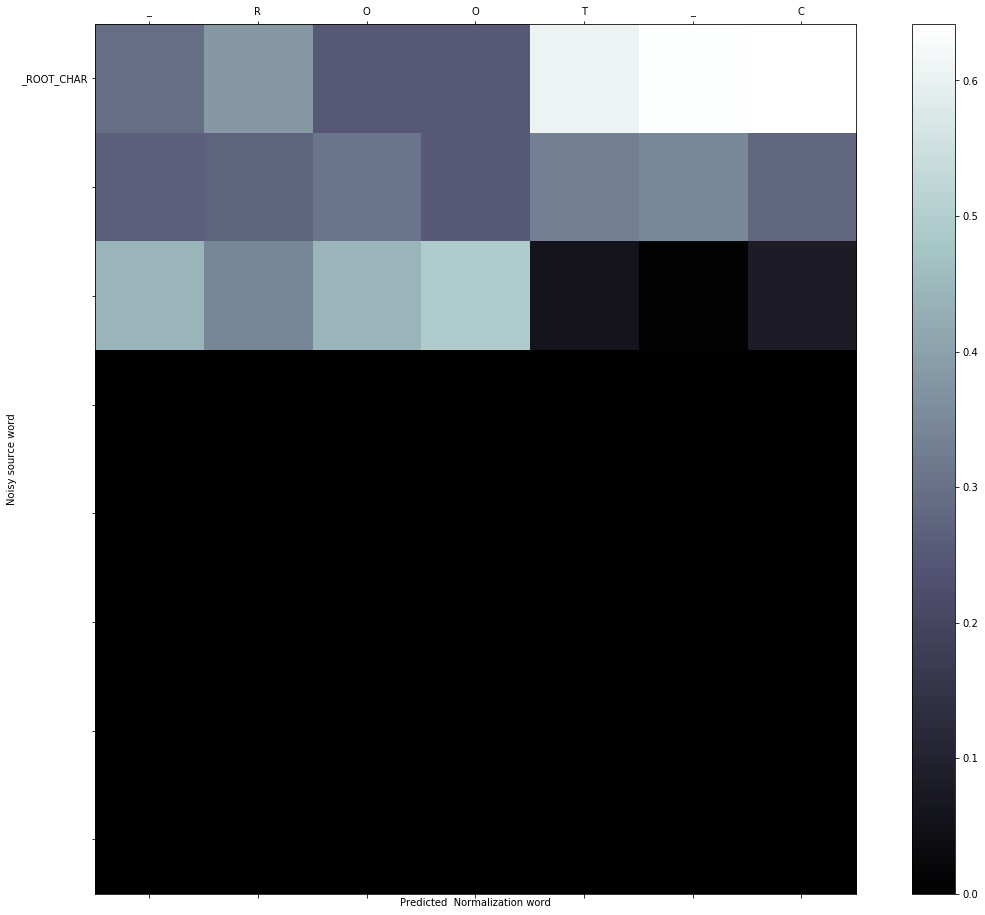

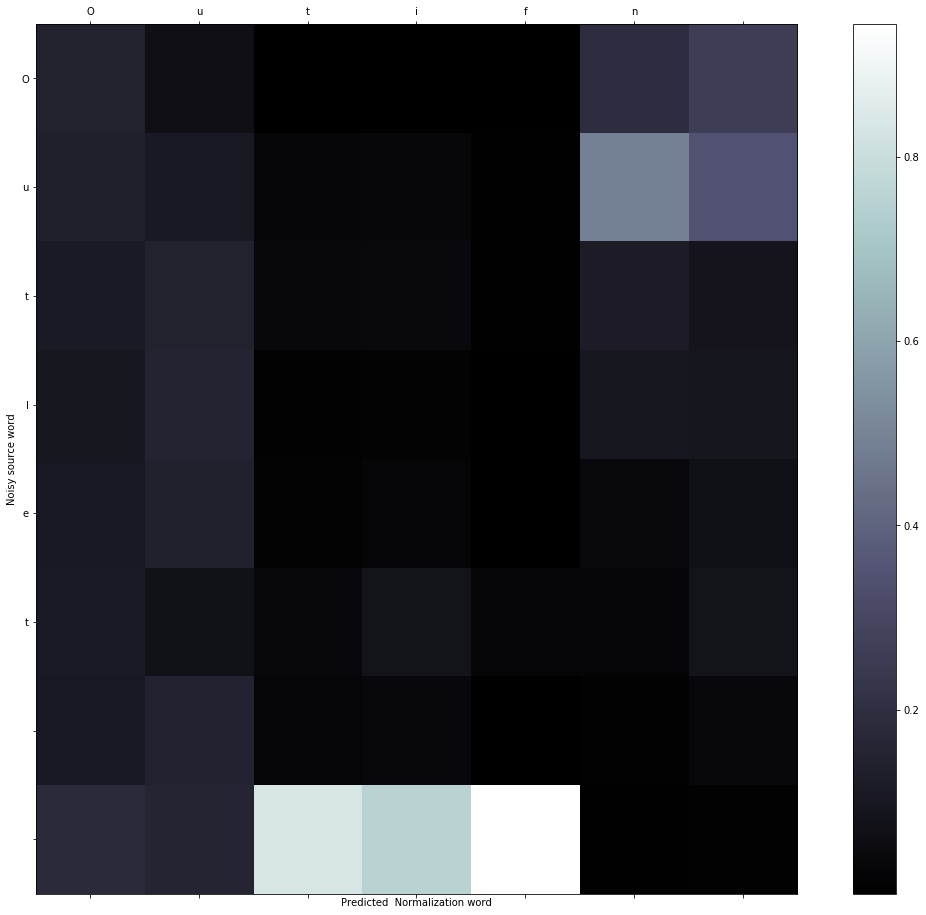

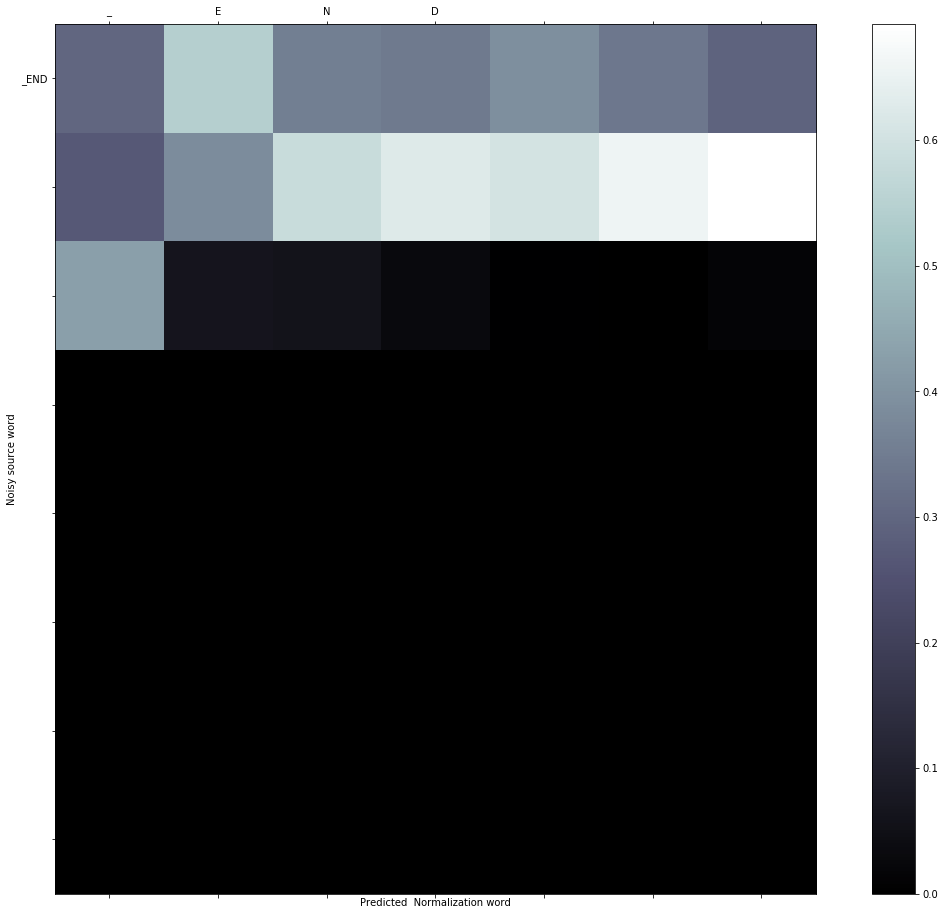

DECODED text is : ['_ROOT_CHAR', 'Outifn', '_END'] original is ['_ROOT_CHAR', 'Outlet', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Except
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Except']
Attention shape torch.Size([3, 7, 8])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.3860,  0.2729,  0.3411,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2525,  0.3089,  0.4386,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2550,  0.2537,  0.4912,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6094,  0.3315,  0.0592,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6389,  0.3527,  0.0083,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6419,  0.2769,  0.0811,  0.0

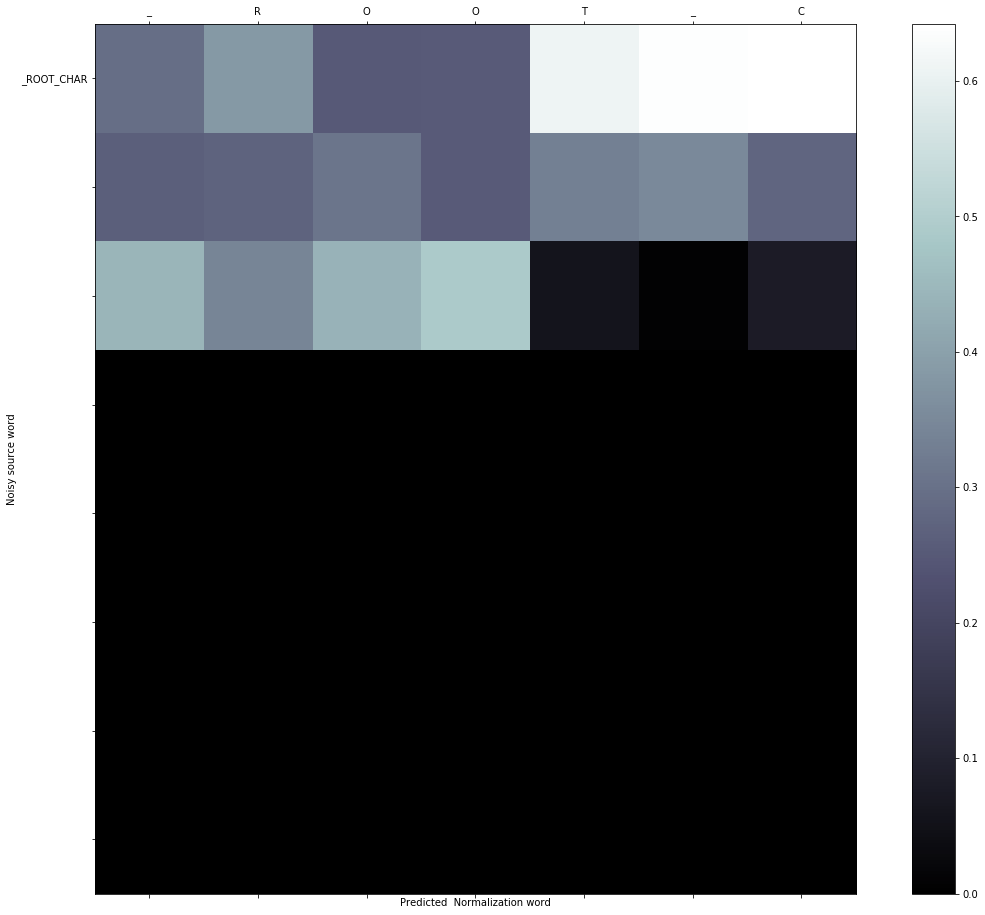

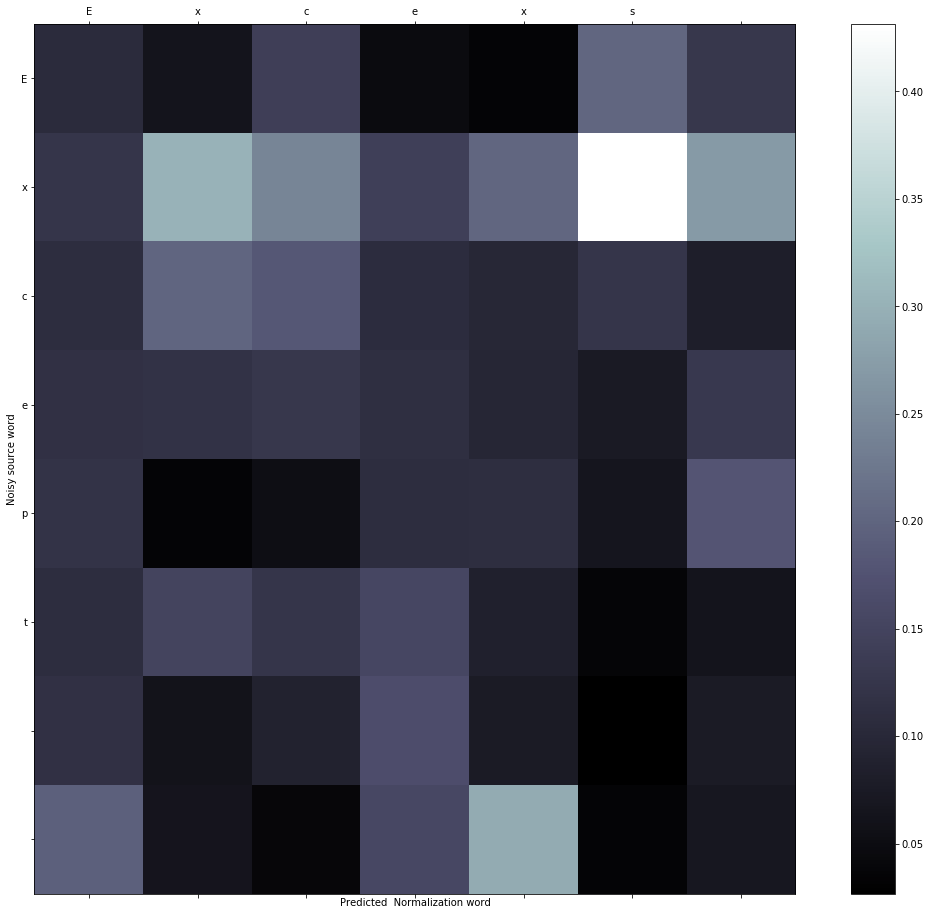

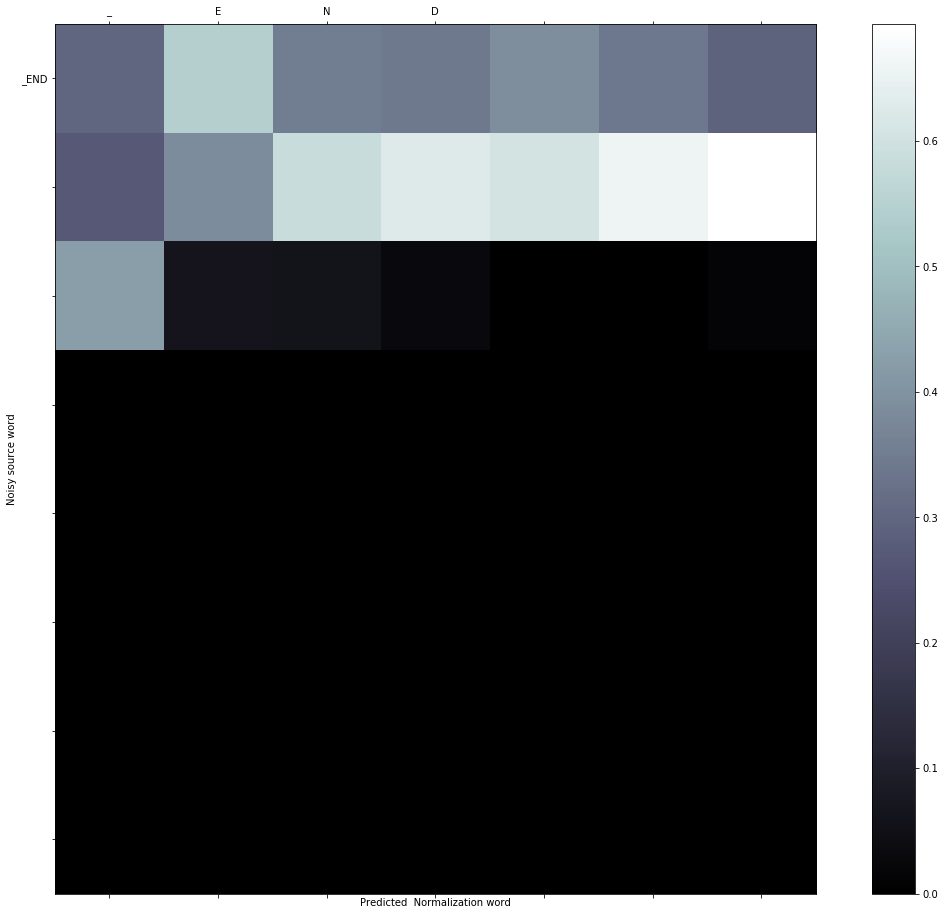

DECODED text is : ['_ROOT_CHAR', 'Excexs', '_END'] original is ['_ROOT_CHAR', 'Except', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Fraud
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Fraud']
Attention shape torch.Size([3, 7, 7])
Attention tensor([[[ 0.2941,  0.2641,  0.4418,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3853,  0.2726,  0.3421,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2524,  0.3090,  0.4385,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2550,  0.2543,  0.4907,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6090,  0.3321,  0.0588,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6384,  0.3532,  0.0083,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6414,  0.2775,  0.0810,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.1163,  0.1209,  0.1406,  0.1257,  0.1316,  0.1295,  0.2355],
       

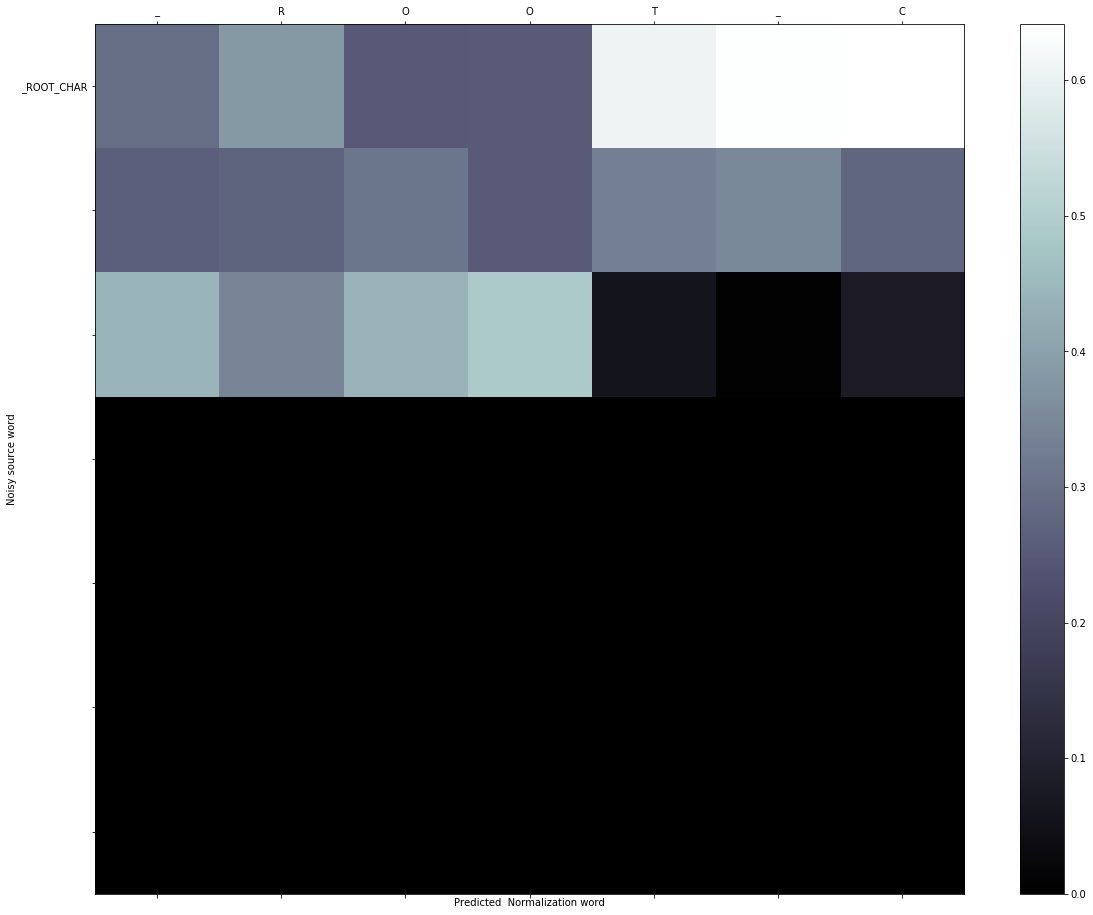

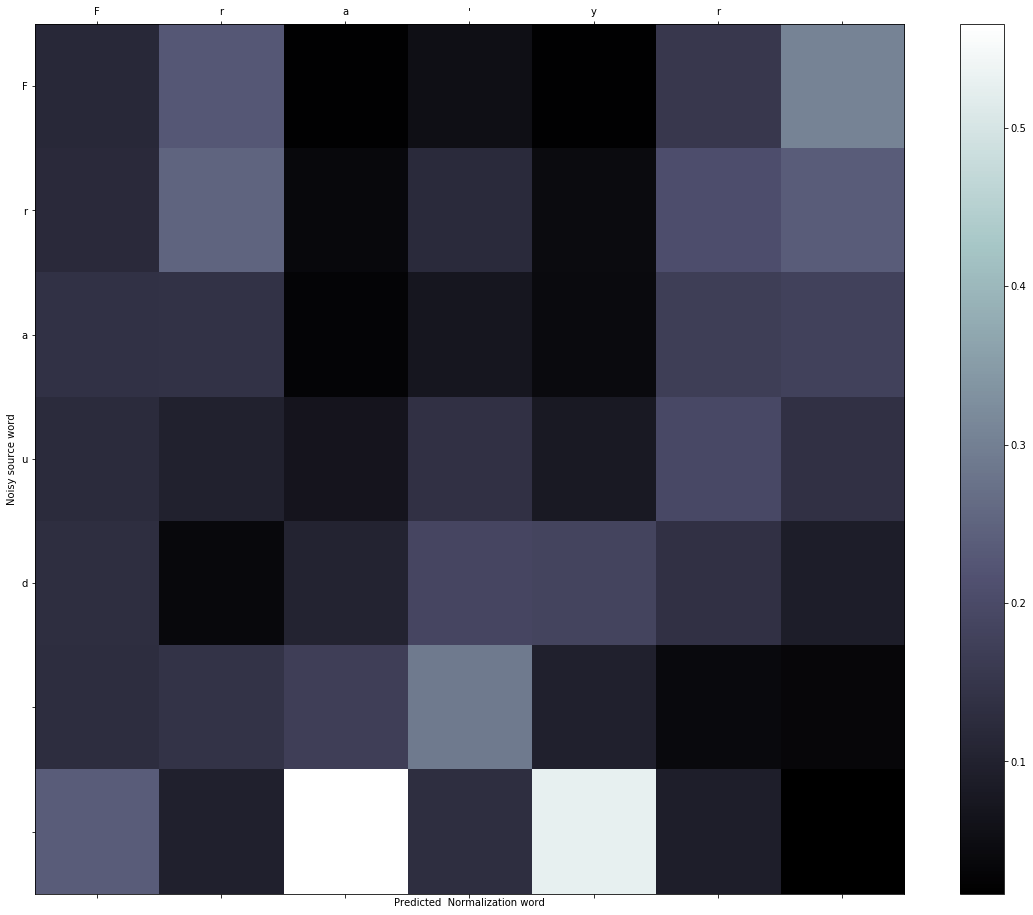

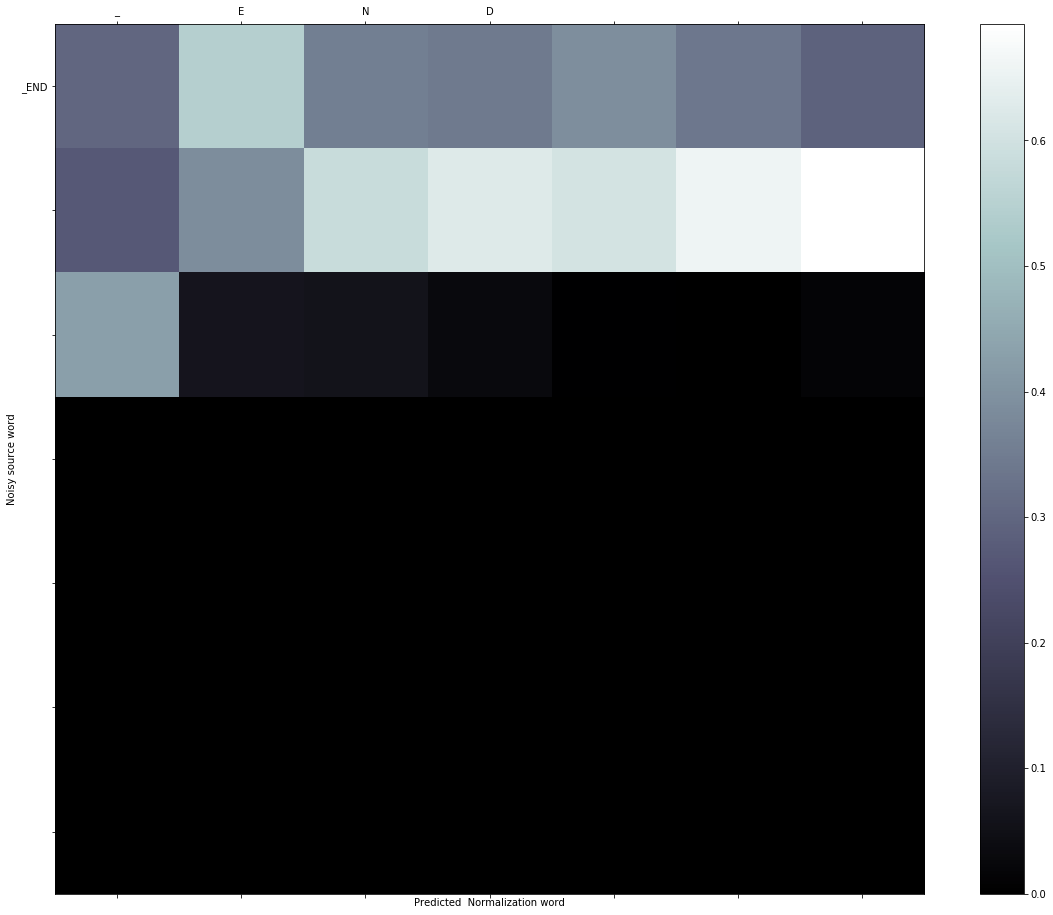

DECODED text is : ['_ROOT_CHAR', "Fra'yr", '_END'] original is ['_ROOT_CHAR', 'Fraud', '_END'] and None seen as word embed 


In [ ]:
for folder_name in list_:
    assert len(list_)>0, "list empty"
    model_full_name = folder_name[:-7]
    print("\n\n--------------------------------Interatcing with new model--------------------------------\n", model_full_name,"\n\n")
    dic_path = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder", "dictionaries")
    model_dir = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder")
    interact(dic_path=dic_path, dir_model=model_dir, model_full_name=model_full_name, debug=False, 
             show_attention=True,verbose=0,extra_arg_specific_label="X1-fine_tune_same_freezing_encoder_bridge-batch_larger-X1",
             save_attention=False)
    #break

## Comments
- on model 97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e with auxilliary task no attention quite small model
    - interesting case : 
        - my normalized to tomorrow : probably bcause of 2mor --> tommorow 
    - very lame at decoding very short word ? 
- 97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1
    - attention is not static --> but no clear trend
    - interetsintgly with same model but only using sent context : the attention focus on last word all the time "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92" 
    
- "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
    - the best model you played with so far
    - classification does not agree with seq predictiion : most of the classification is NORMED while it performs some change

In [1]:
!open

Usage: open [-e] [-t] [-f] [-W] [-R] [-n] [-g] [-h] [-s <partial SDK name>][-b <bundle identifier>] [-a <application>] [filenames] [--args arguments]
Help: Open opens files from a shell.
      By default, opens each file using the default application for that file.  
      If the file is in the form of a URL, the file will be opened as a URL.
Options: 
      -a                Opens with the specified application.
      -b                Opens with the specified application bundle identifier.
      -e                Opens with TextEdit.
      -t                Opens with default text editor.
      -f                Reads input from standard input and opens with TextEdit.
      -F  --fresh       Launches the app fresh, that is, without restoring windows. Saved persistent state is lost, excluding Untitled documents.
      -R, --reveal      Selects in the Finder instead of opening.
      -W, --wait-apps   Blocks until the used applications are closed (even if they were already running).
  

In [ ]:
"./dat